# REINFORCE

## Introduction

The REINFORCE algorithm is one of many among the family of policy-gradient (PG) methods. The basic idea behind PG methods is very simple: we would like to learn a parameterized policy $\pi_{\theta}: S \times A \to [0, 1]$, where $S$ and $A$ are the state and action space of the task we care about. The policy could be a simple linear function or a complicated deep neural network, it just has to be differentiable with respect to its parameters.

We start with a random parameter setting and let the agent act out an episode. After the episode, we perform the update

$$
\theta_{t+1} \leftarrow \theta_{t} + \alpha G_t \frac{\nabla \pi_{\theta}(A_t | S_t)}{\pi_{\theta}(A_t | S_t)}
$$

for every step of the episode. When we're done, we simulate another episode and repeat. That's it.


Intuitively, this update tells the agent two things:

1. Do more of what worked.
2. Do less of what didn't work.

By staring at the equation for long enough, this should eventually make some sense. $\nabla \pi_{\theta}(A_t | S_t)$ is the direction we would move in to increase the probability of taking the action $A_t$ in the future. If the return $G_t$ is large then we want to take a big step along this direction.

The step size is also inversely proportional to the raw probability of the action $\pi_{\theta}(A_t | S_t)$. This way, more frequently chosen actions aren't favored. Without this term, sub-par actions with high probabilities would likely win out over better actions with low probabilities, simply because they are naturally updated more often.

The full algorithm is shown in the box below.

<img src="imgs/reinforce.png" style="width: 500px"/>
<center>Credit: Sutton & Barto (2018)</center>

For those interested, implementing this update in TensorFlow 2.0 can be done as follows. `policy` can be any `tf.keras.Model` object.

```python
for t, transition in enumerate(episode):
    # Compute return from time t
    G = sum(gamma ** i * tr.reward for i, tr in enumerate(episode[t:]))

    # Compute gradient of policy function
    weights = policy.trainable_weights
    with tf.GradientTape() as tape:
        action_probs = tf.squeeze(policy(transition.state.reshape(1, -1)))
        chosen_action = action_probs[transition.action]
        log_prob = tf.math.log(chosen_action)
        grads = tape.gradient(log_prob, weights)

    # Update weights
    for w, g in zip(weights, grads):
        dw = tf.reshape(alpha * gamma ** t * G * g, w.shape)
        w.assign_add(dw)
```

The full code can be found [here](https://github.com/christopher-wolff/rlsuite/blob/master/rlsuite/algos/reinforce.py).

## Advantages

PG methods are typically able to learn arbitrary stochastic policies. In contrast, many value-based methods such as Q-learning are only able to learn greedy or $\epsilon$-greedy policies. This can prove to be an advantage. Consider for instance the following scenario.

<img src="imgs/aliased_gridworld.png" style="width: 200px"/>
<center>Credit: David Silver's RL course slides</center>

The agent randomly starts in one of the two gray cells at the top. At each step, it can move to an adjacent cell. If it reaches the treasure, it receives a reward of +1, and if it reaches one of the skulls, it receives a reward of -1. After either of those cases, the episode terminates.

However, there is one subtlety: the two gray states are aliased. That is, the agent cannot tell them apart. Whatever policy the agent follows in one of them, it must also follow in the other.

Suppose we tried to learn a fully greedy policy, perhaps via Q-learning. Then a learned policy might look like this:

<img src="imgs/aliased_gridworld2.png" style="width: 200px"/>
<center>Credit: David Silver's RL course slides</center>

The agent would get stuck whenever it reaches the top left corner!

Now, suppose that we don't restrict ourselves to greedy policies, but instead use a PG method like REINFORCE to learn a stochastic policy. It's easy to see that the optimal policy is one that chooses among the *left* and *right* actions with equal probability whenever it reaches the gray state, like so:

<img src="imgs/aliased_gridworld3.png" style="width: 200px"/>
<center>Credit: David Silver's RL course slides</center>

Another advantage of PG methods is that they are more direct than value-based methods. After all, in control tasks, we really only care about the policy, and the value function is simply a means to an end. Learning it often requires lots of additional compute, especially in cases when the value function is more complicated than the policy.

Suppose we wanted to learn a racing game in which the optimal policy happens to be driving forward all the time.

<img src="imgs/enduro.png" style="width: 200px"/>
<center>Credit: OpenAI Gym Enduro website</center>

The policy is very simple to represent: just ignore the state and output a high probability for the *forward* action. However, the value function might be much more complicated. Perhaps at some points the car might slow down and yield a lower reward for a while. If we spent all of our time learning a value function, we would have less focus for the thing we really care about.


Finally, the choice of policy lets us inject any prior knowledge we have about the task. For instance, we might use a convolutional neural network for an image-based task, or a simple linear function approximator if we know that there exists a linear solution. Generally, the more expressive the policy, the longer it takes to learn.

## Disadvantages

On the contrary to one of the previous points, there are tasks for which a value function is much simpler to represent than a policy. In a game like chess, for instance, a weighted sum of all existing pieces on the board might make for a decent value function, but it is far from trivial to describe a good policy function.

Furthermore, PG methods are known to be quite sample inefficient. That is, they need lots of data to train. We will see whether this holds true in a simple experiment shortly.

The REINFORCE algorithm in particular suffers from a big flaw: the update steps have very high variance. The main reason for this is that we are using the Monte-Carlo return as a scaling factor for our updates. There are ways to fix this but we will not discuss those here. If you are curious, see Section 13.4 of Sutton & Barto or the Advantage Actor-Critic algorithm.

## Experiments

We will attempt to solve the inverted pendulum problem -- a well known task in the control literature. The policy we want to learn will be a single-layer neural network. Its input is an observation vector, which represents the position of the cart, the velocity of the cart, the angle of the pole, and the angular velocity of the pole. Its output are two numbers, representing the probabilities of moving the cart left and right, respectively.

In [1]:
import tensorflow as tf

policy = tf.keras.Sequential([
    tf.keras.layers.Dense(2, input_shape=(4,), activation='softmax')
])
policy.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


Next, we run the algorithm for 5000 episodes, using the default values of $\alpha = 0.001$ and $\gamma = 0.99$. Warning: this might take a while!

In [2]:
from rlsuite.algos import reinforce
import gym

trained_policy = reinforce(
    env_fn=lambda: gym.make('CartPole-v1'),
    policy=policy,
    num_episodes=5000,
    data_dir='/tmp/experiments/cartpole',
    log_freq=1000,
    seed=0,
)

+-----------------+-----------------+
|       iteration | 0               |
|  episode_length | 10              |
|  episode_return | 10.0000         |
|       grad_norm | 0.4580          |
|      theta_norm | 1.4665          |
|            time | 0.0668          |
+-----------------+-----------------+
+-----------------+-----------------+
|       iteration | 1000            |
|  episode_length | 54              |
|  episode_return | 54.0000         |
|       grad_norm | 0.1571          |
|      theta_norm | 10.8531         |
|            time | 331.6563        |
+-----------------+-----------------+
+-----------------+-----------------+
|       iteration | 2000            |
|  episode_length | 365             |
|  episode_return | 365.0000        |
|       grad_norm | 1.0529          |
|      theta_norm | 18.4217         |
|            time | 1046.1774       |
+-----------------+-----------------+
+-----------------+-----------------+
|       iteration | 3000            |
|  episode_l

Let's see how well the agent did by visualizing how the episode return changes over time. The return represents the number of time steps that the agent was able to balance the pole without it falling below a certain angle threshold.

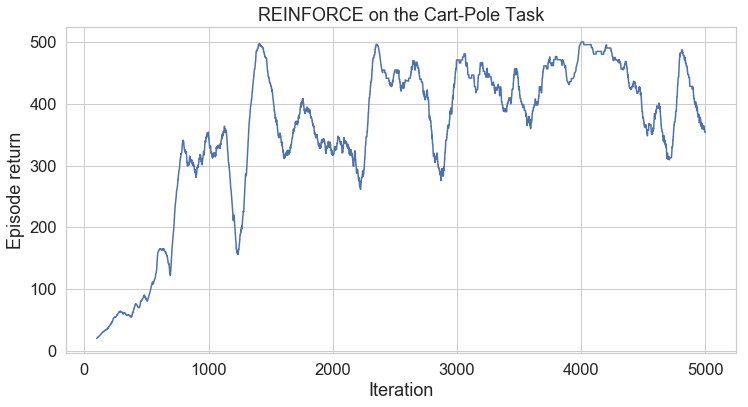

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
from rlsuite.utils import load_data

data = load_data('/tmp/experiments/cartpole')

# Smooth the data a little bit so that we can visualize it more easily
data['episode_return_smooth'] = data['episode_return'].rolling(window=100).mean()

# Create a line plot of episode return vs. iteration number
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid", font_scale=1.5)
sns.lineplot(data=data, x='iteration', y='episode_return_smooth')
plt.title('REINFORCE on the Cart-Pole Task')
plt.xlabel('Iteration')
plt.ylabel('Episode return')
plt.show()

This looks good! It seems as though our agent learns to get a higher reward over time. Let's also take a look at the magnitude of the parameter vector $\theta$ at each step. This can give us some information about the stability of our algorithm.

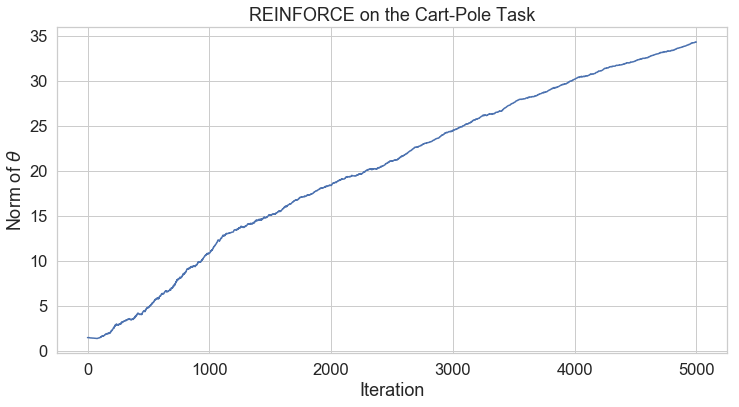

In [4]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid", font_scale=1.5)
sns.lineplot(data=data, x='iteration', y='theta_norm')
plt.title('REINFORCE on the Cart-Pole Task')
plt.xlabel('Iteration')
plt.ylabel(r'Norm of $\theta$')
plt.show()

Interesting. It looks like the parameters might be diverging. Why is this? If we think back to our policy function, we use a softmax activation for the outputs of the final layer in order to compute the final probabilities. This means that the probability for going left is computed as

$$
\mathbb{P}(\text{left}) = \frac{\exp(s_{\text{left}})}{\exp(s_{\text{left}}) + \exp(s_{\text{right}})}
$$

$s_{\text{left}}$ and $s_{\text{right}}$ here are simply a linear combination of the observeration vector and depend on the parameters of the network. Increasing either of these "scores" will thus result in a higher probability of choosing the respective action! Thinking back to the parameter update we are doing at each step, this is exactly what we'd expect. Since the reward is always positive, we always take steps that makes our actions more likely, even if we failed almost instantly. So both scores are constantly increasing alongside each other, and over time the parameters grow larger and larger. This might seem undesirable, but as long as the action probabilities converge to a stable value, it works just fine.

Since just looking at plots is boring, so let's see the final policy in action by rendering the environment. RL Suite comes with a `display_frames_as_gif` function that lets us do just this. We'll run the final policy for another 1000 time steps and display the result.

Note two things when using the policy to generate an action:
1. We have to reshape the observation into a $1 \times d$ array.
2. We have to reshape the output back into an array so that we can call `np.random.choice` on it.

This is because TensorFlow always works with batches of data, but we only have a single observation.


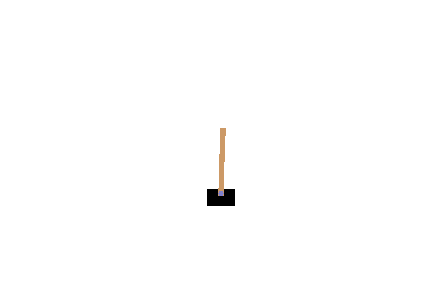
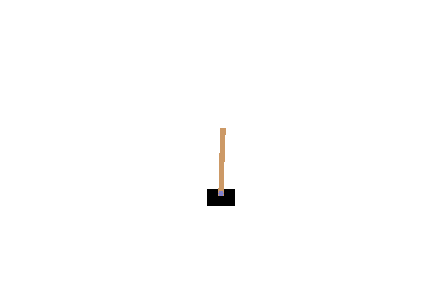
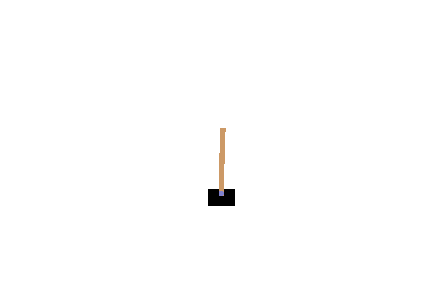
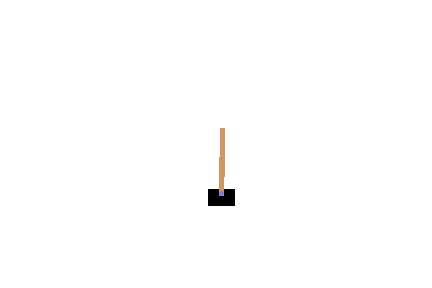
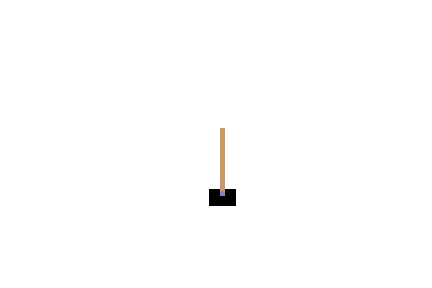
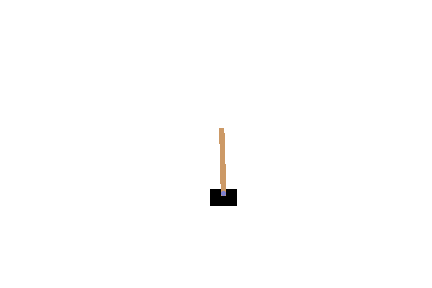
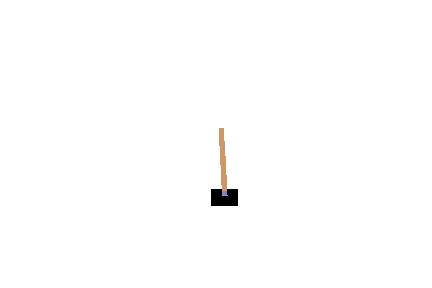
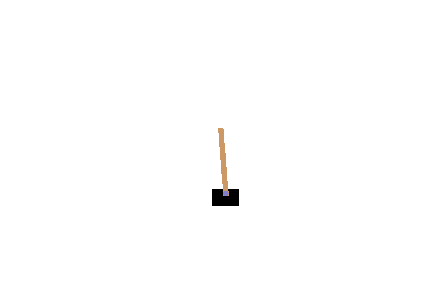
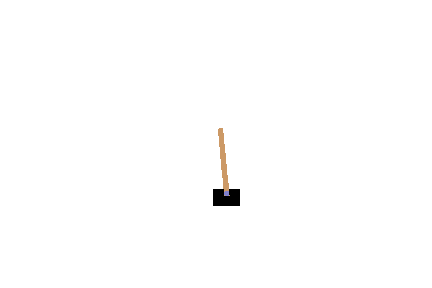
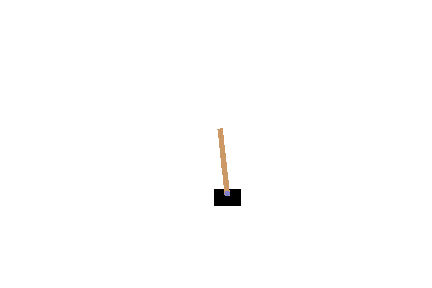
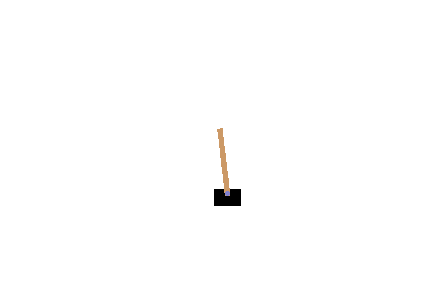
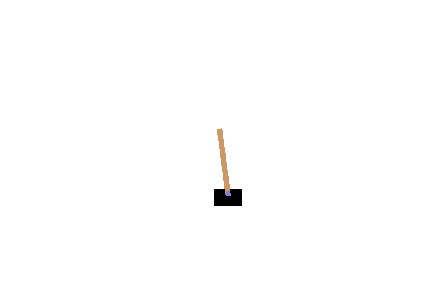
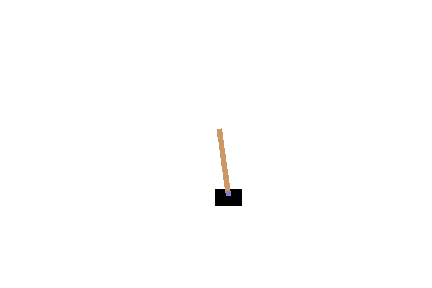
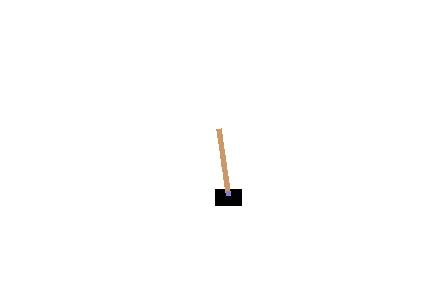
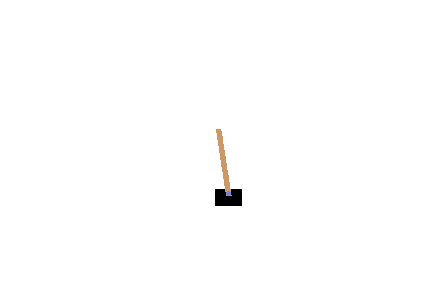
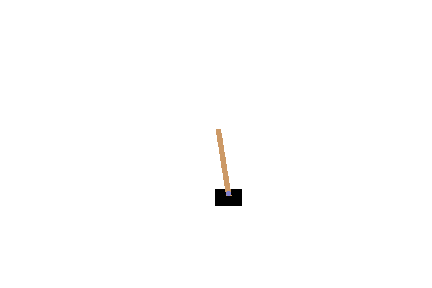
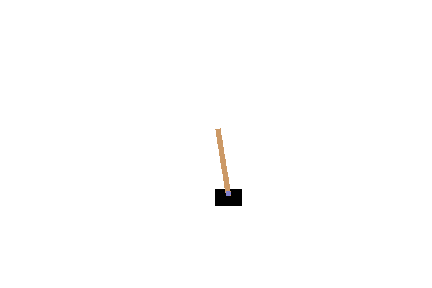
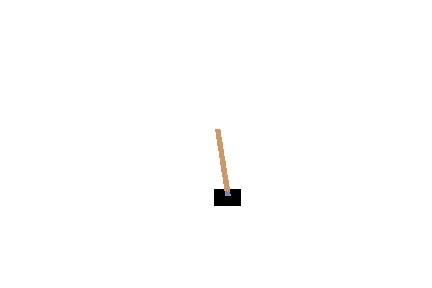
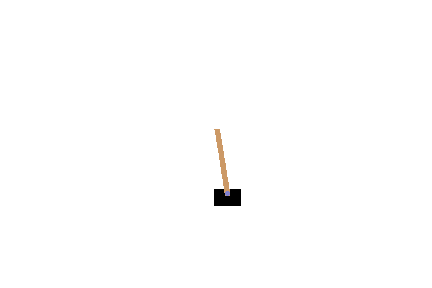
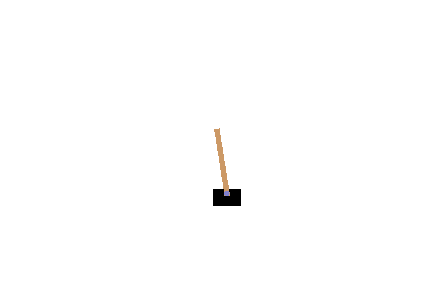
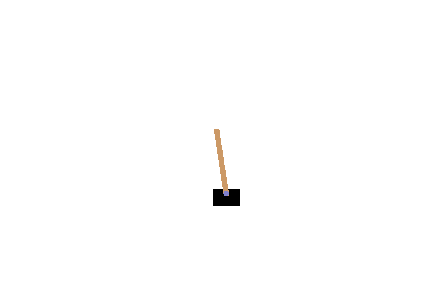
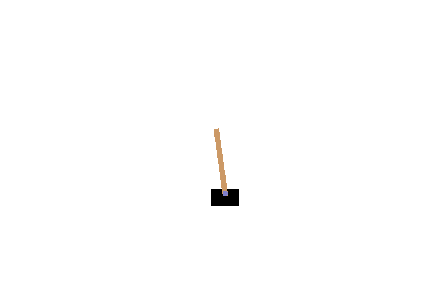
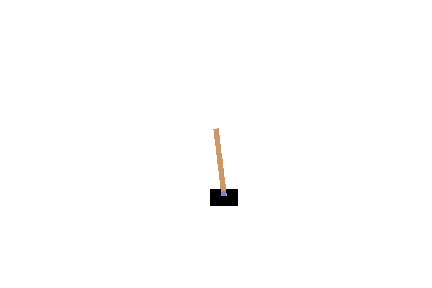
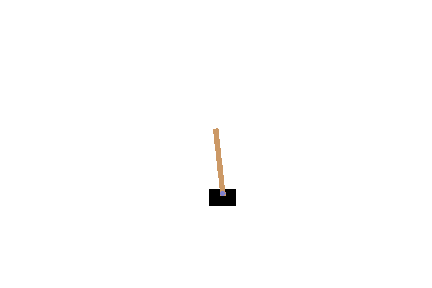
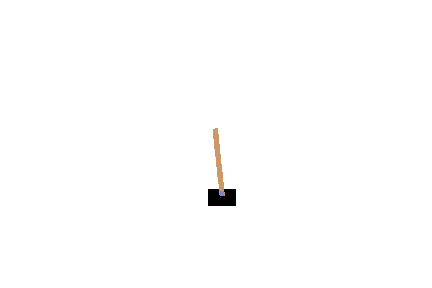
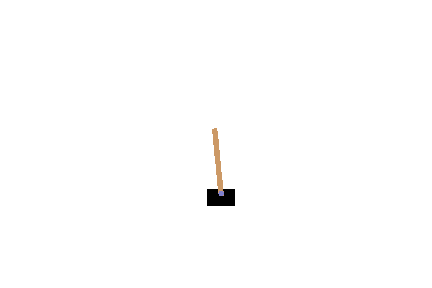
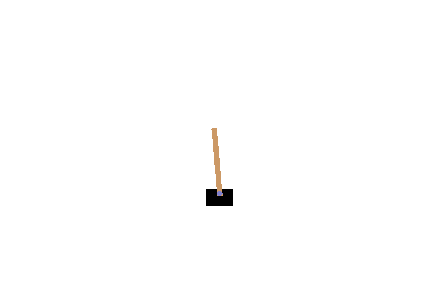
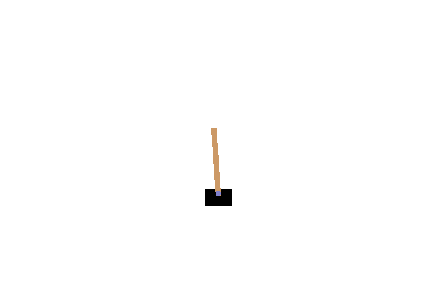
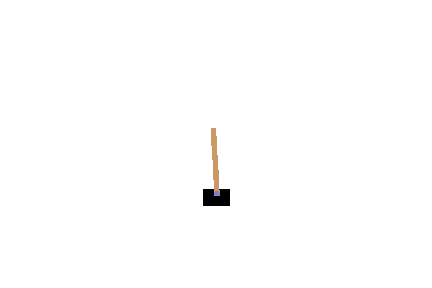
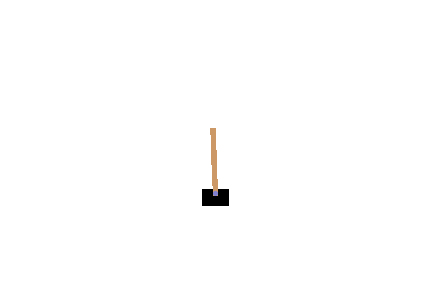
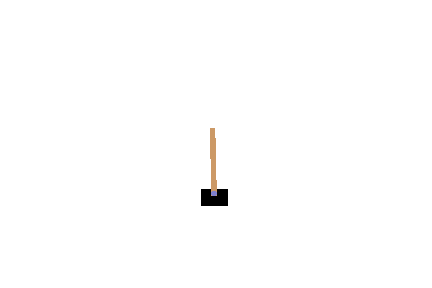
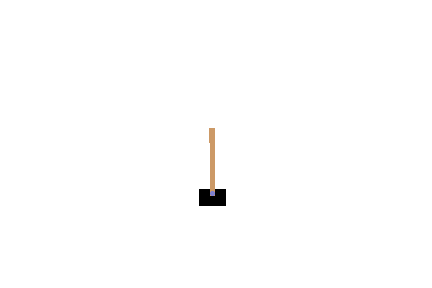
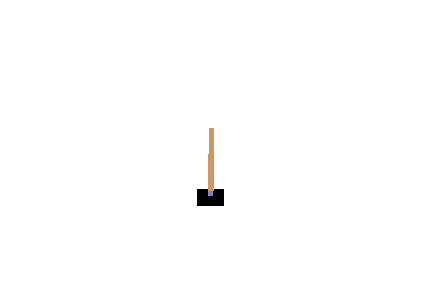
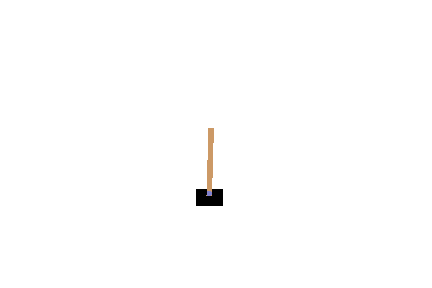
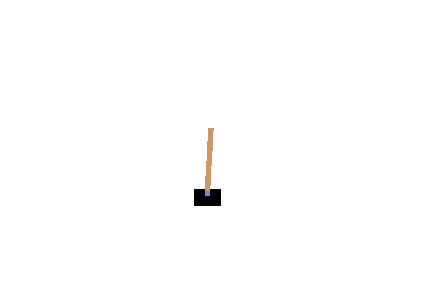
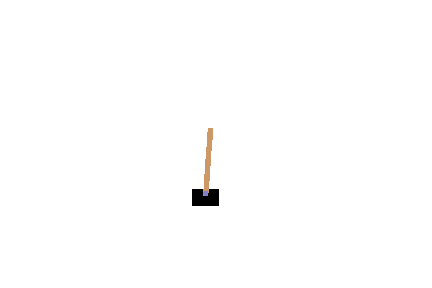
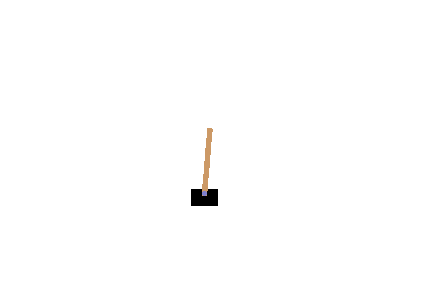
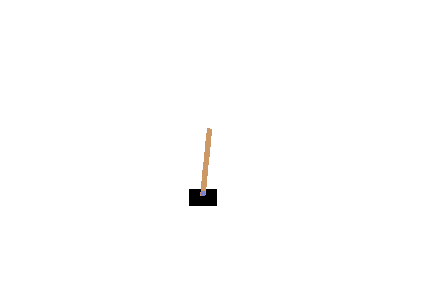
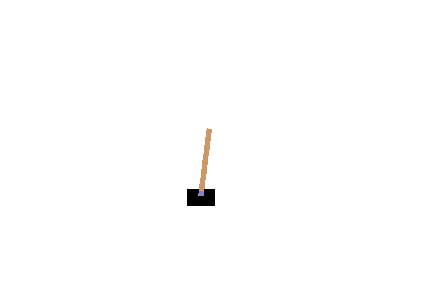
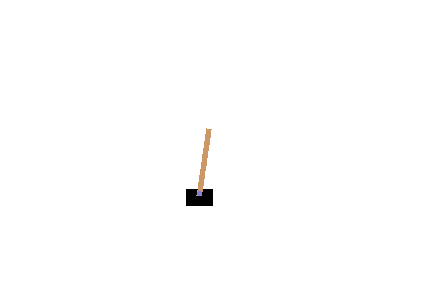
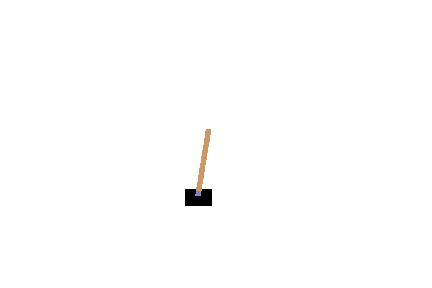
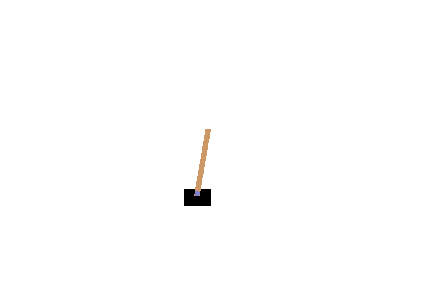
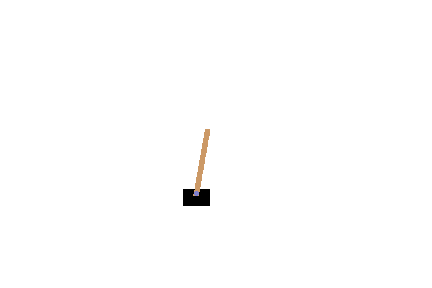
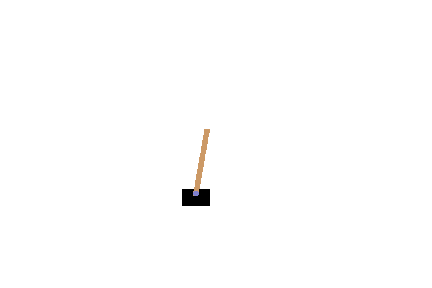
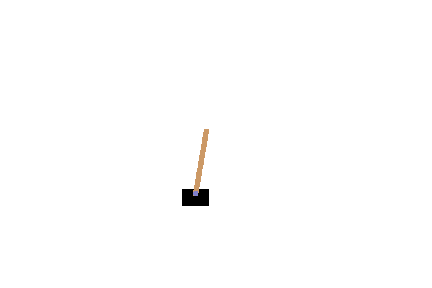
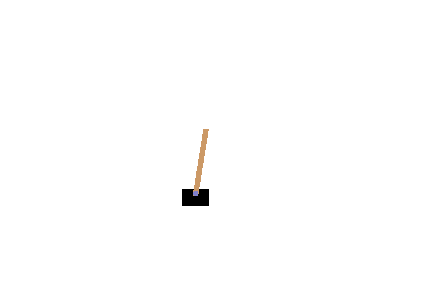
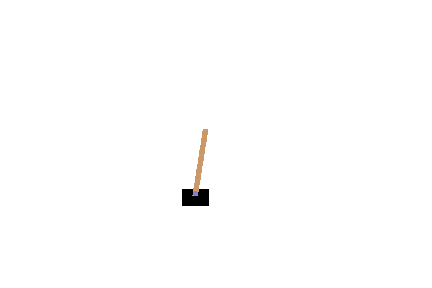
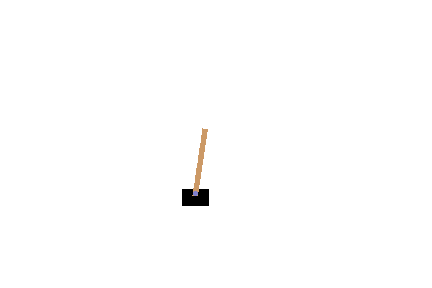
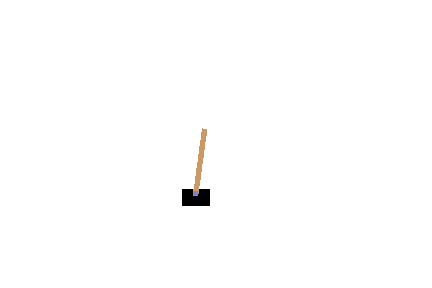
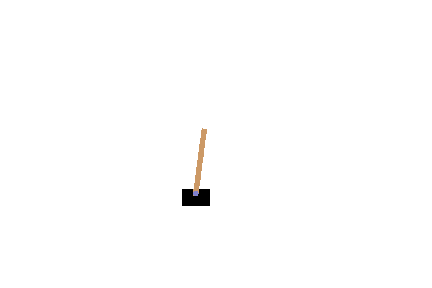
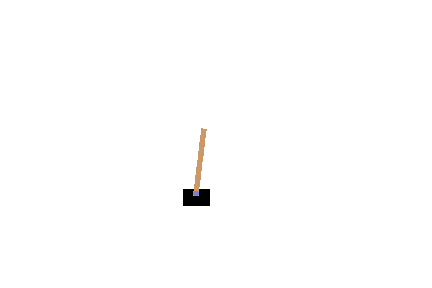
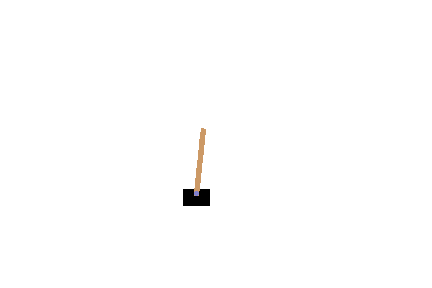
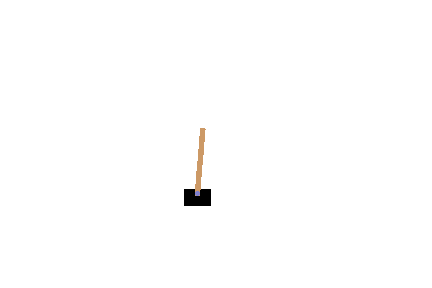
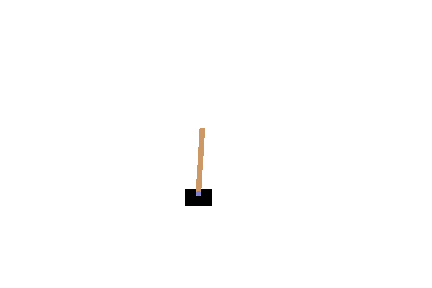
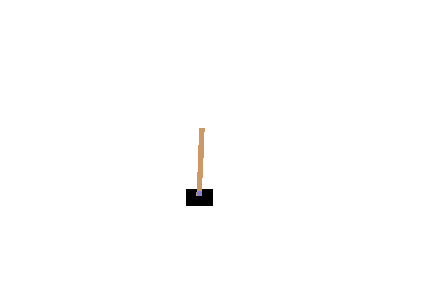
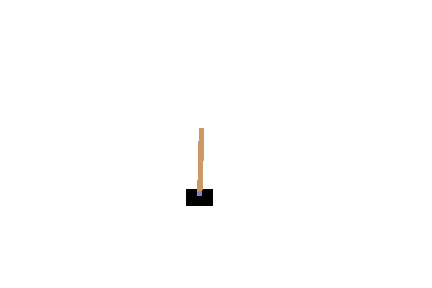
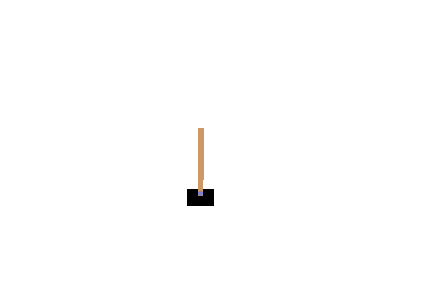
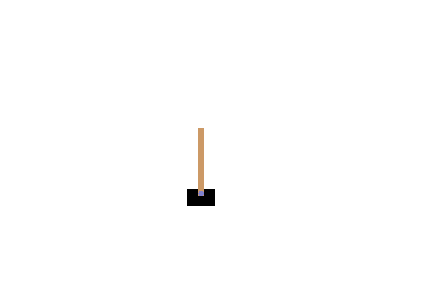
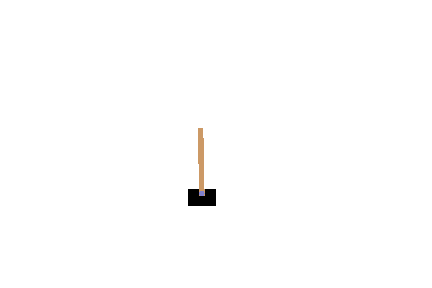
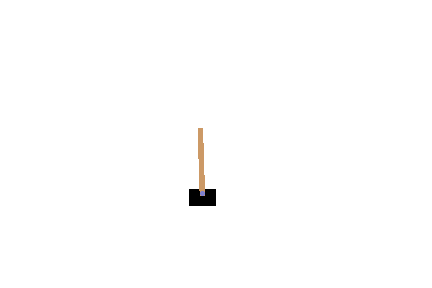
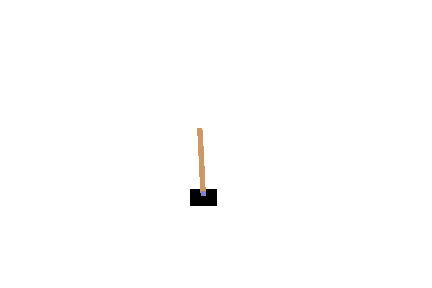
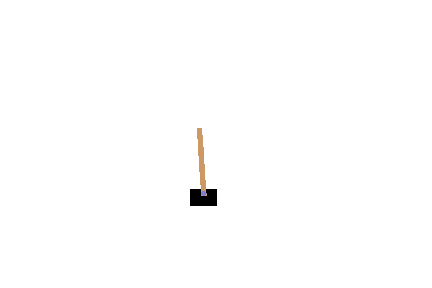
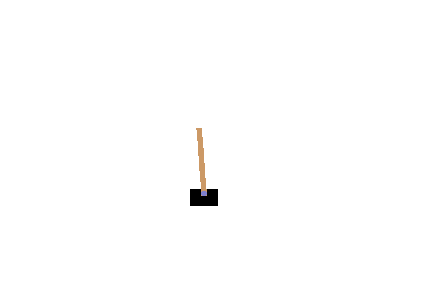
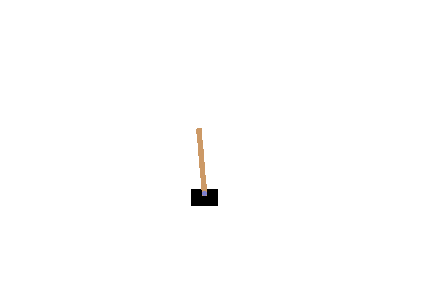
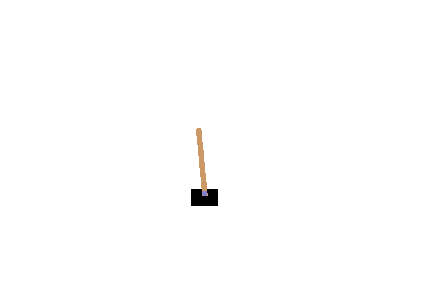
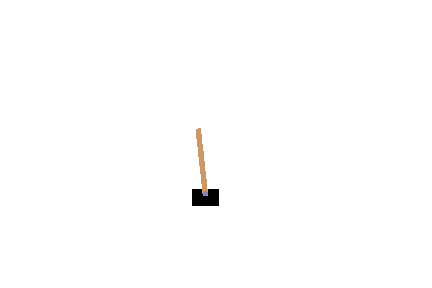
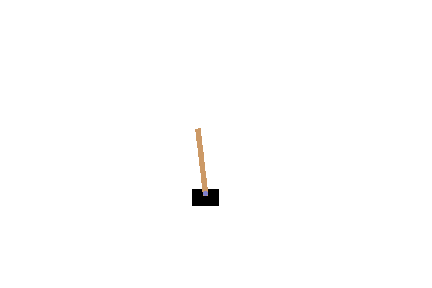
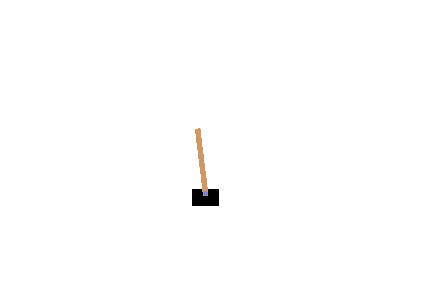
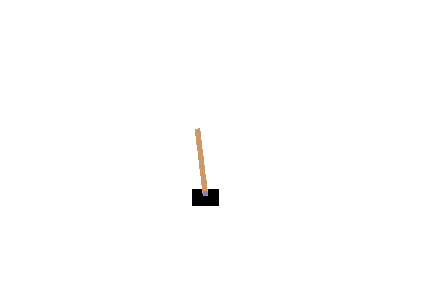
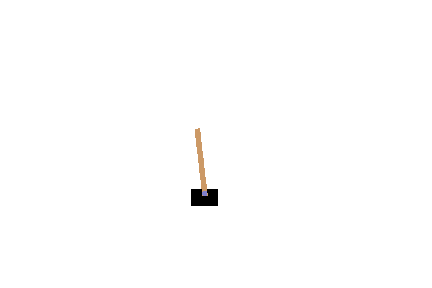
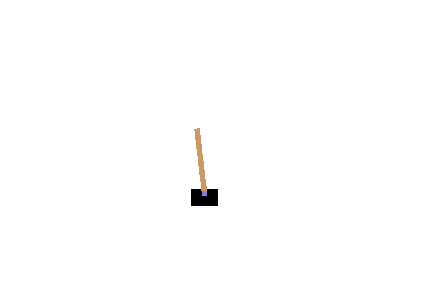
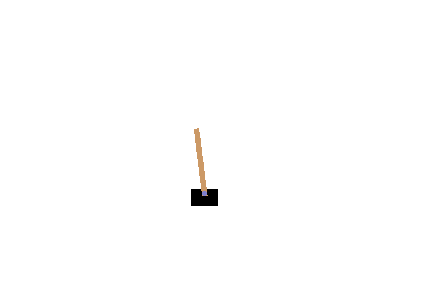
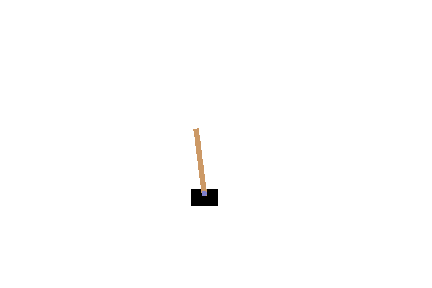
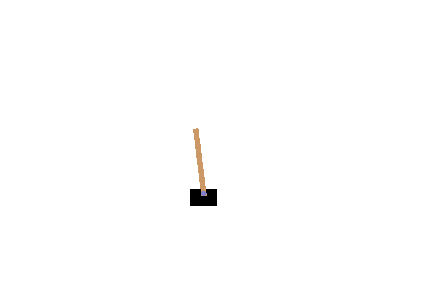
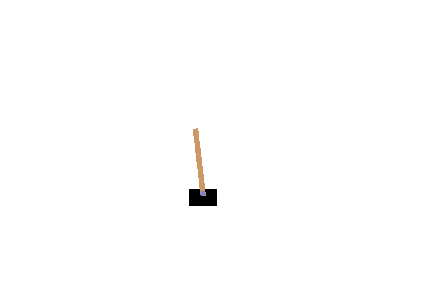
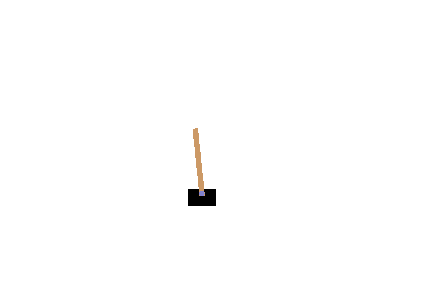
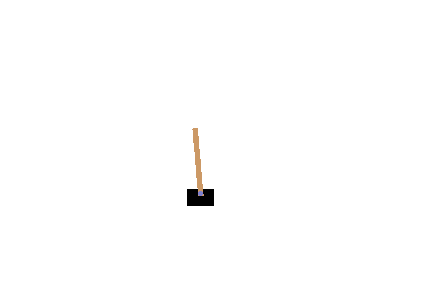
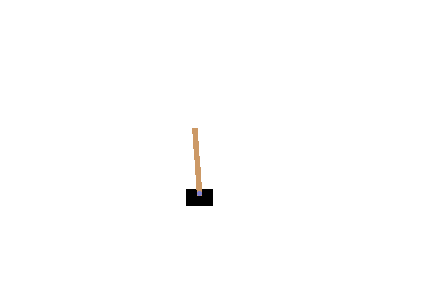
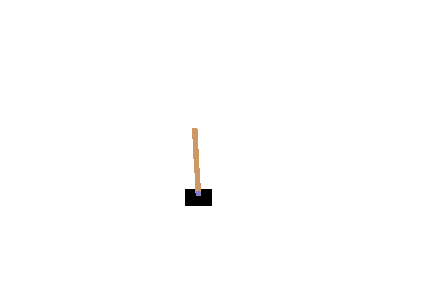
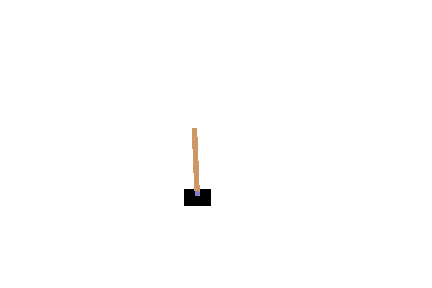
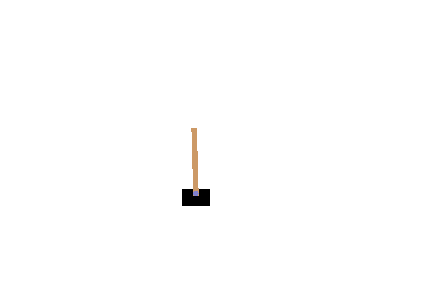
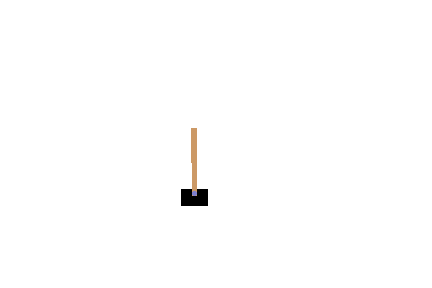
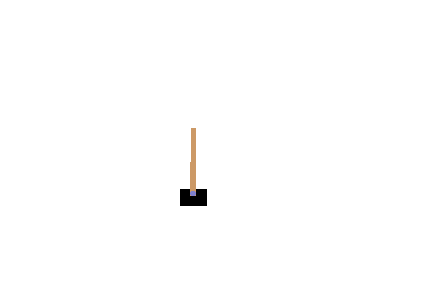
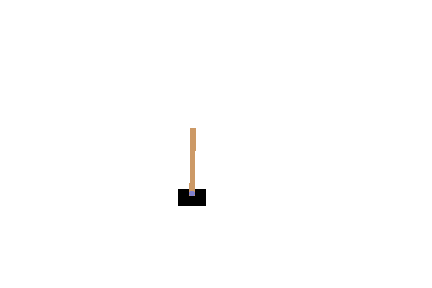
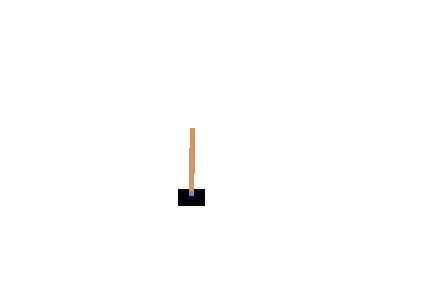
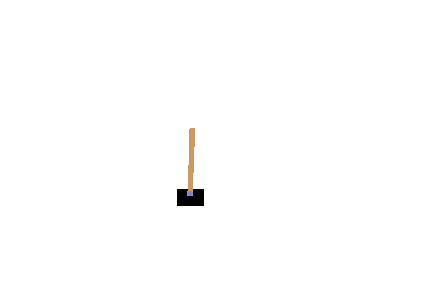
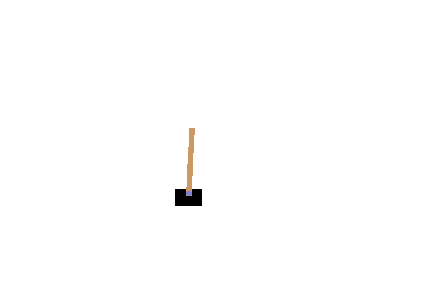
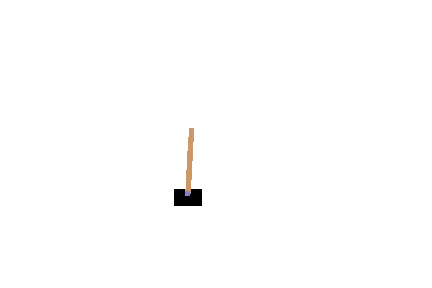
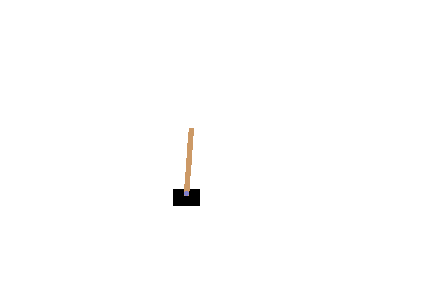
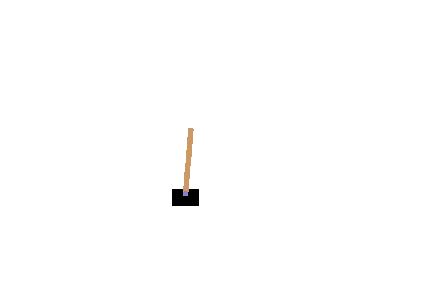
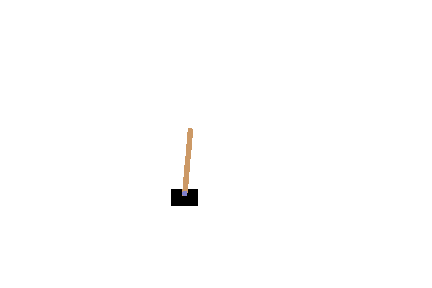
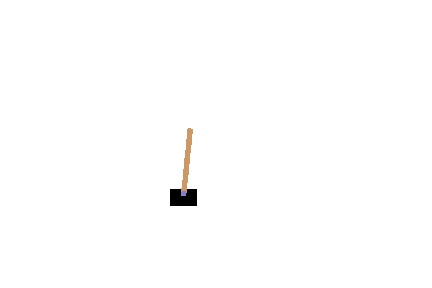
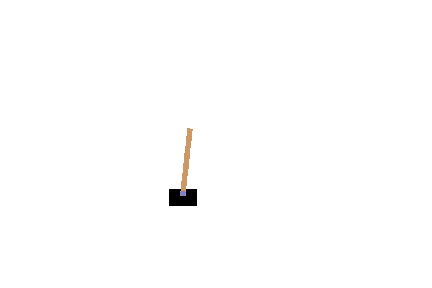
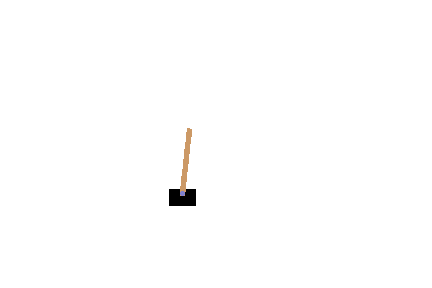
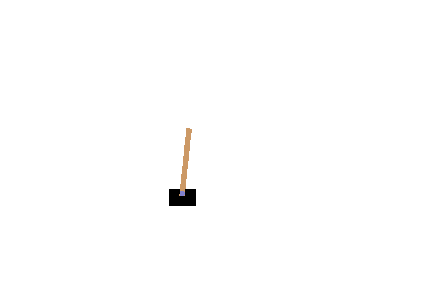
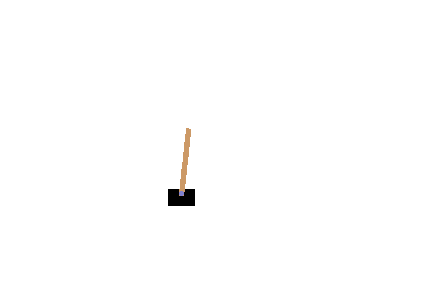
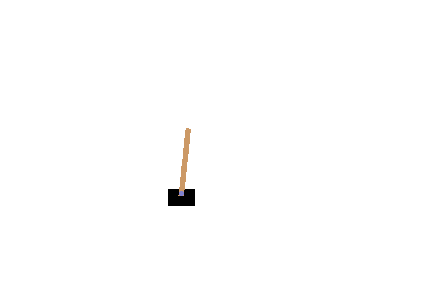
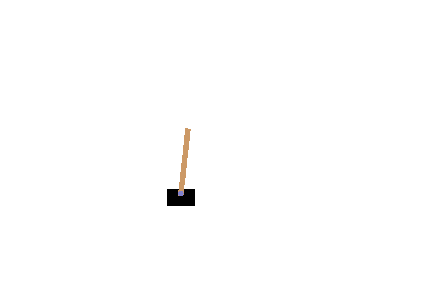
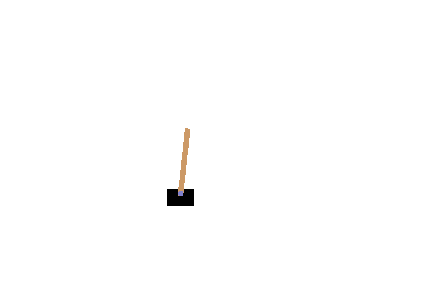
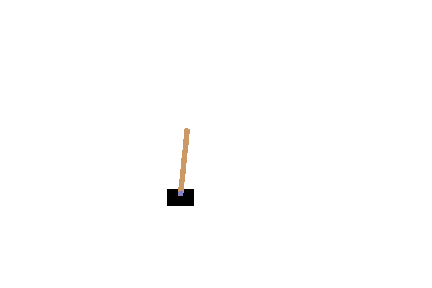
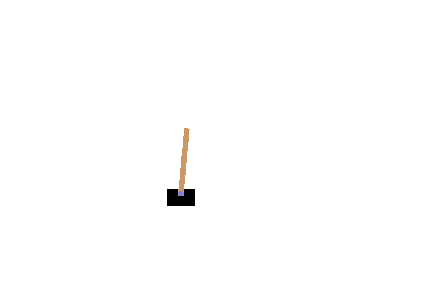
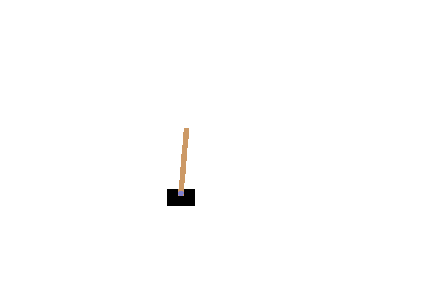
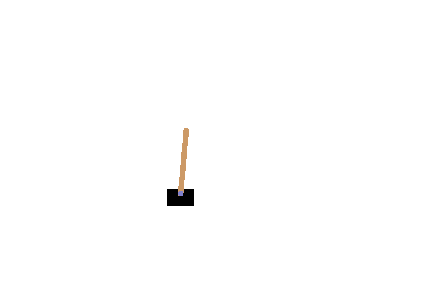
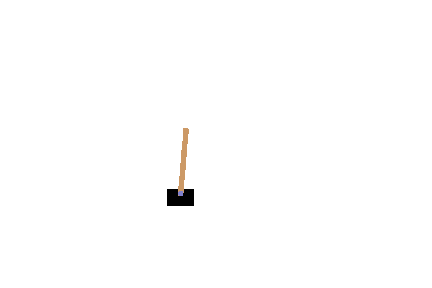
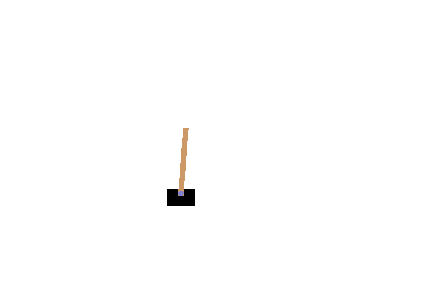
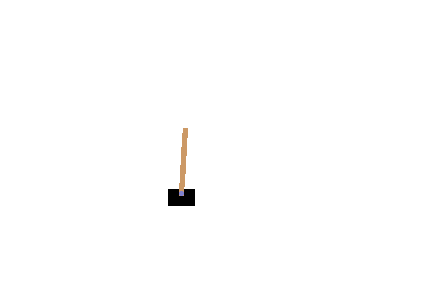
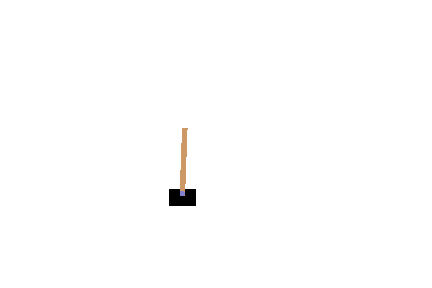
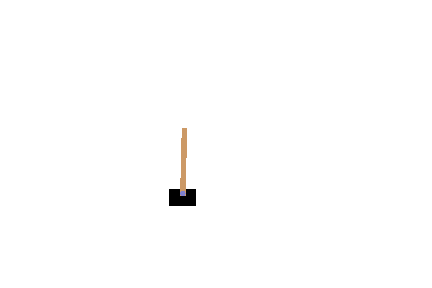
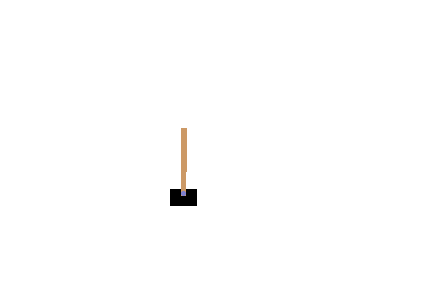
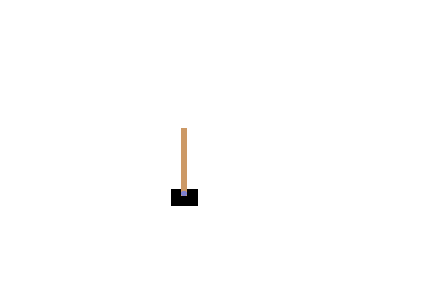
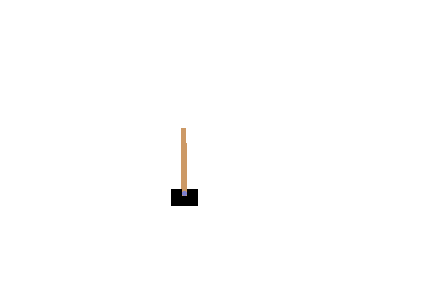
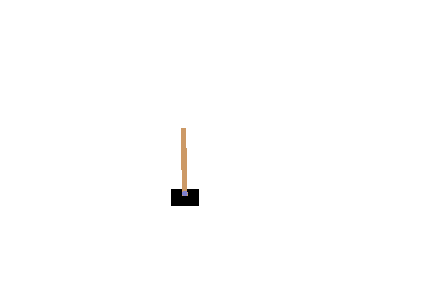
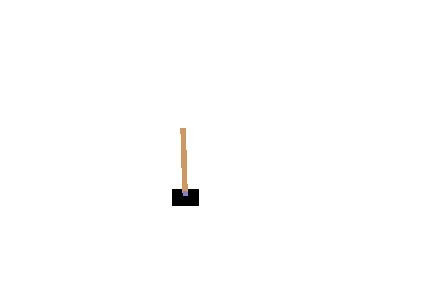
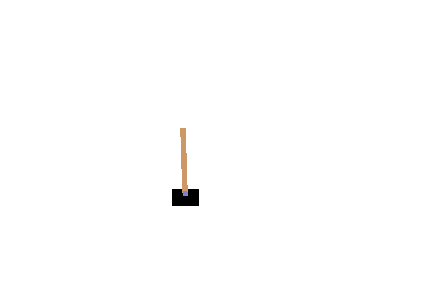
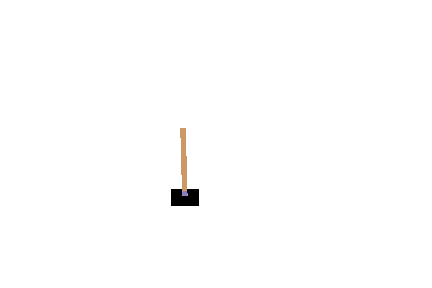
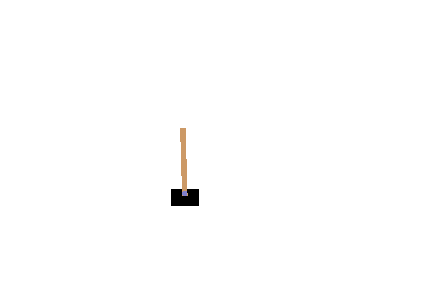
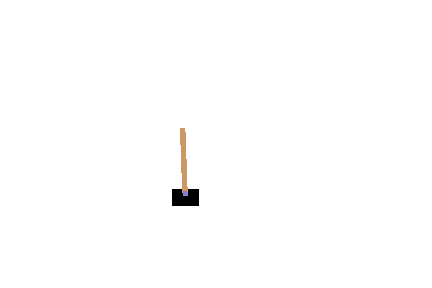
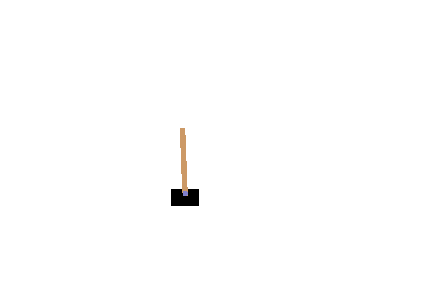
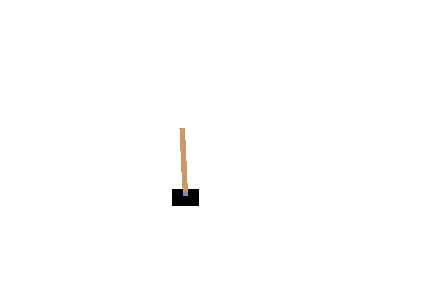
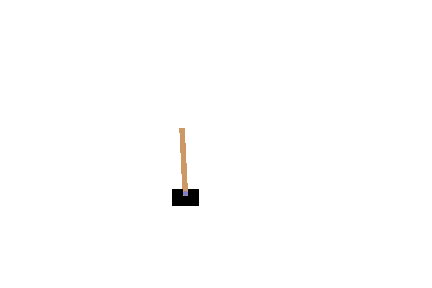
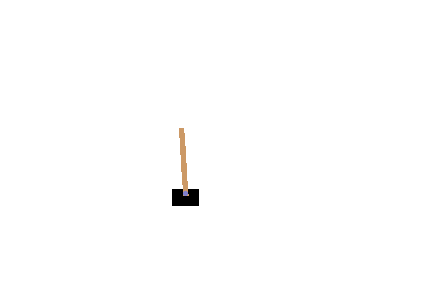
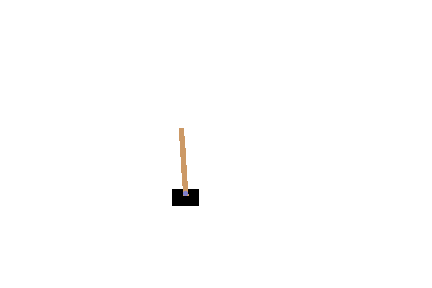
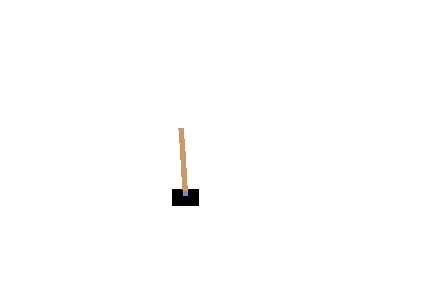
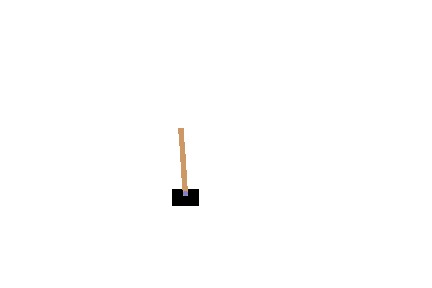
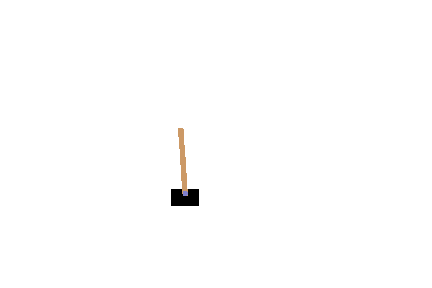
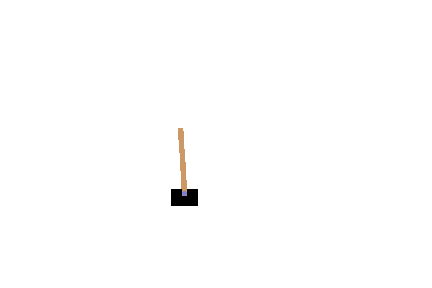
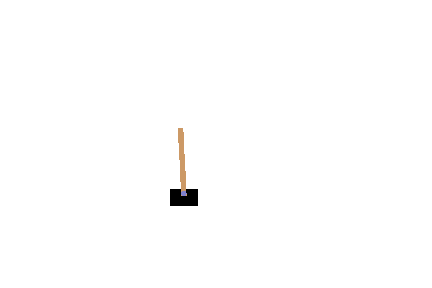
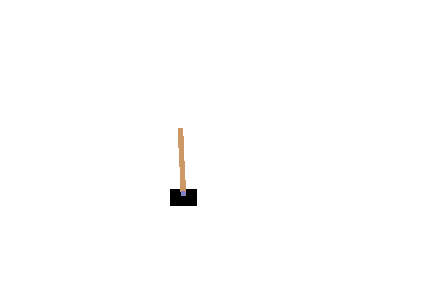
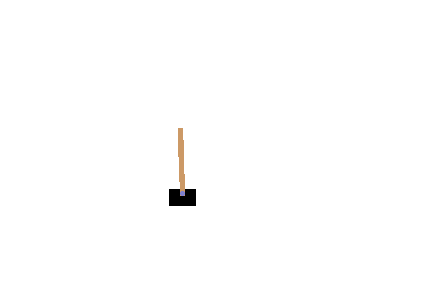
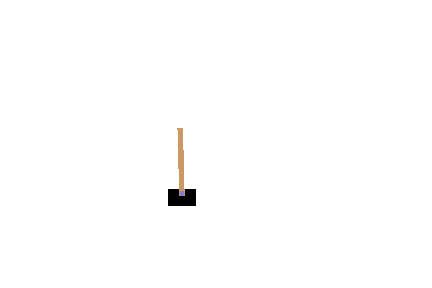
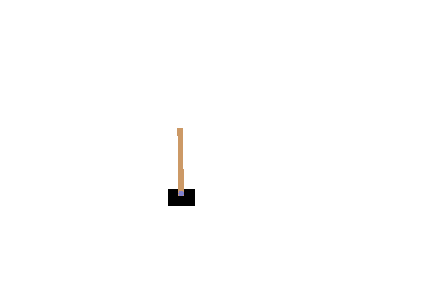
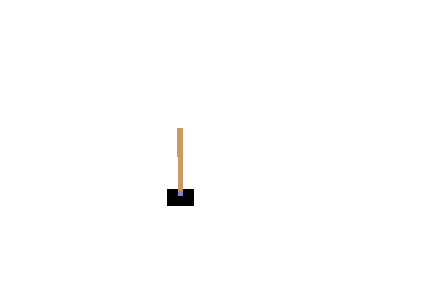
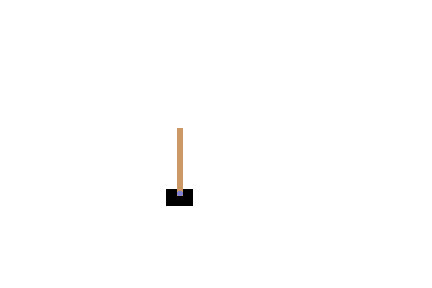
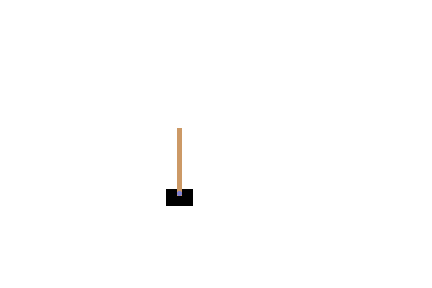
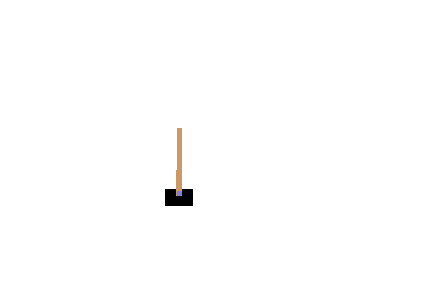
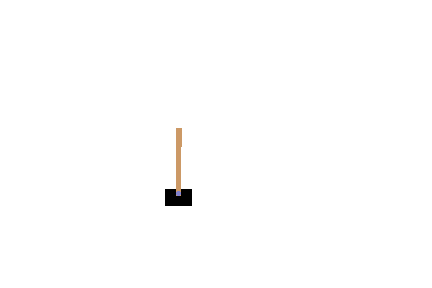
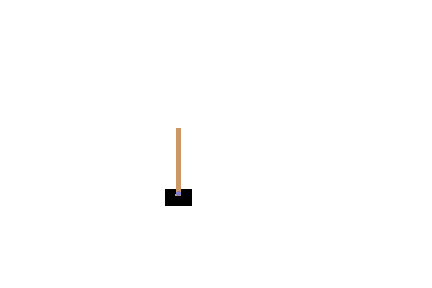
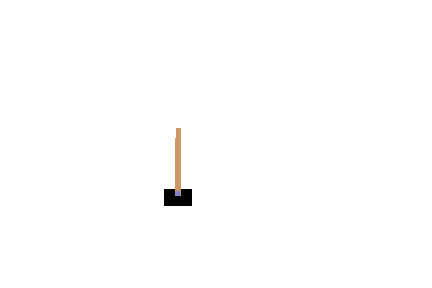
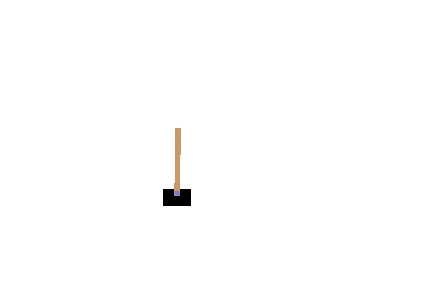
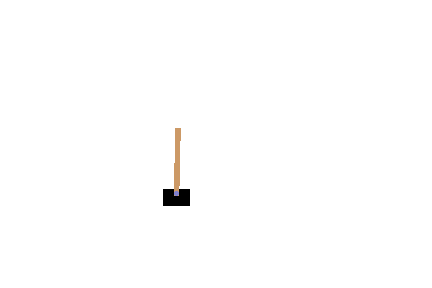
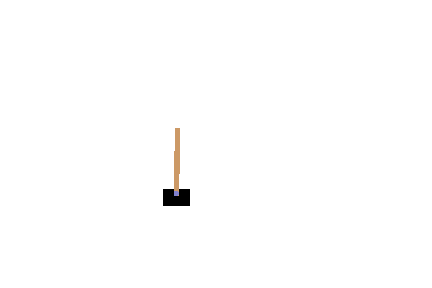
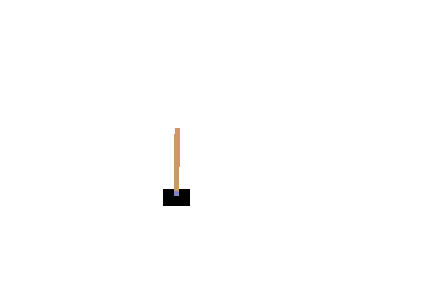
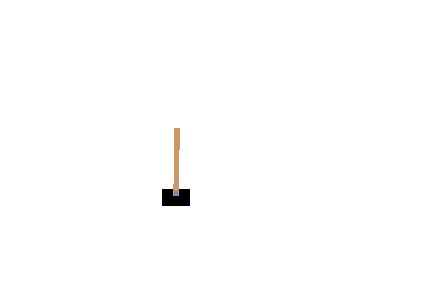
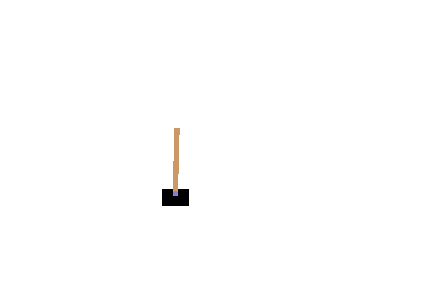
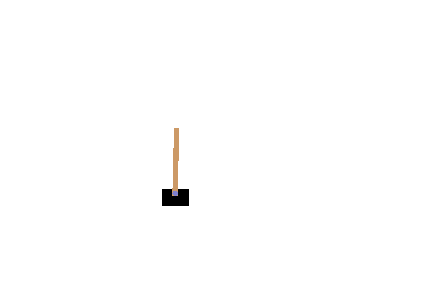
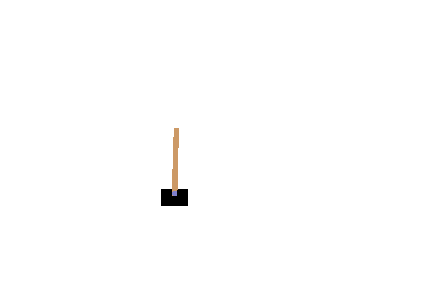
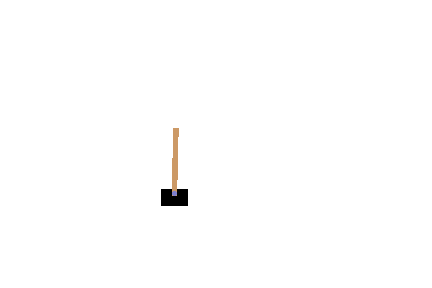
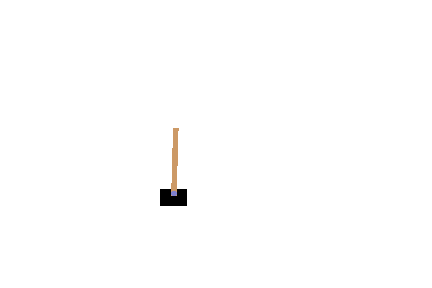
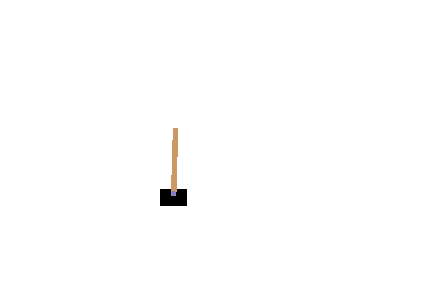
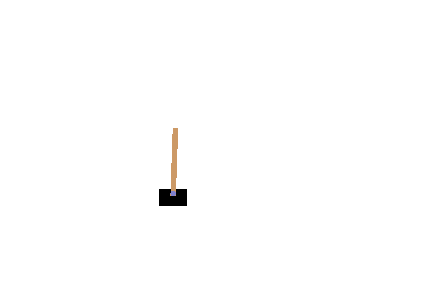
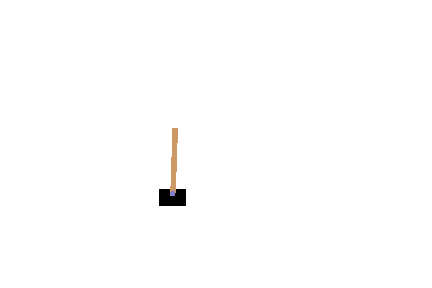
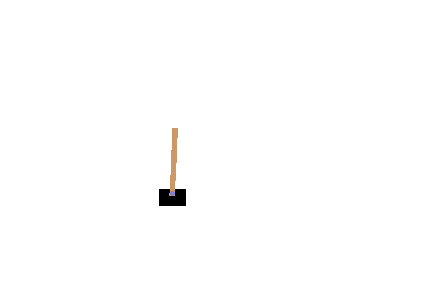
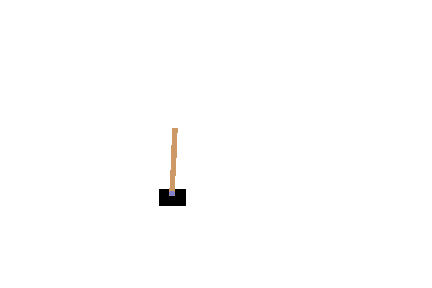
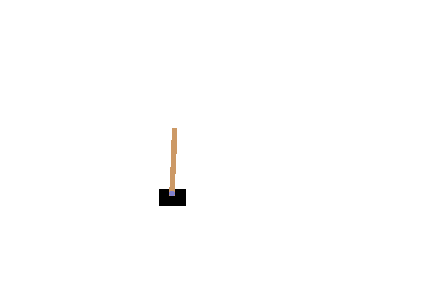
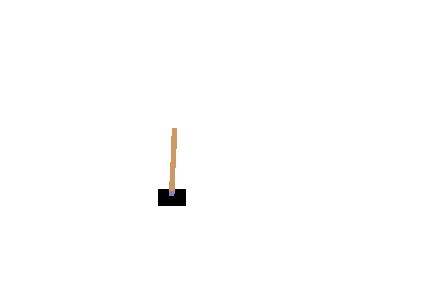
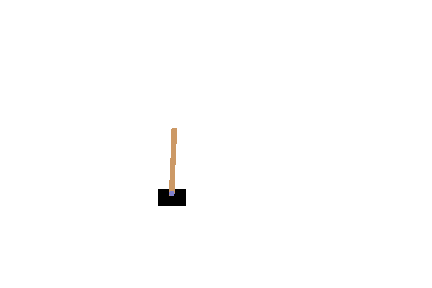
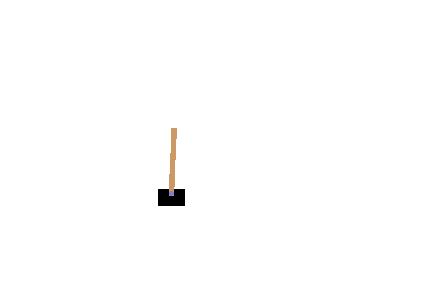
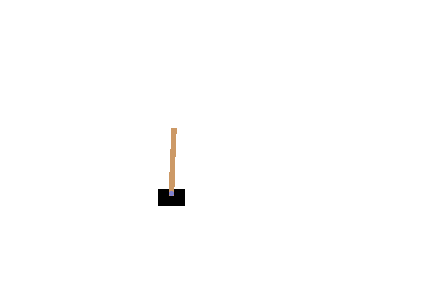
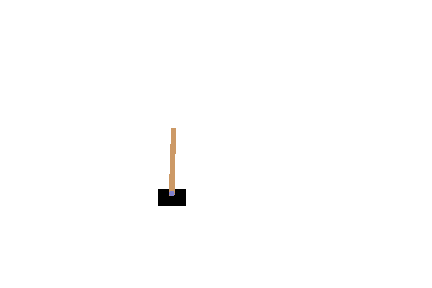
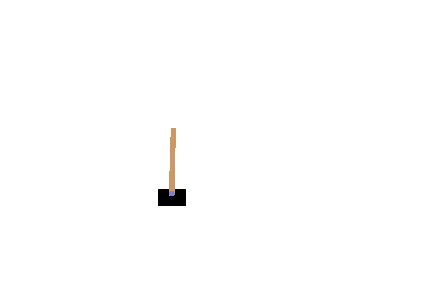
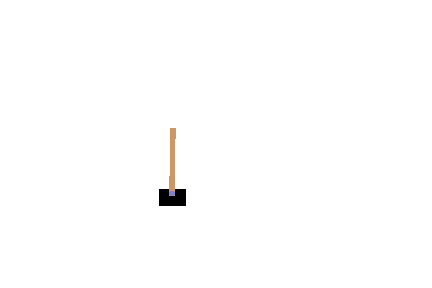
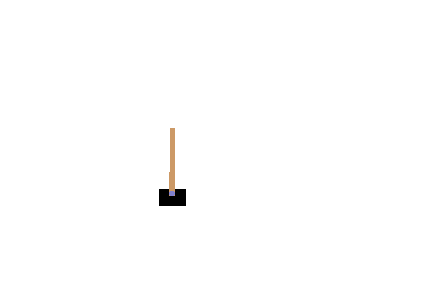
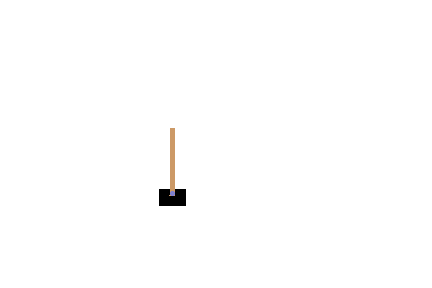
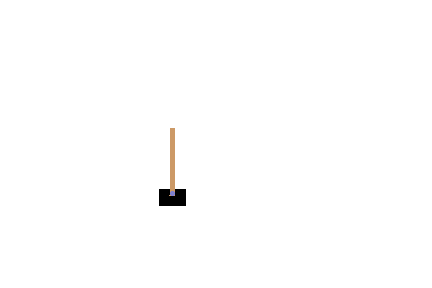
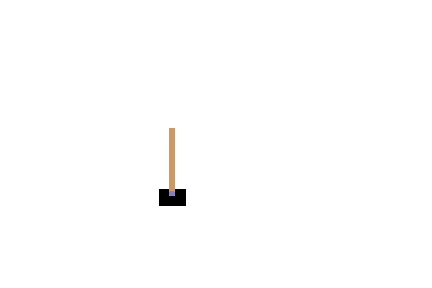
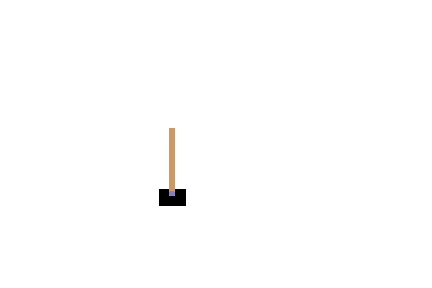
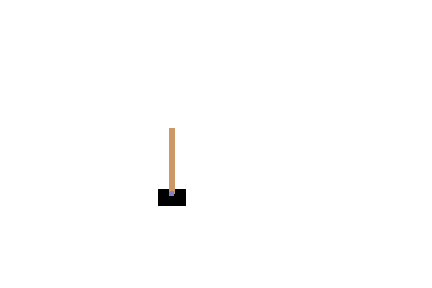
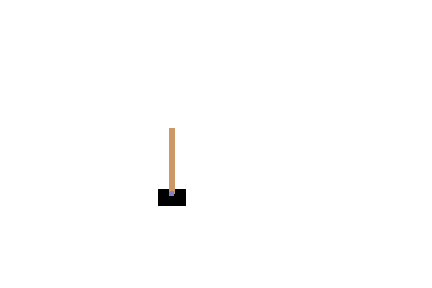
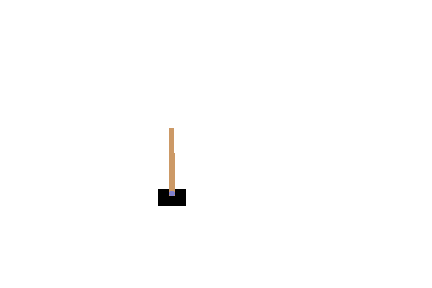
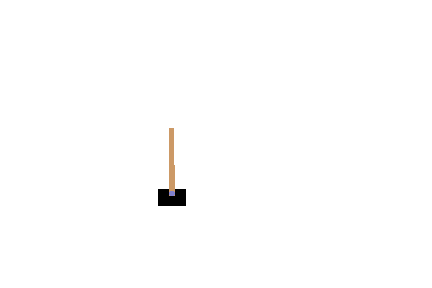
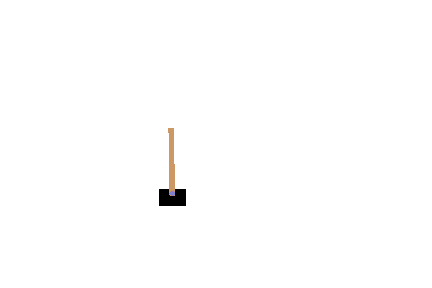
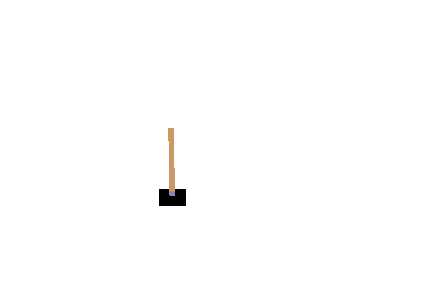
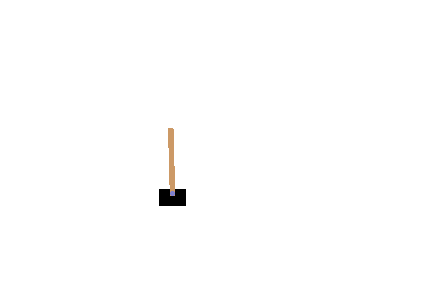
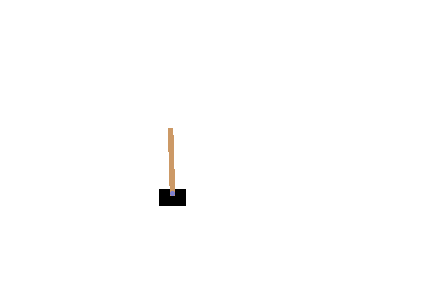
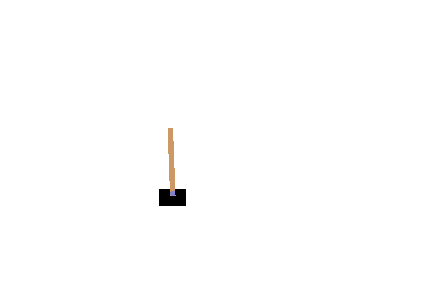
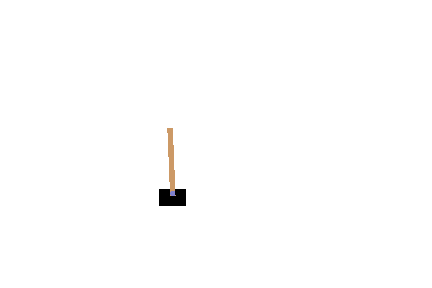
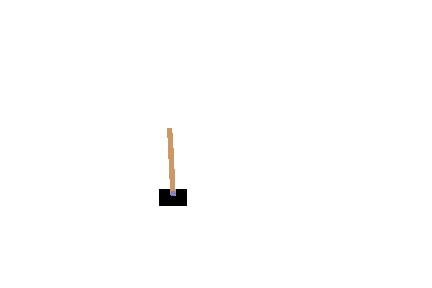
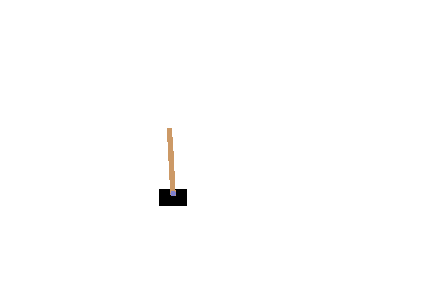
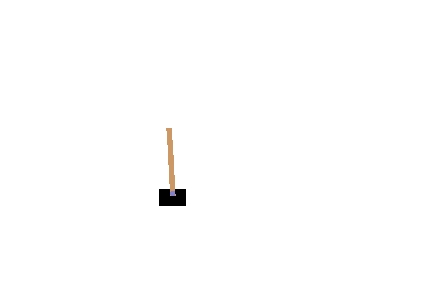
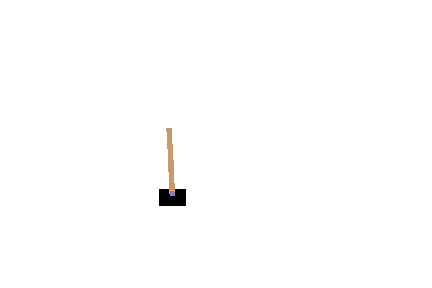
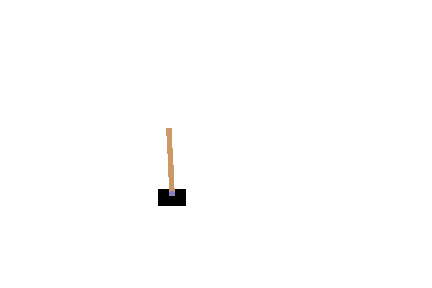
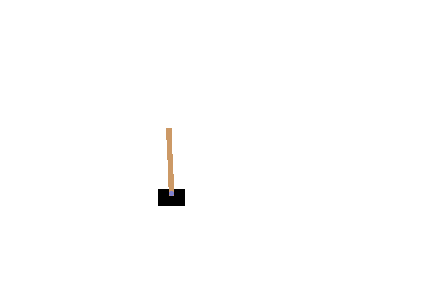
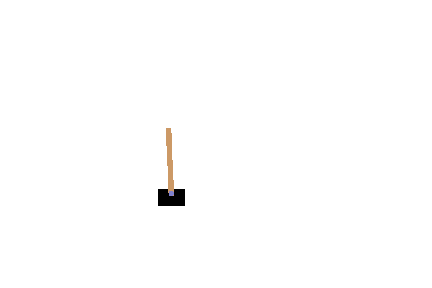
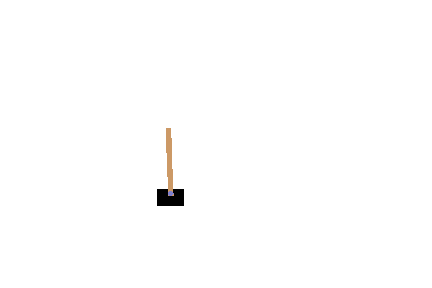
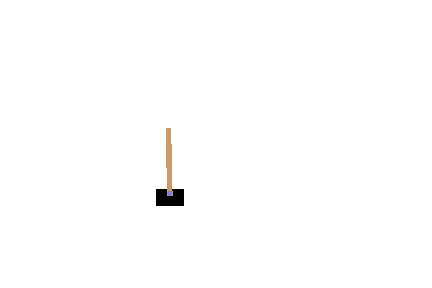
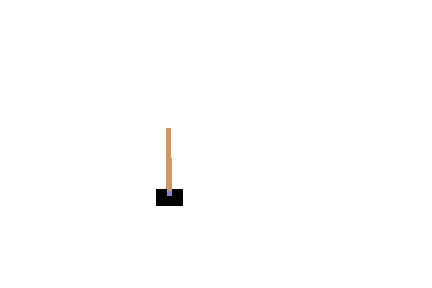
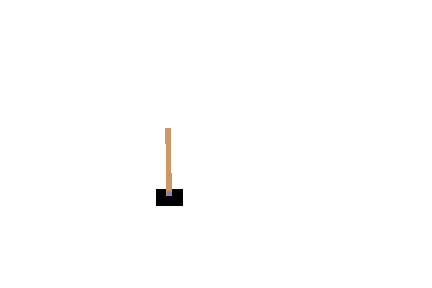
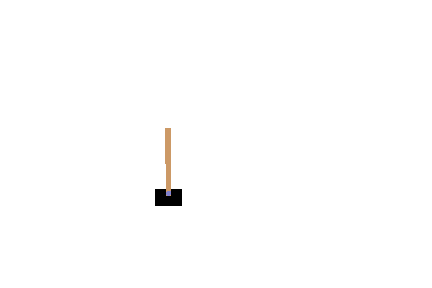
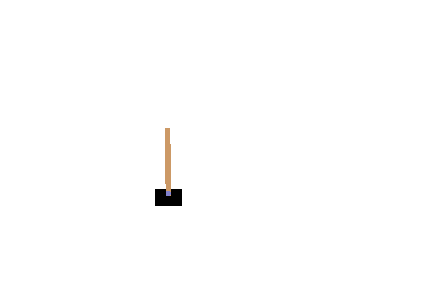
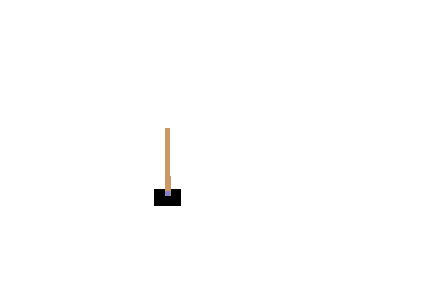
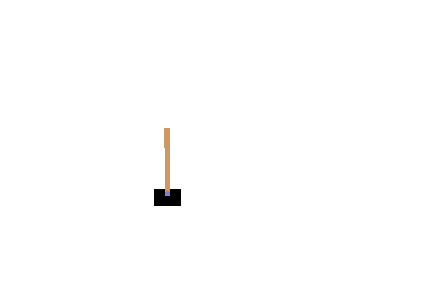
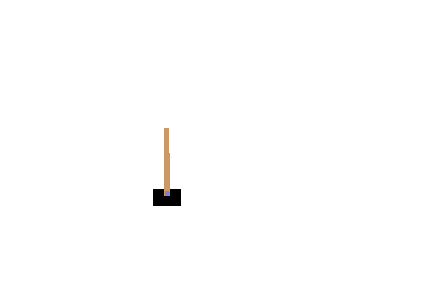
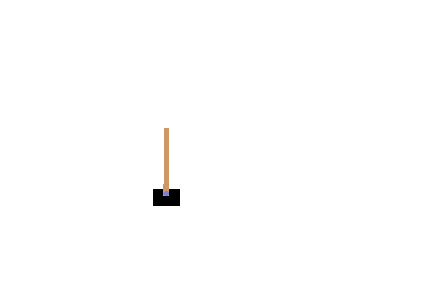
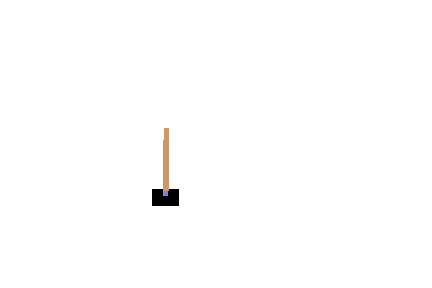
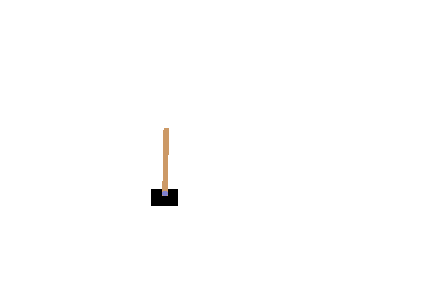
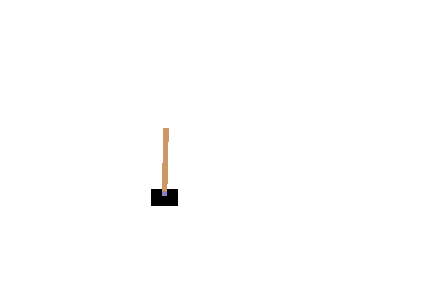
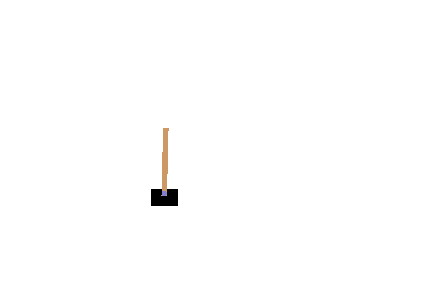
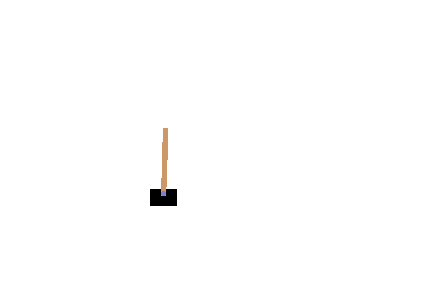
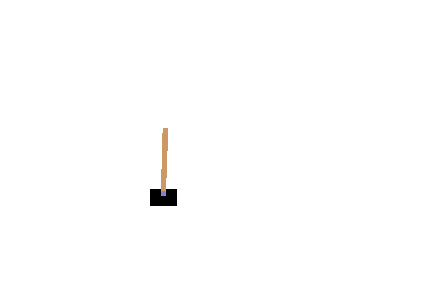
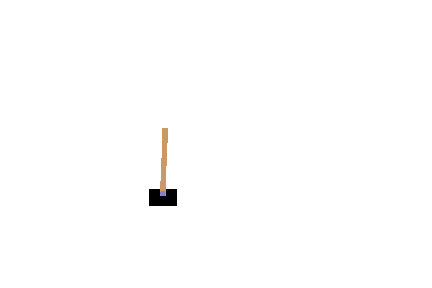
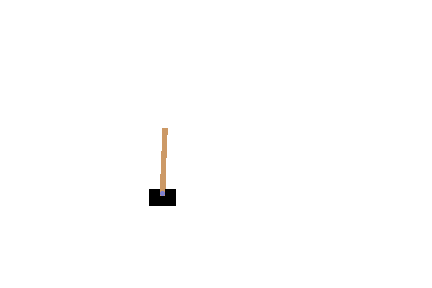
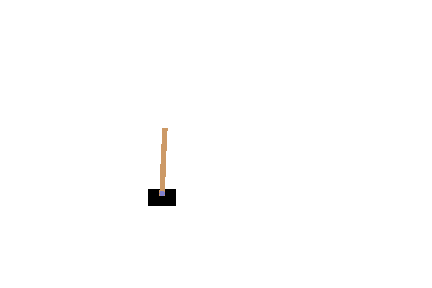
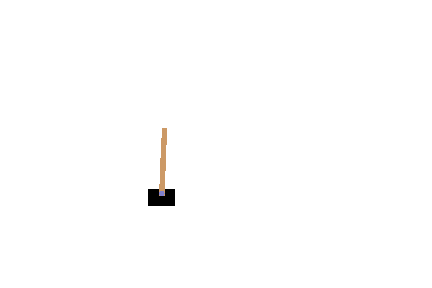
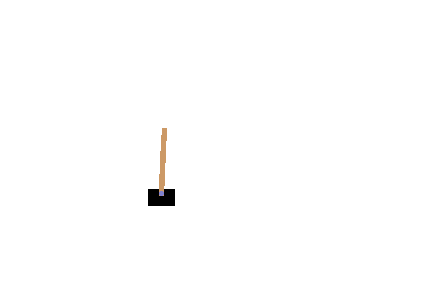
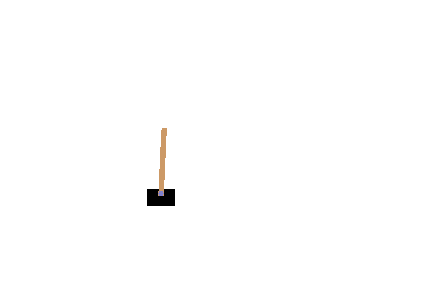
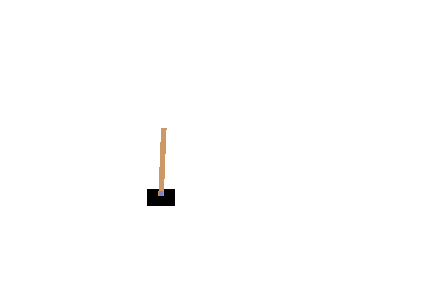
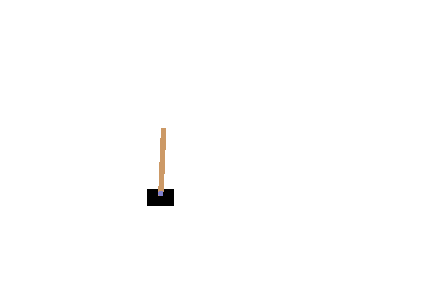
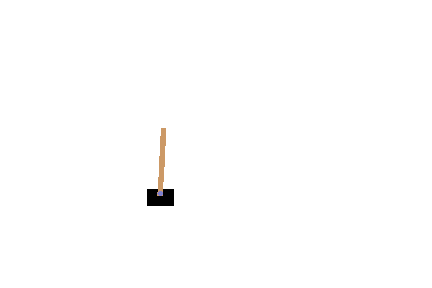
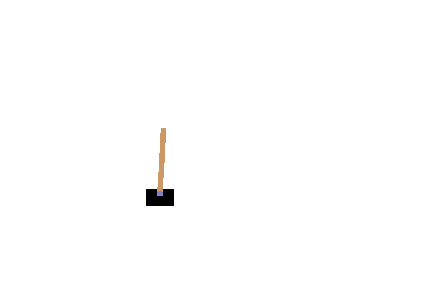
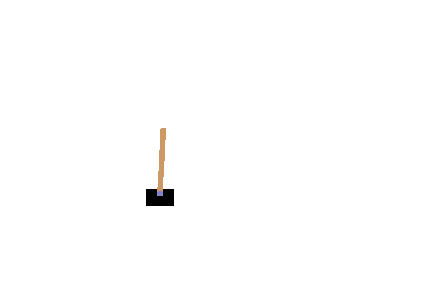
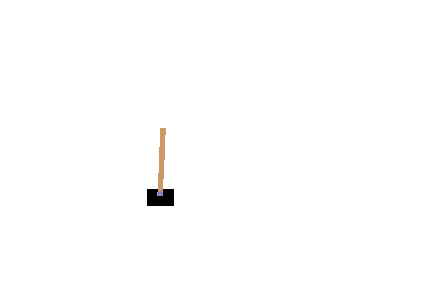
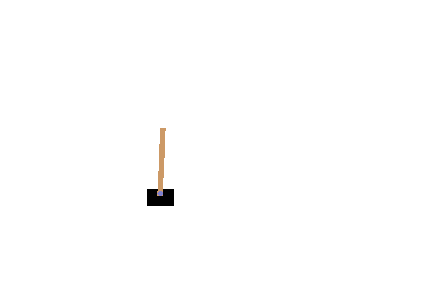
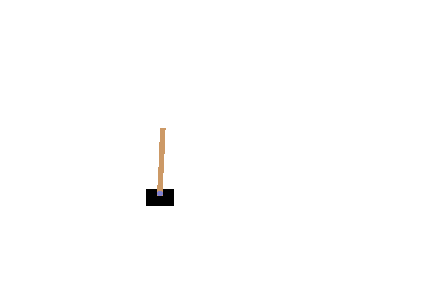
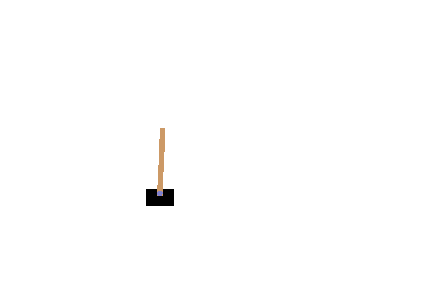
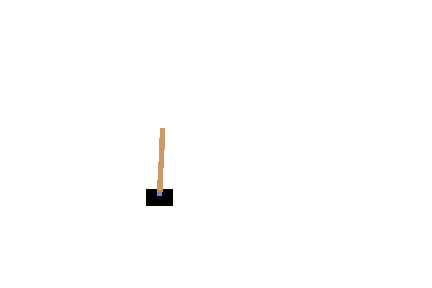
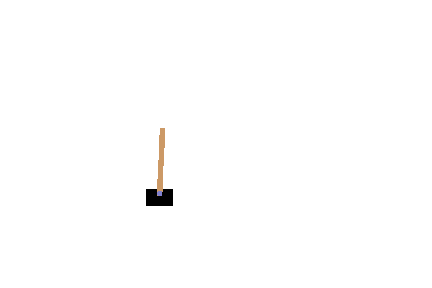
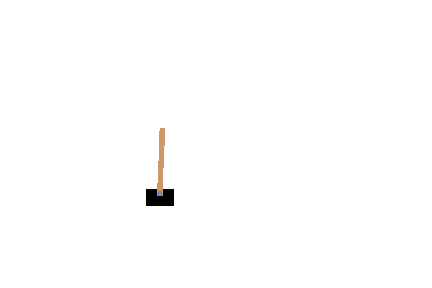
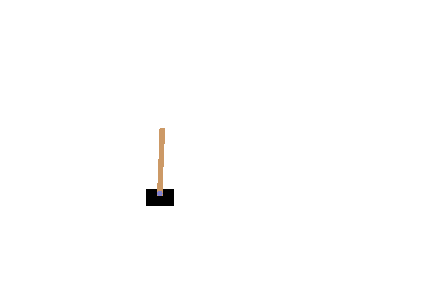
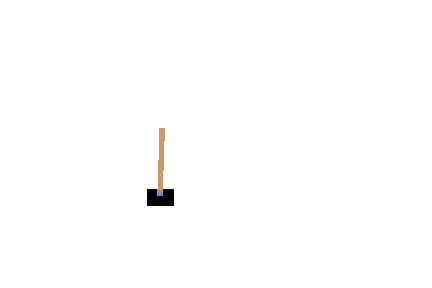
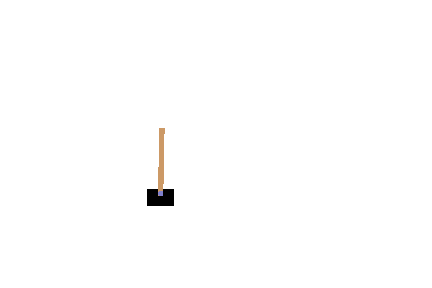
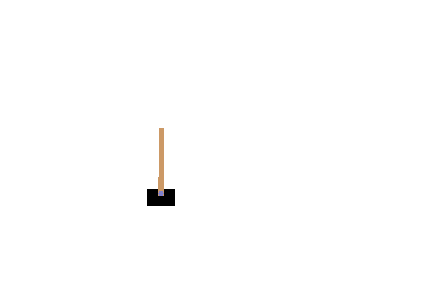
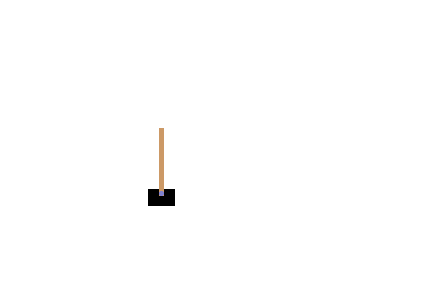
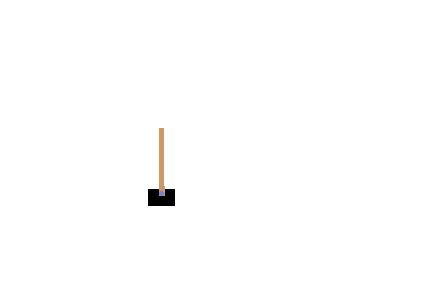
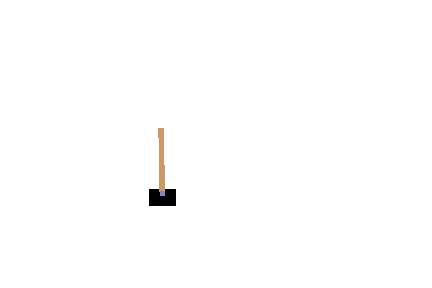
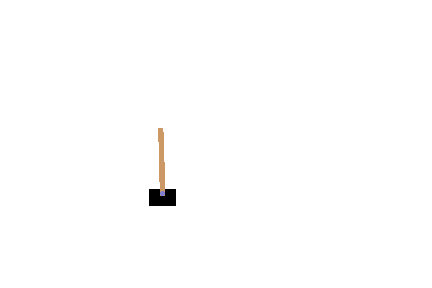
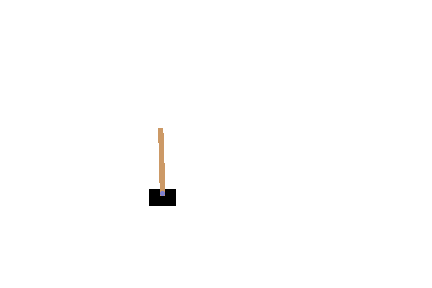
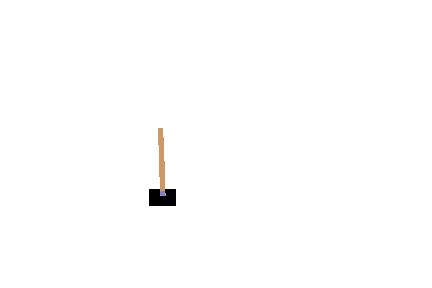
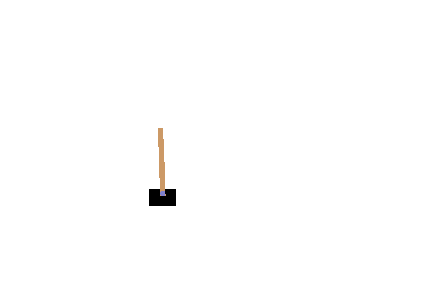
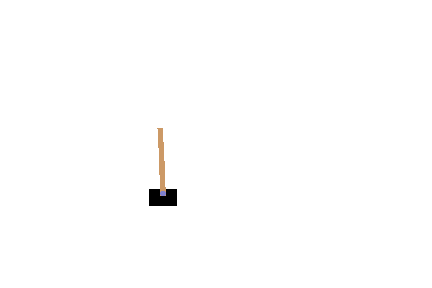
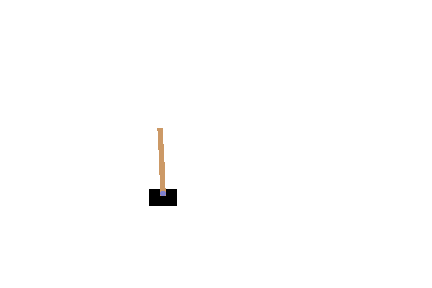
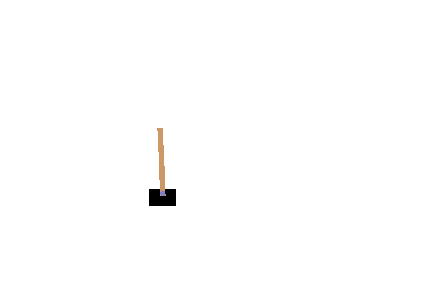
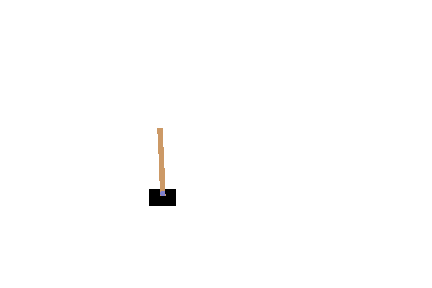
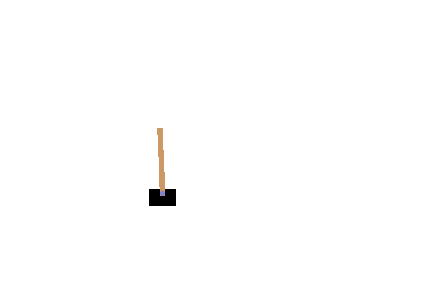
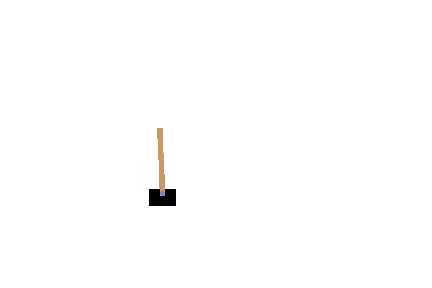
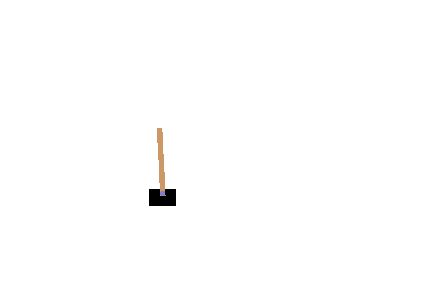
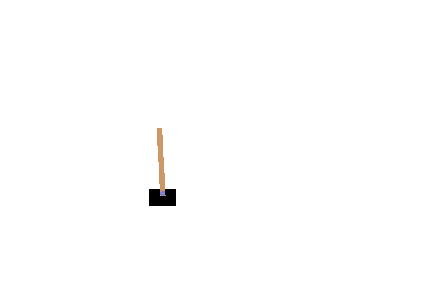
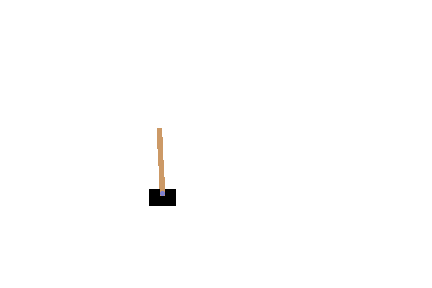
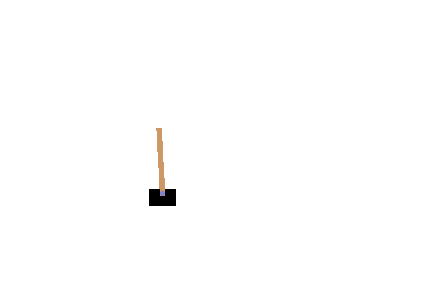
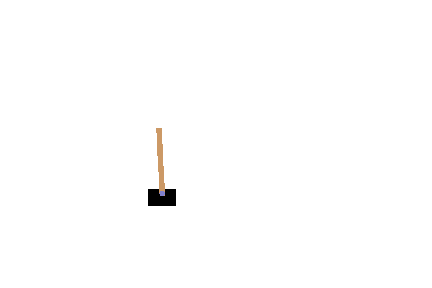
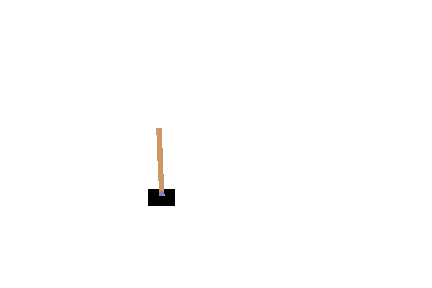
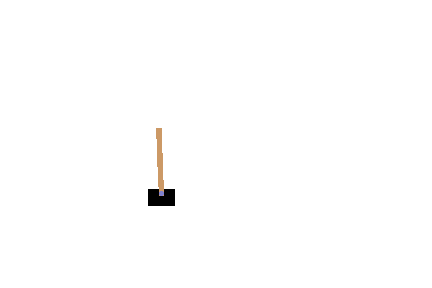
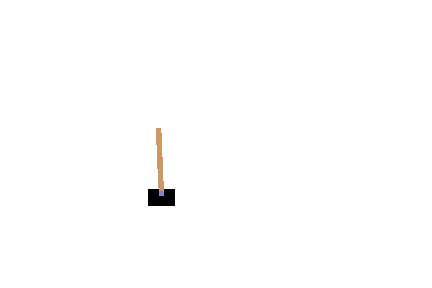
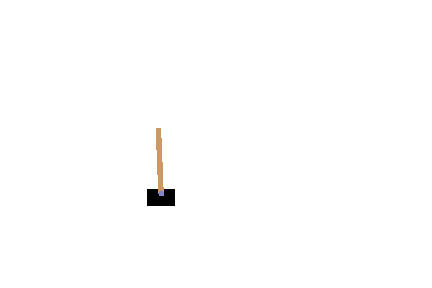
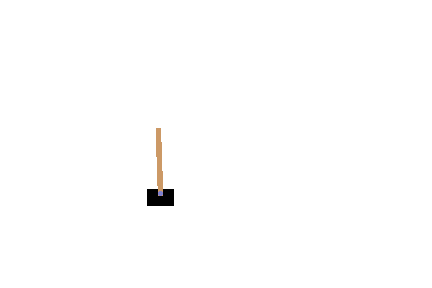
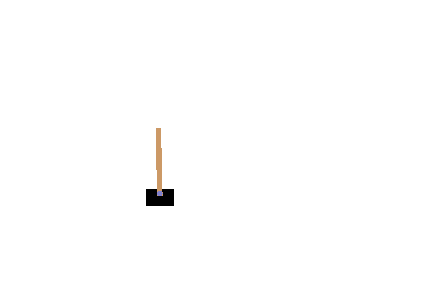
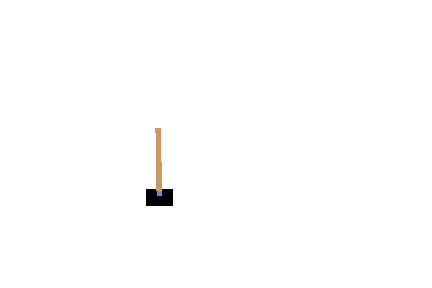
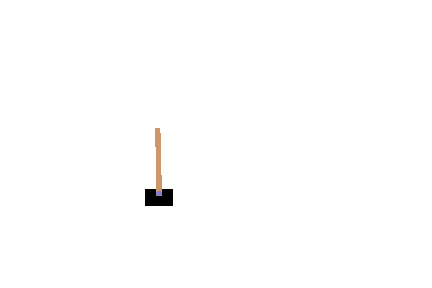
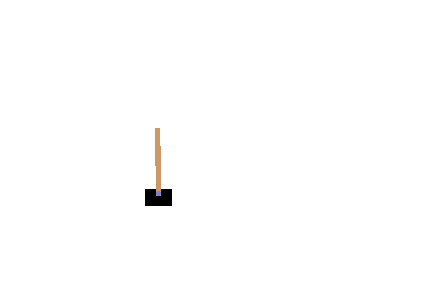
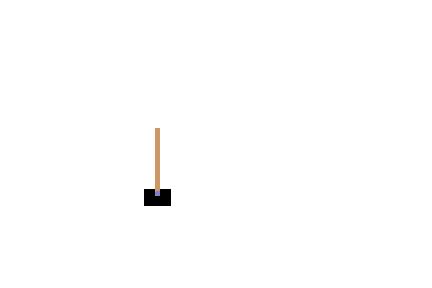
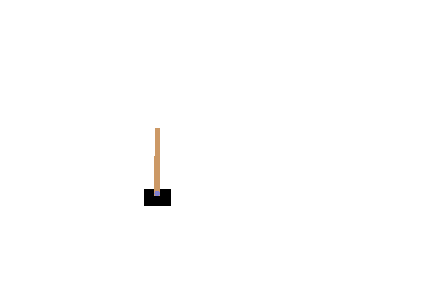
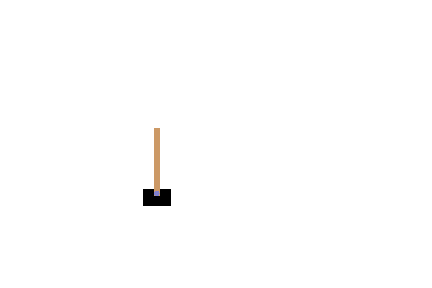
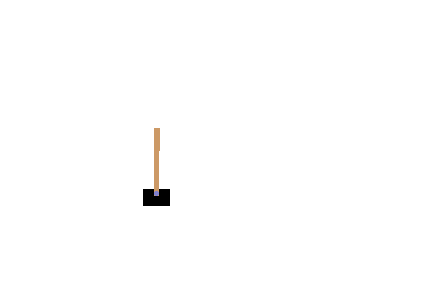
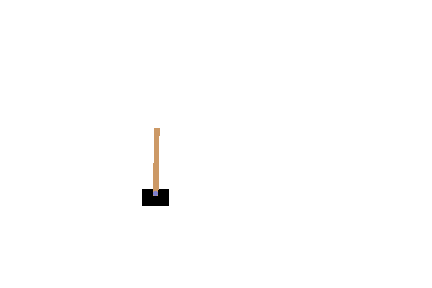
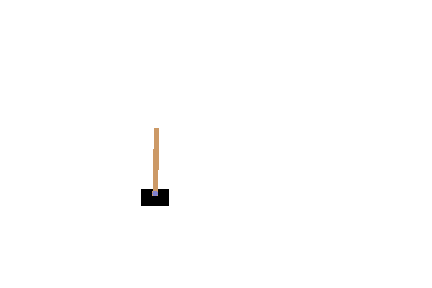
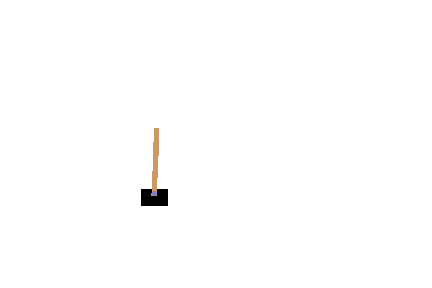
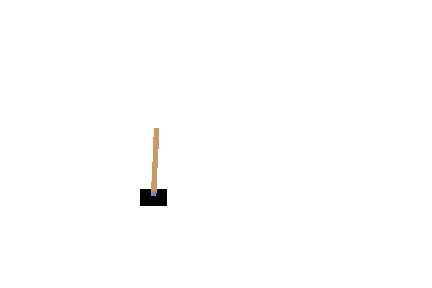
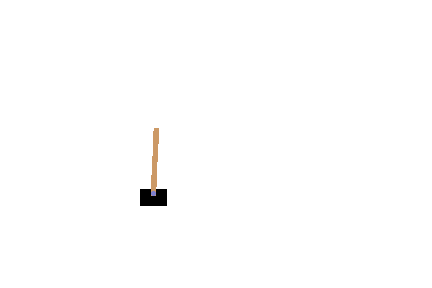
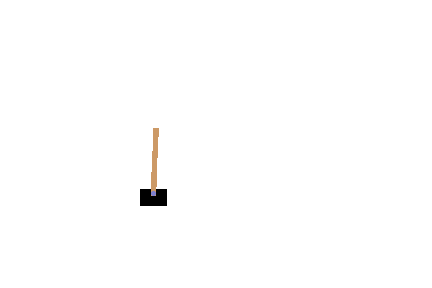
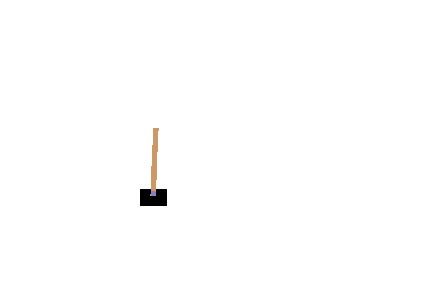
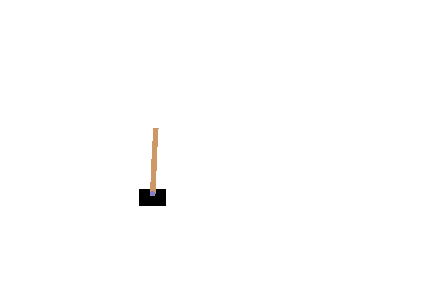
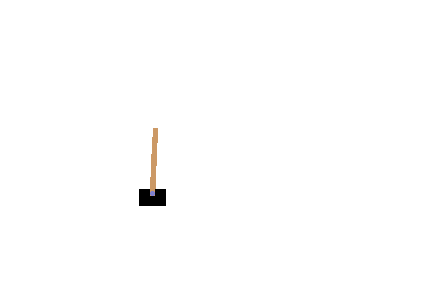
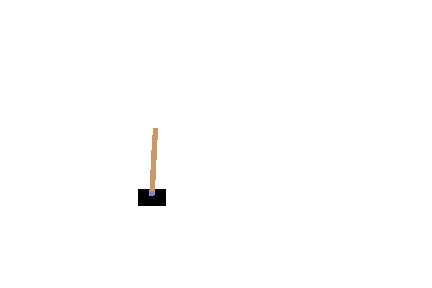
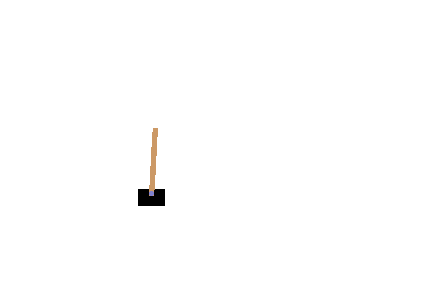
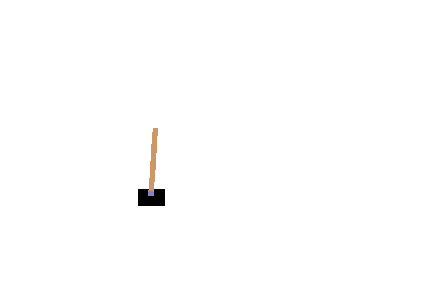
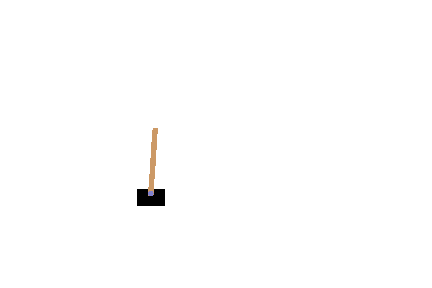
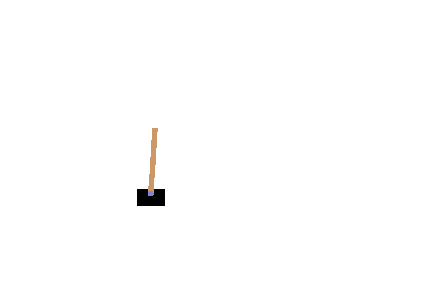
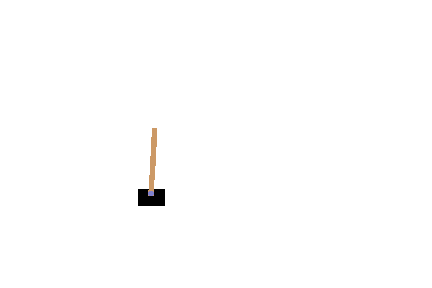
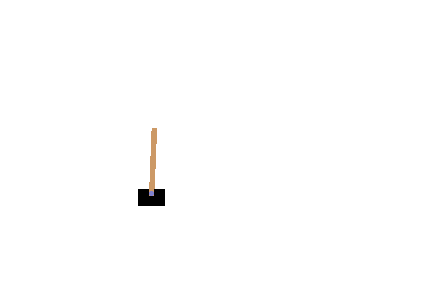
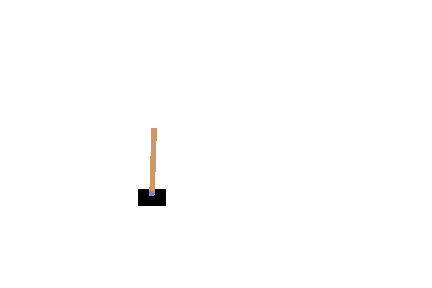
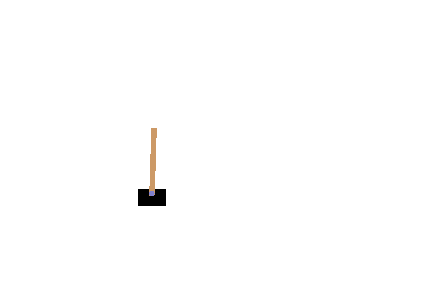
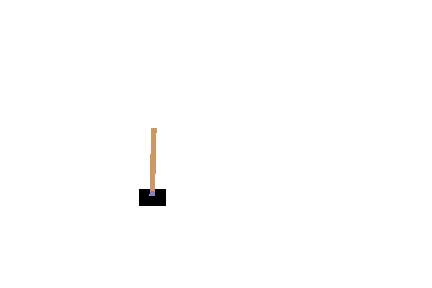
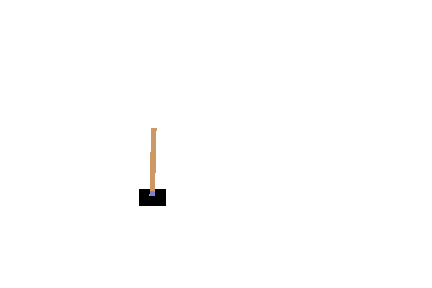
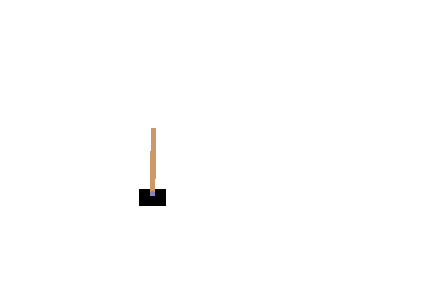
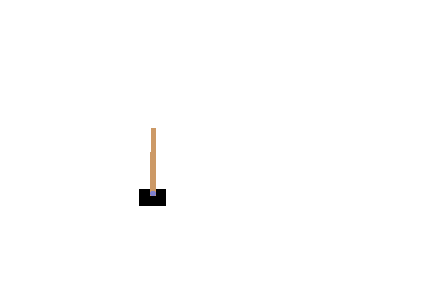
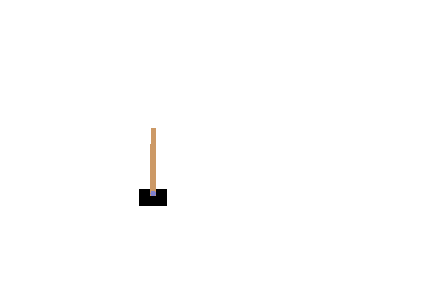
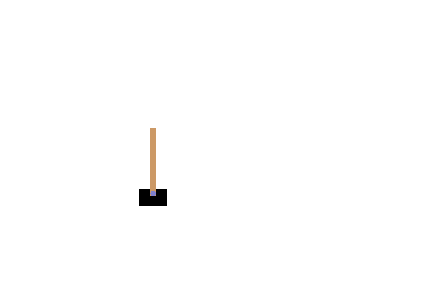
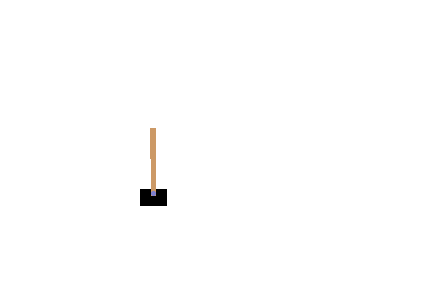
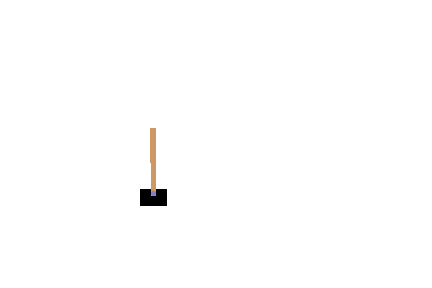
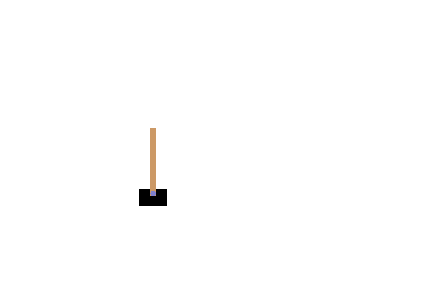
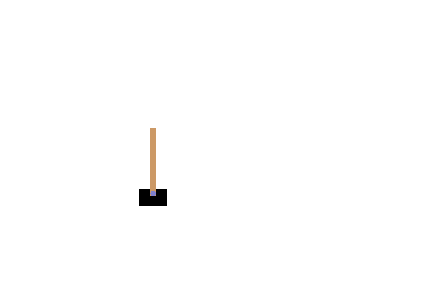
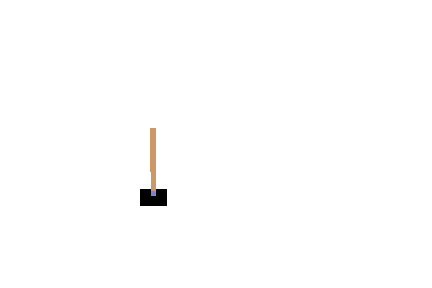
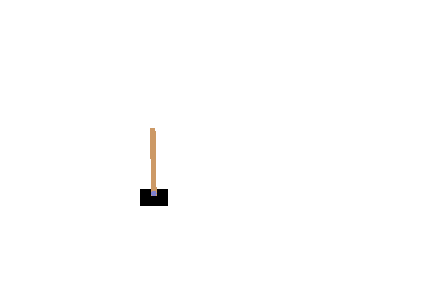
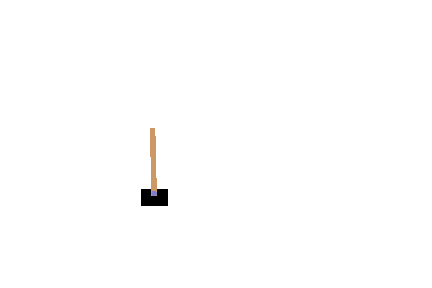
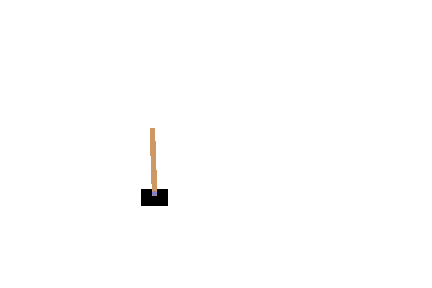
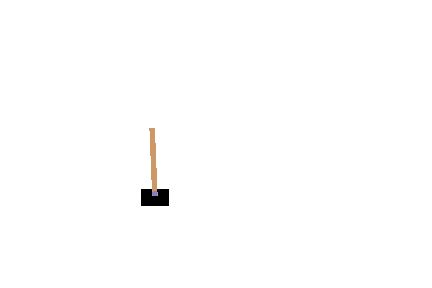
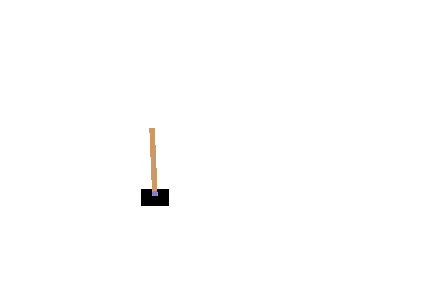
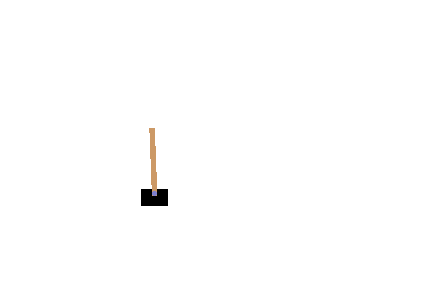
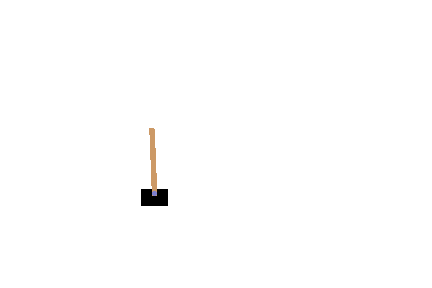
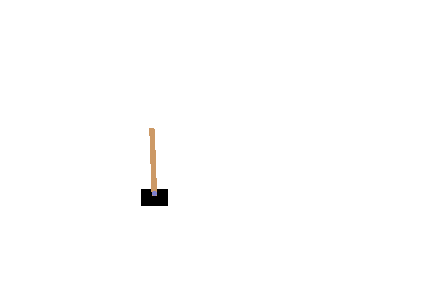
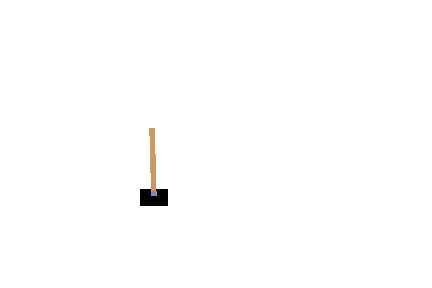
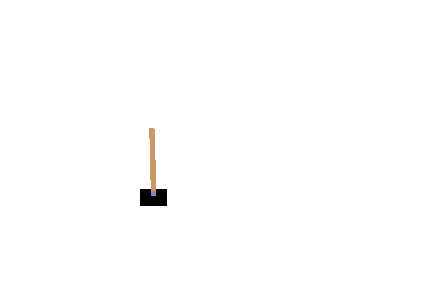
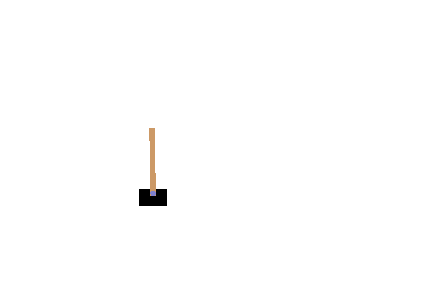
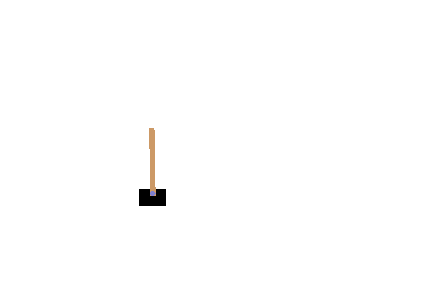
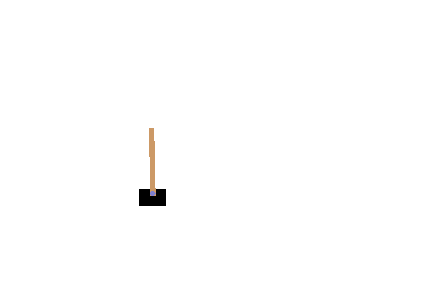
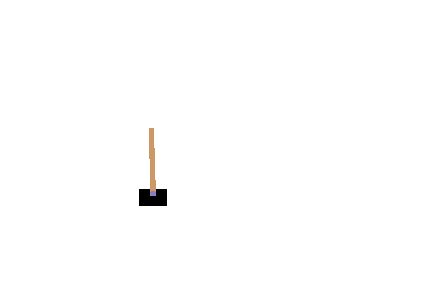
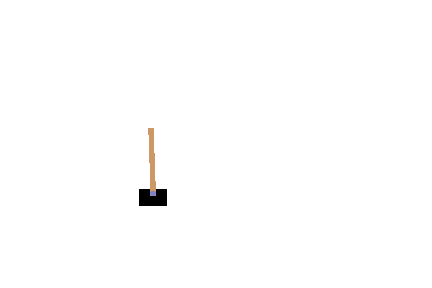
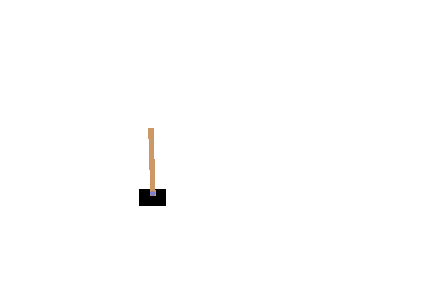
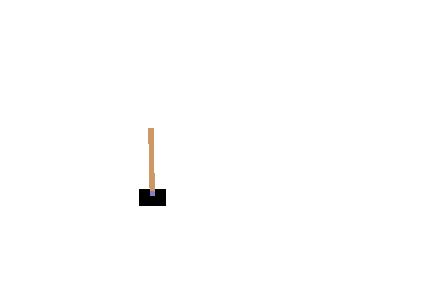
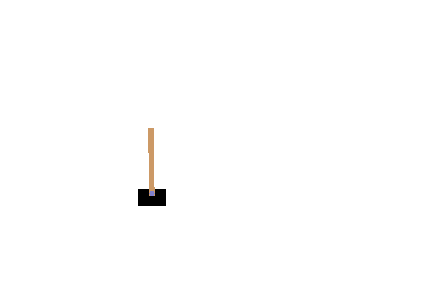
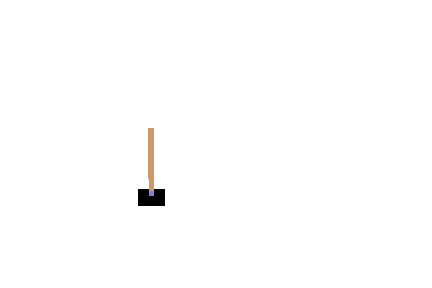
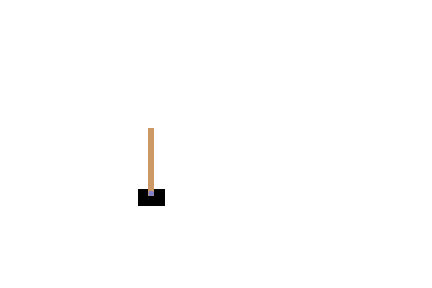
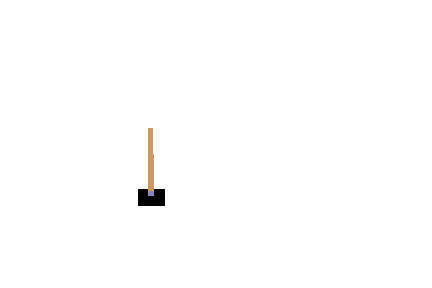
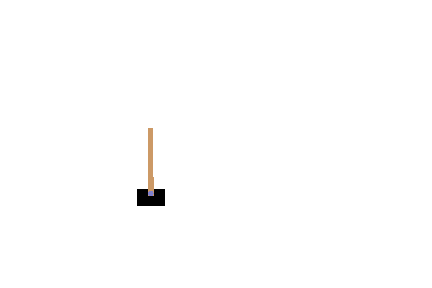
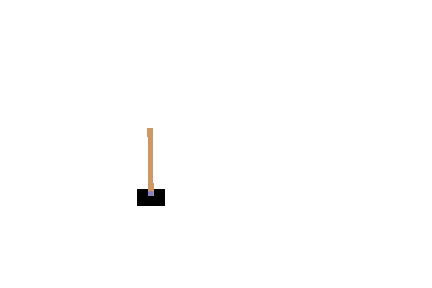
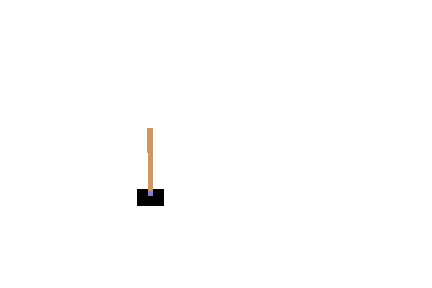
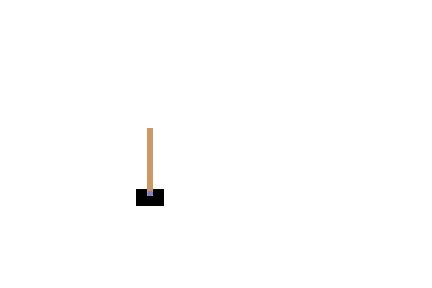
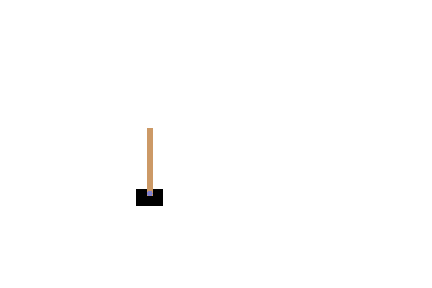
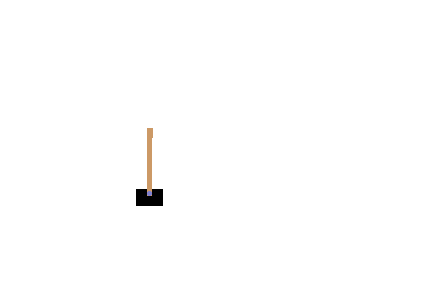
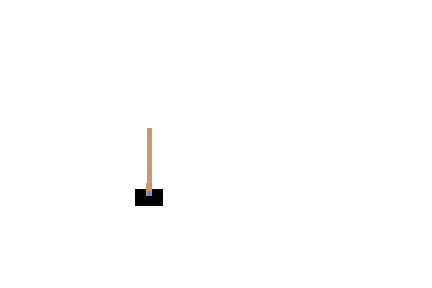
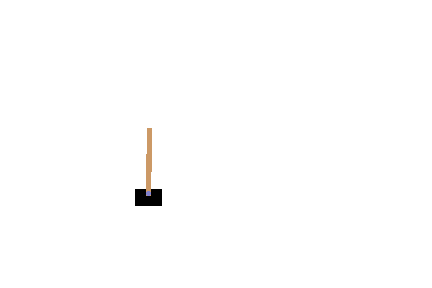
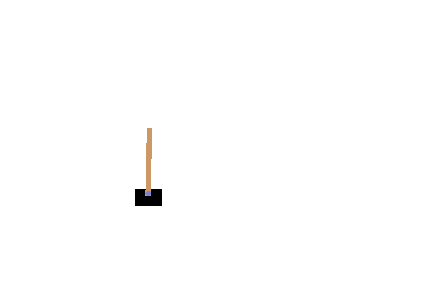
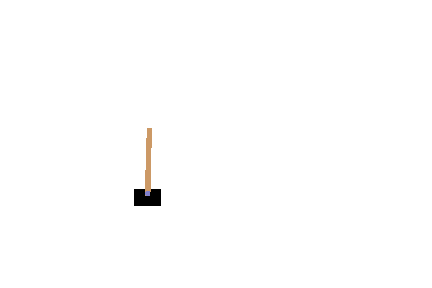
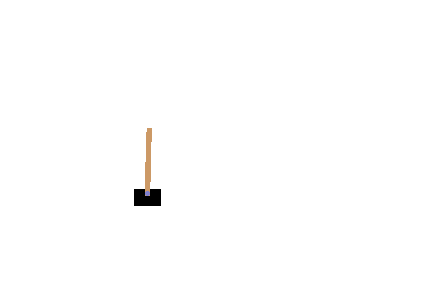
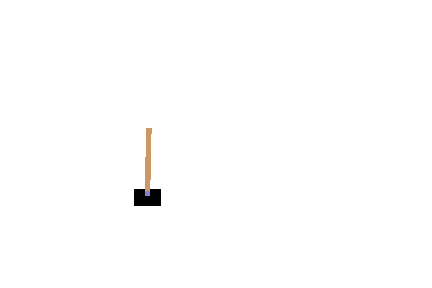
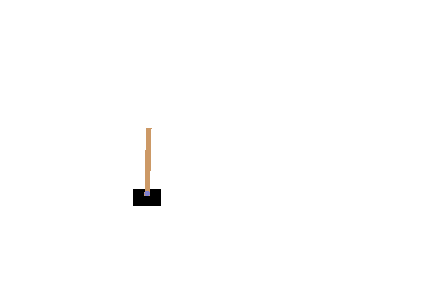
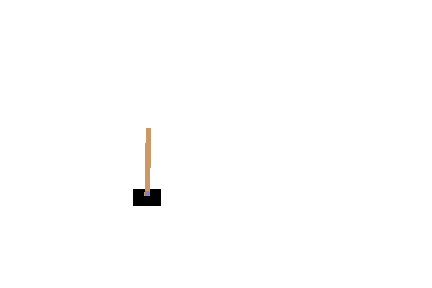
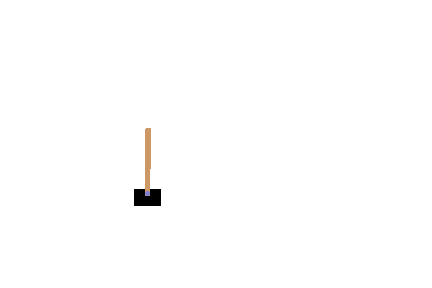
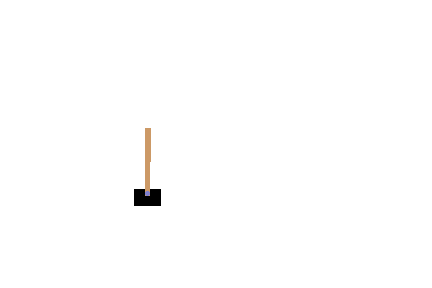
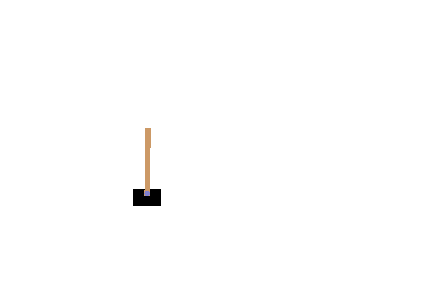
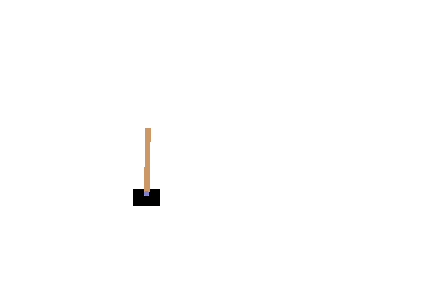
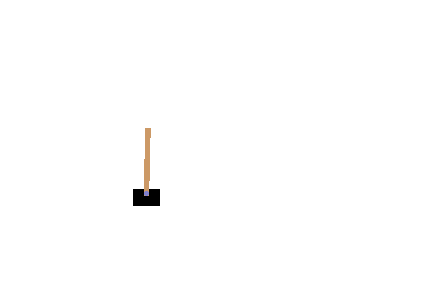
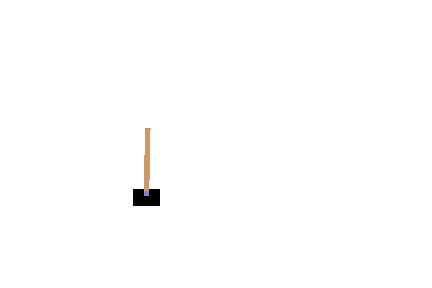
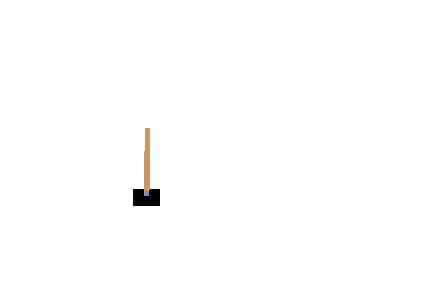
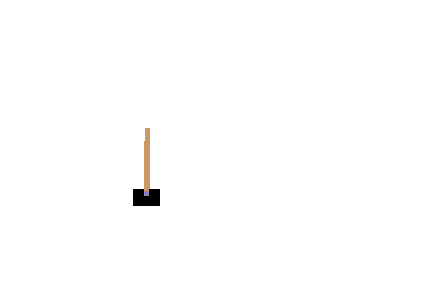
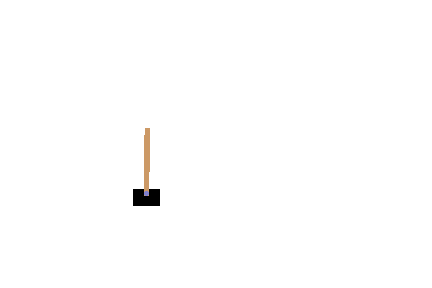
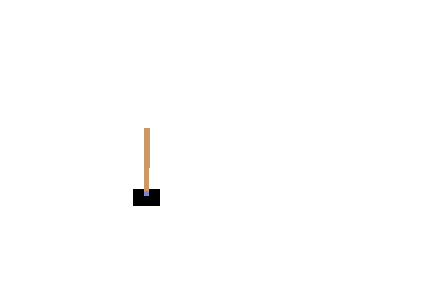
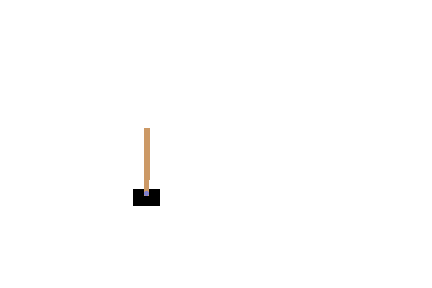
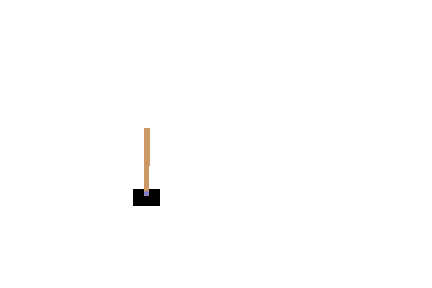
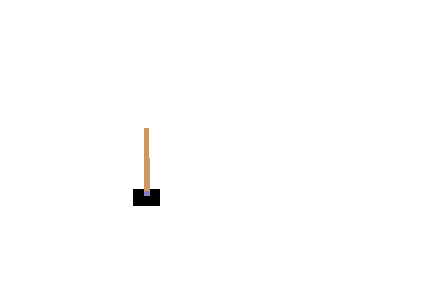
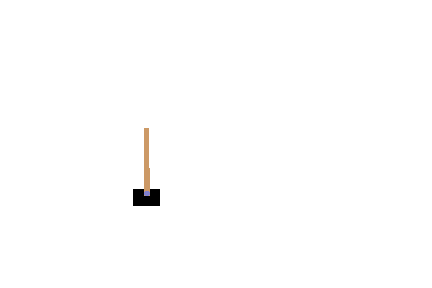
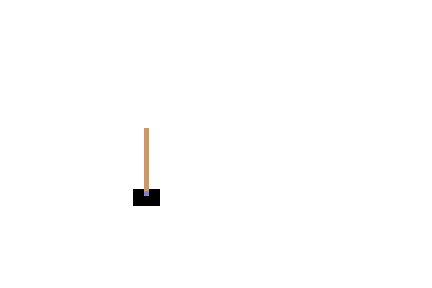
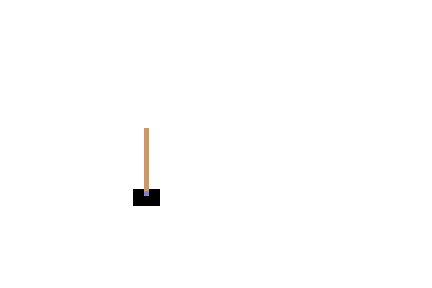
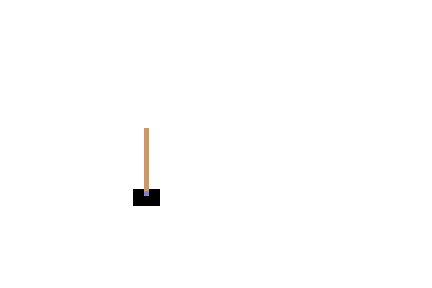
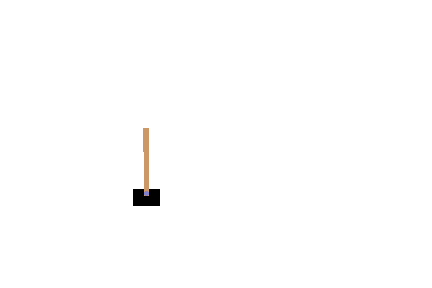
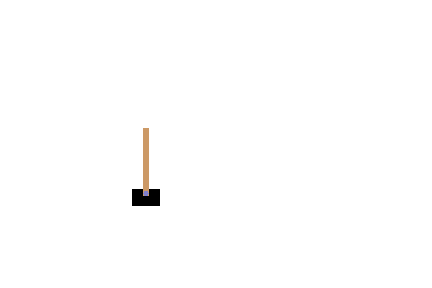
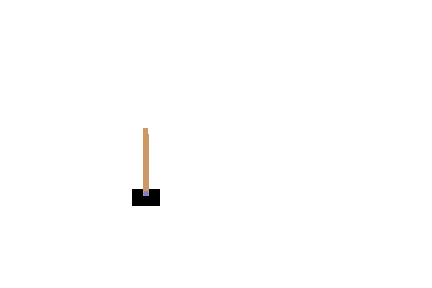
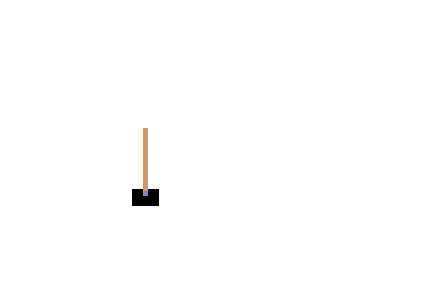
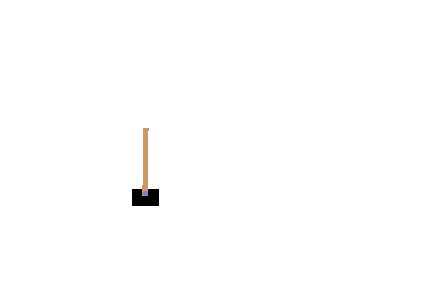
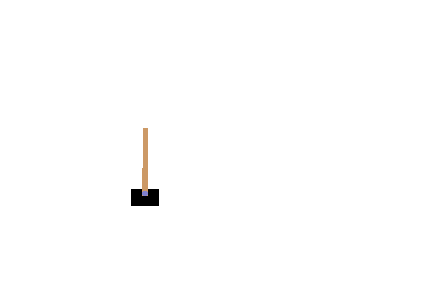
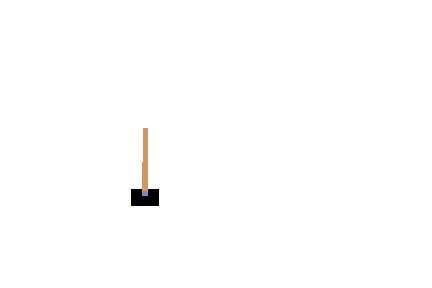
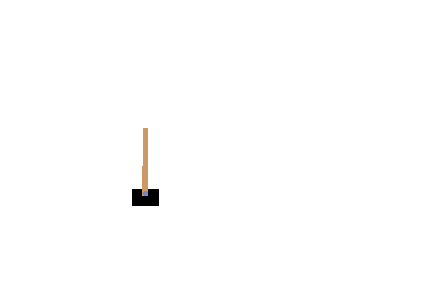
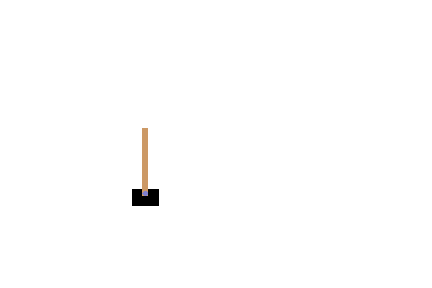
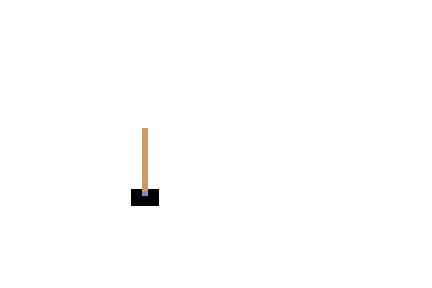
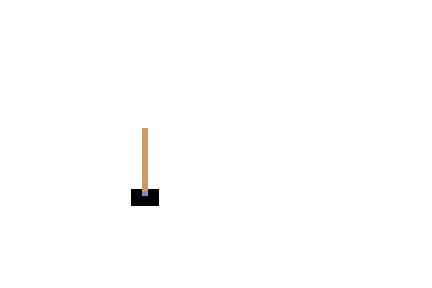
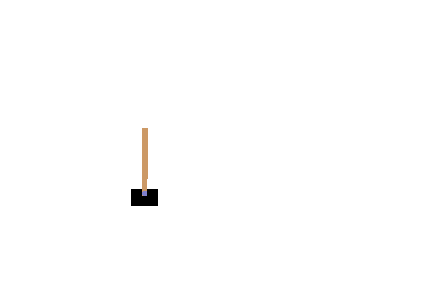
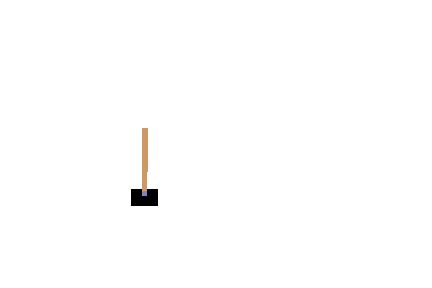
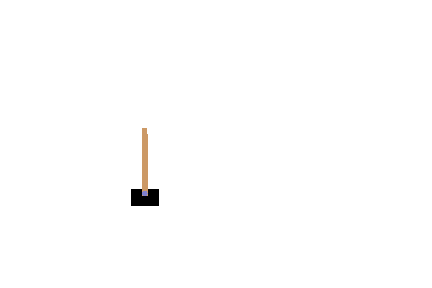
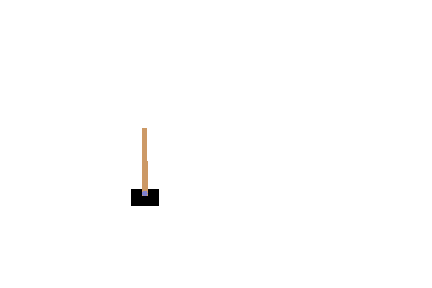
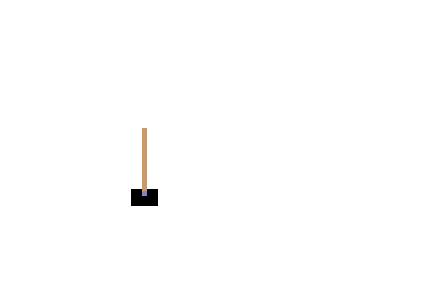
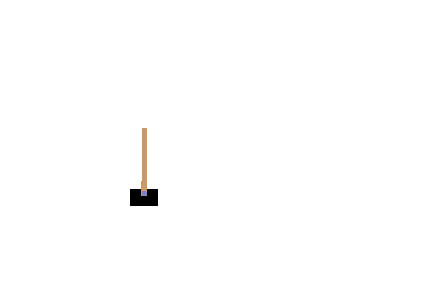
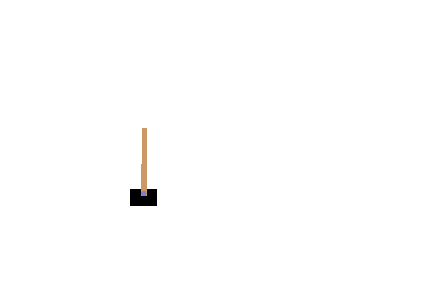
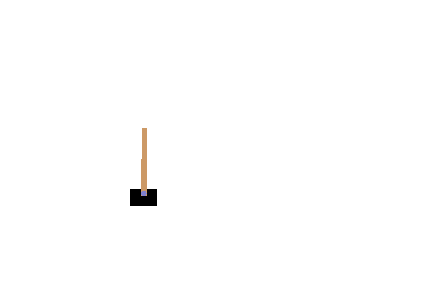
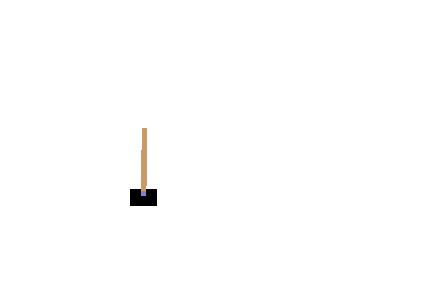
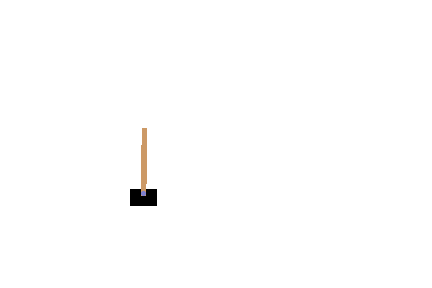
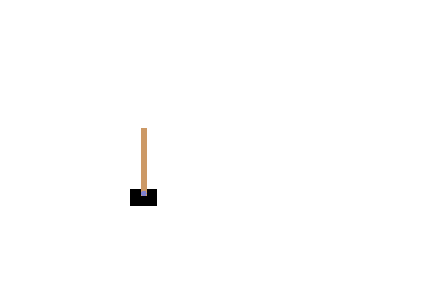
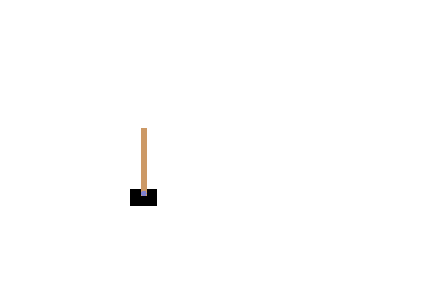
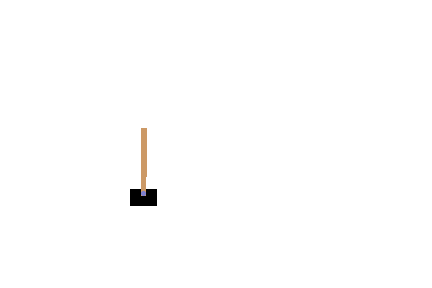
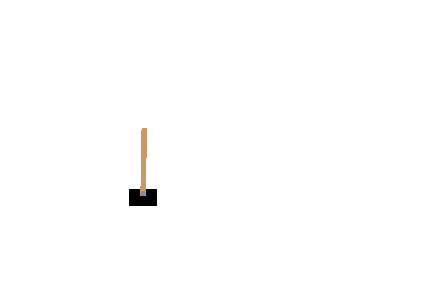
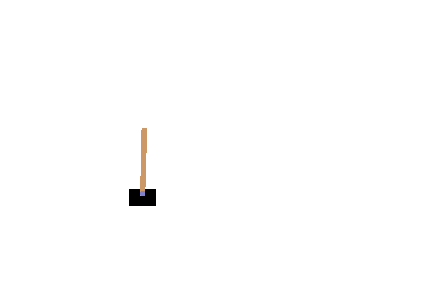
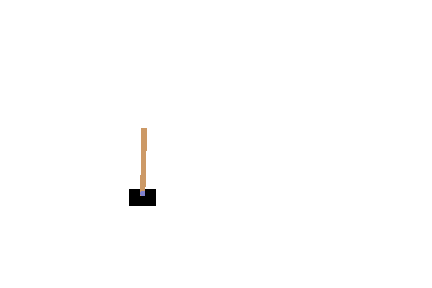
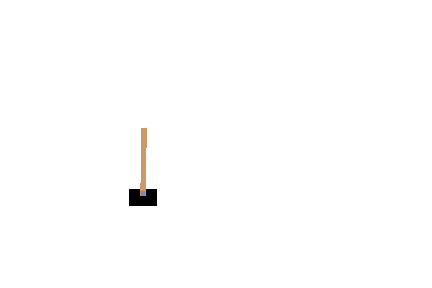
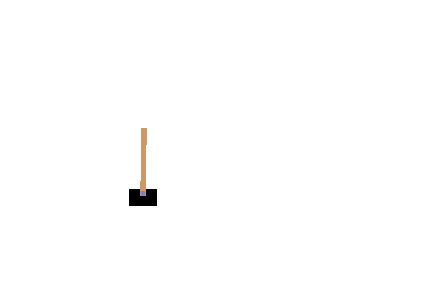
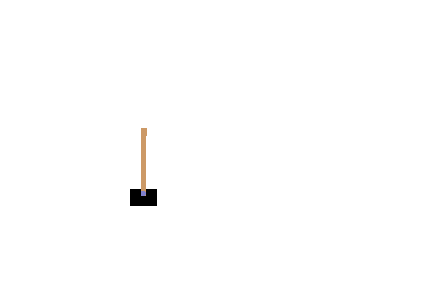
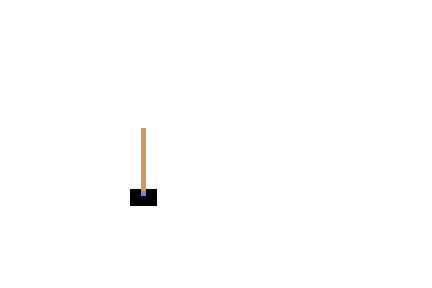
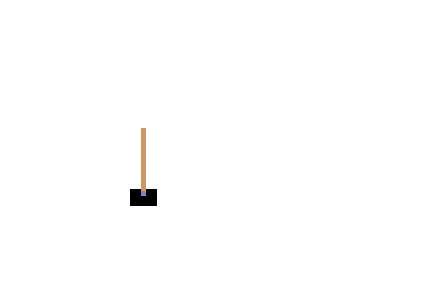
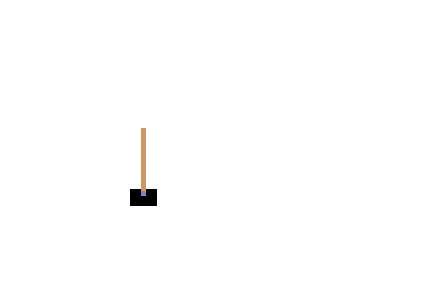
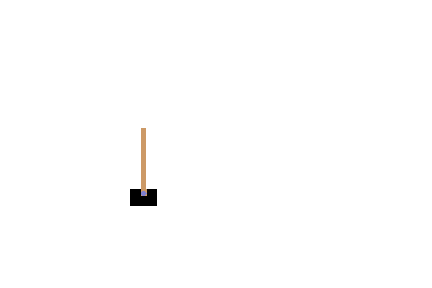
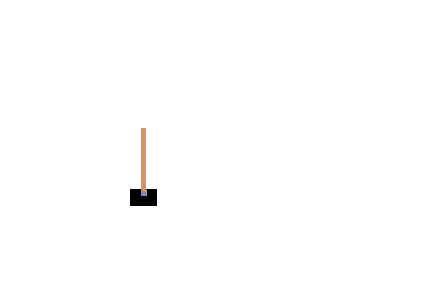
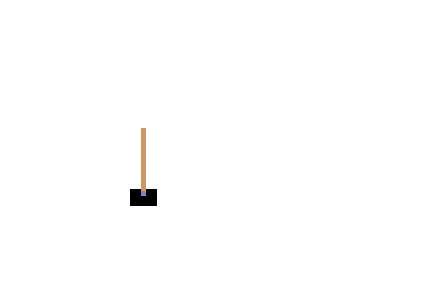
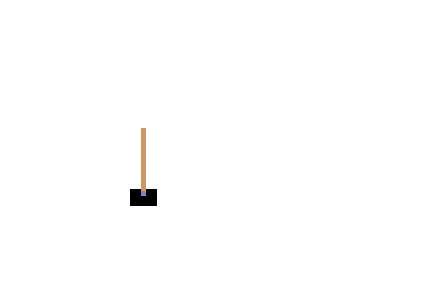
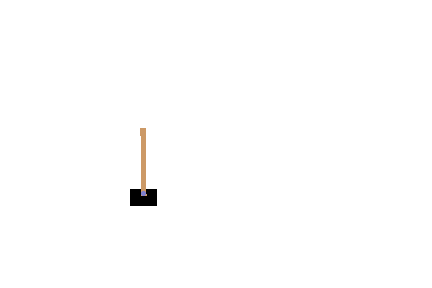
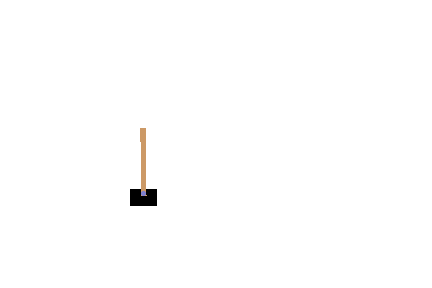
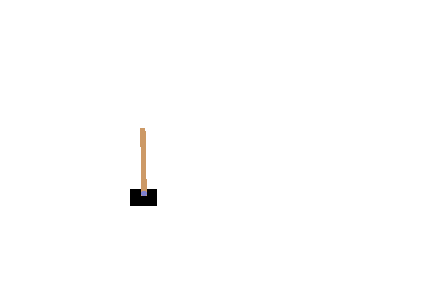
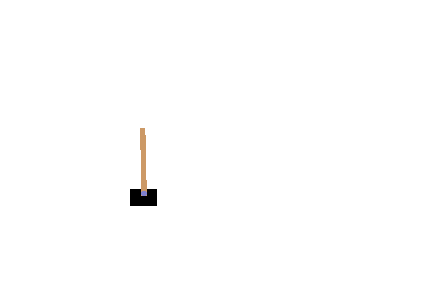
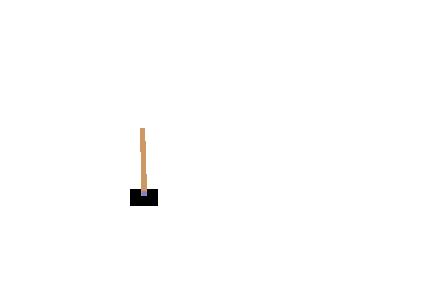
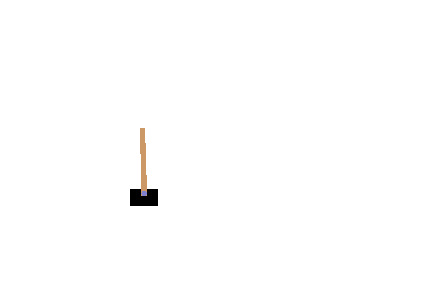
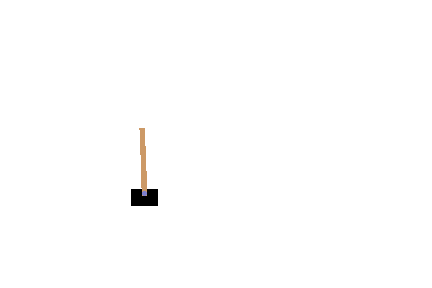
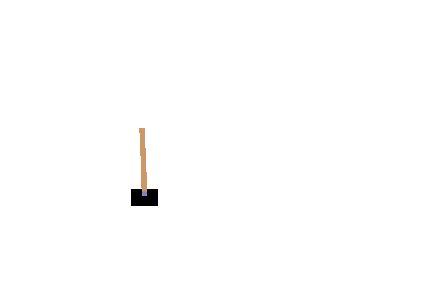
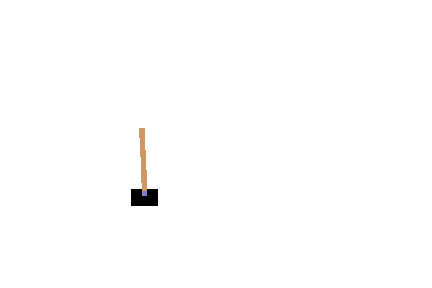
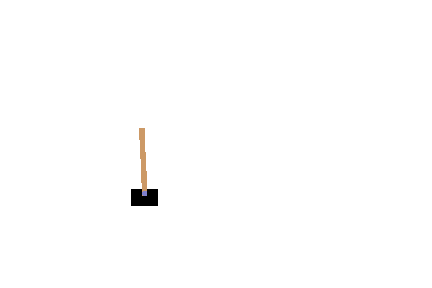
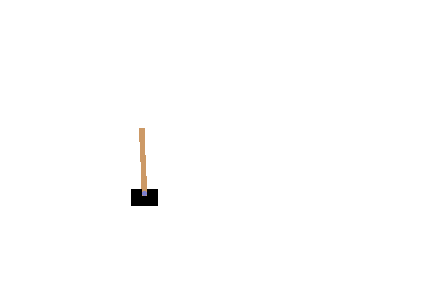
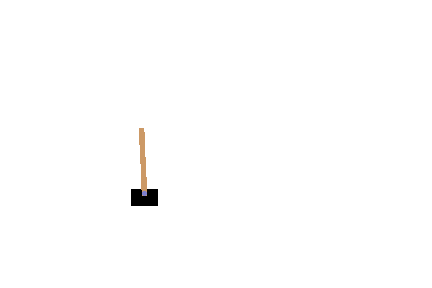
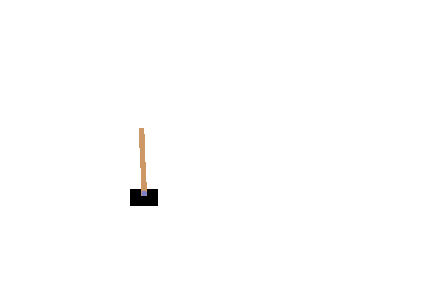
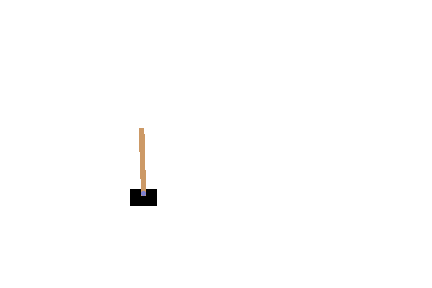
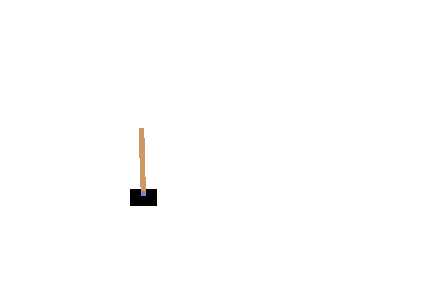
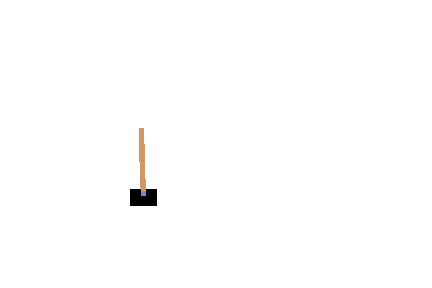
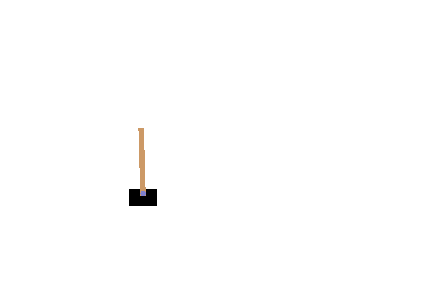
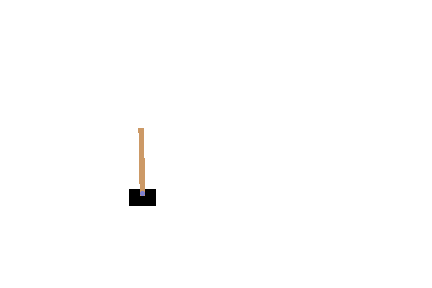
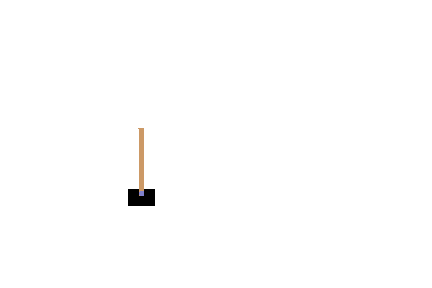
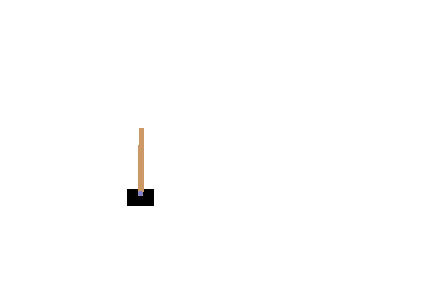
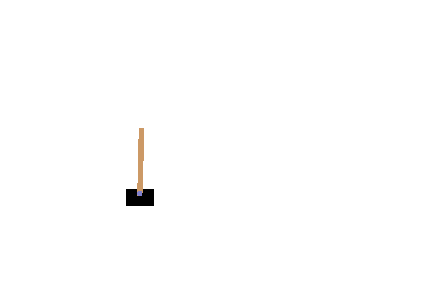
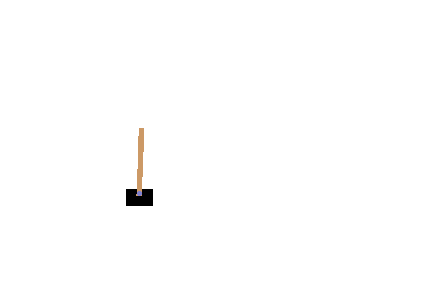
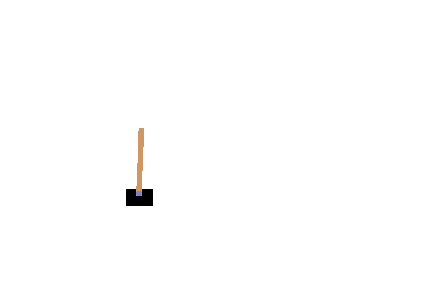
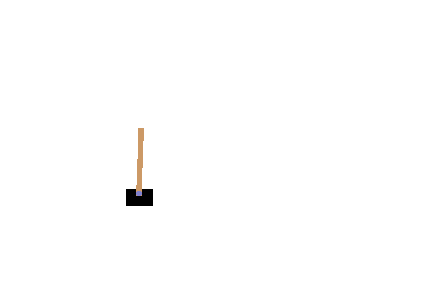
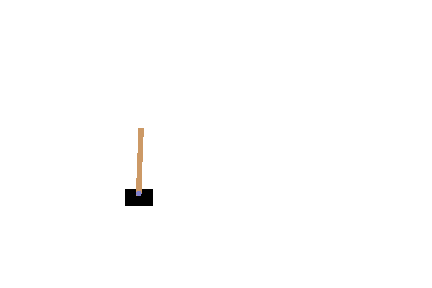
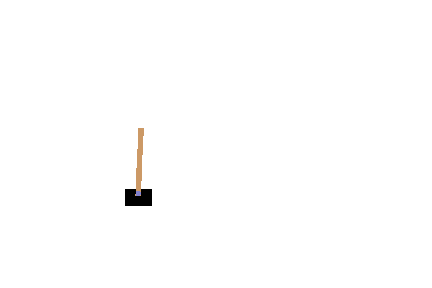
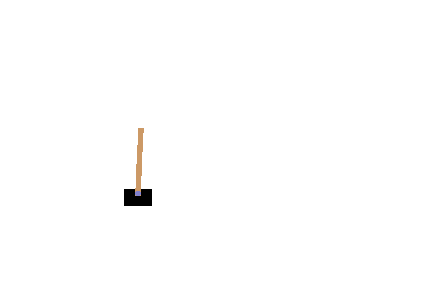
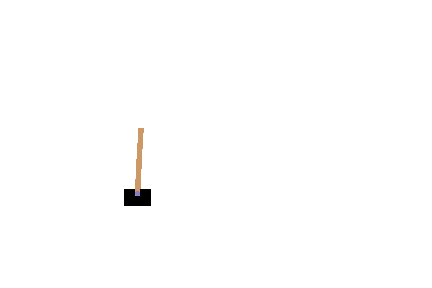
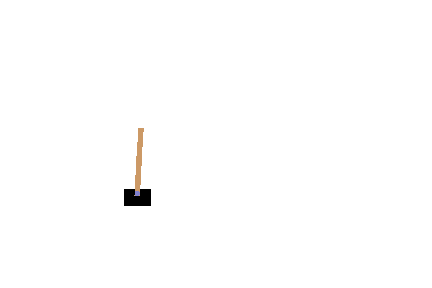
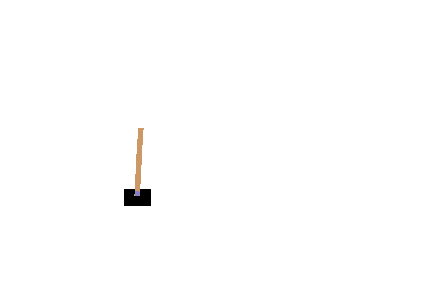
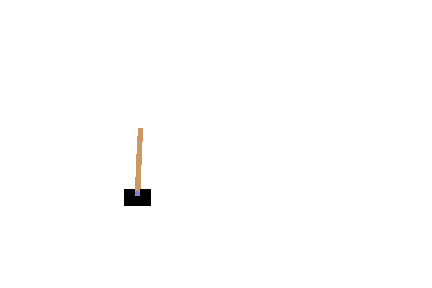
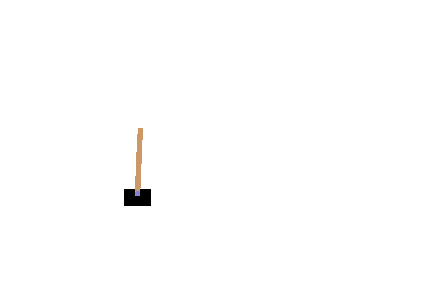
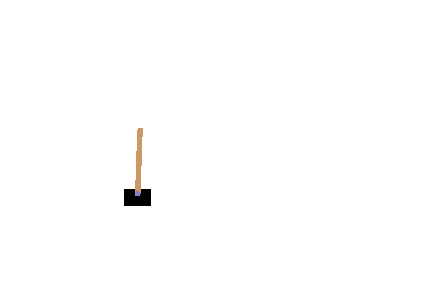
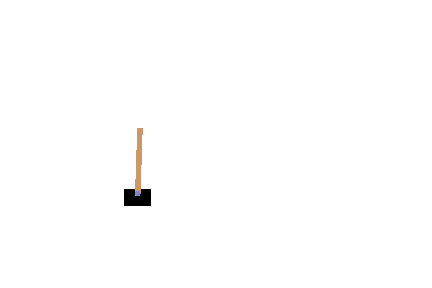
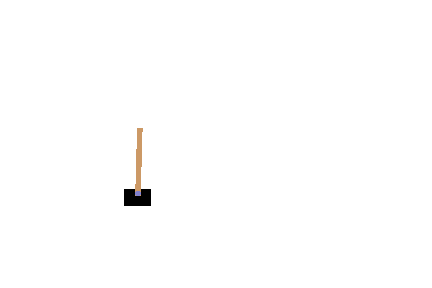
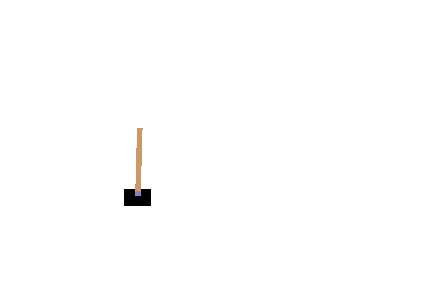
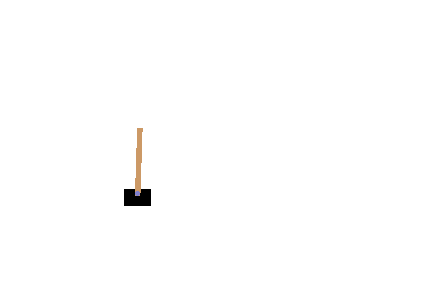
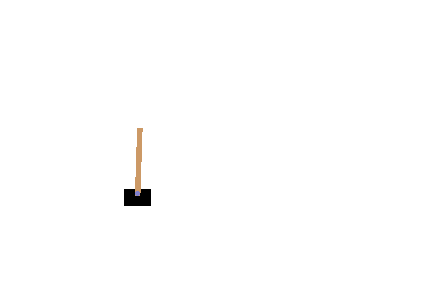
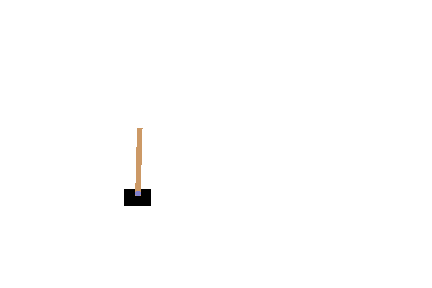
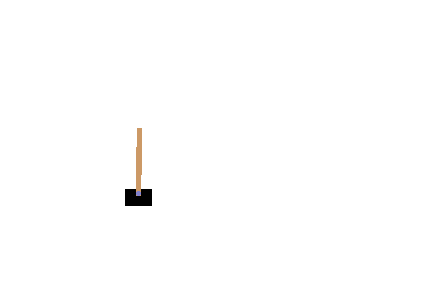
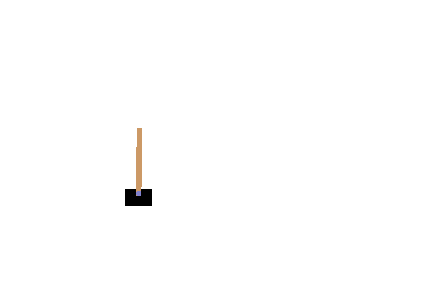
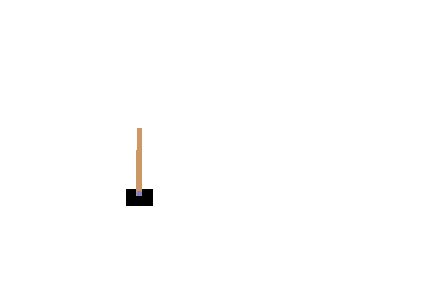
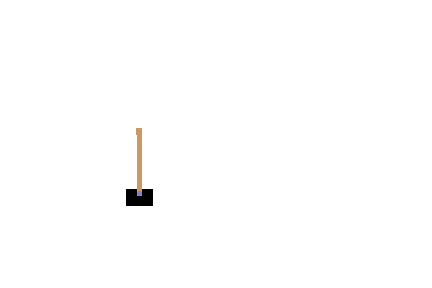
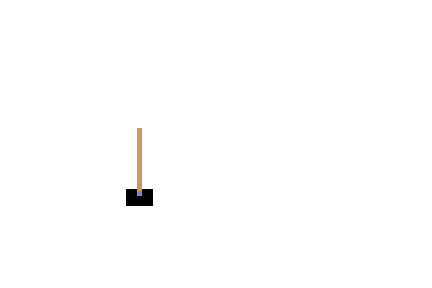
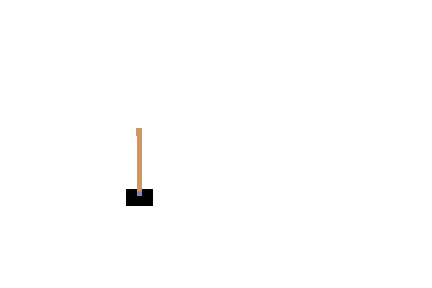
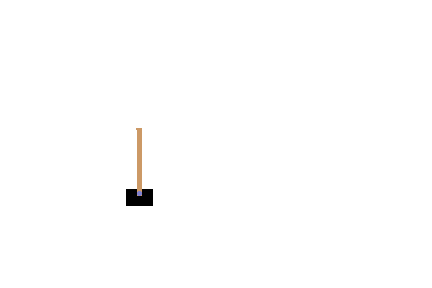
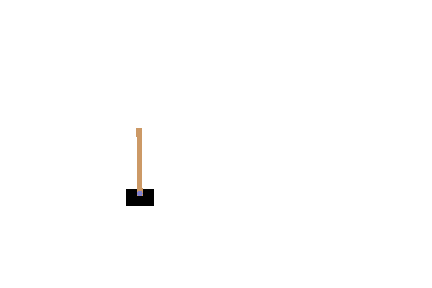
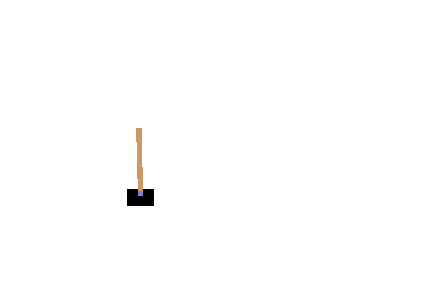
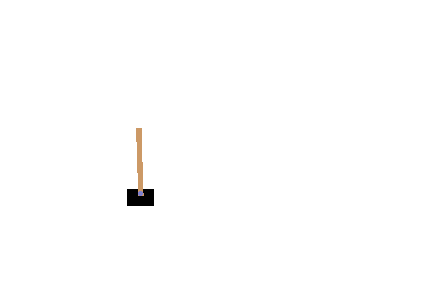
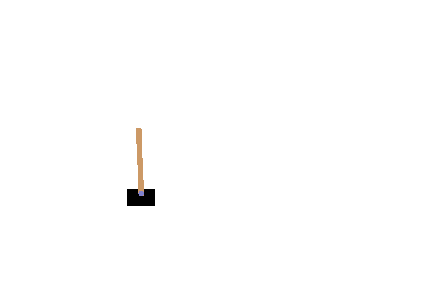
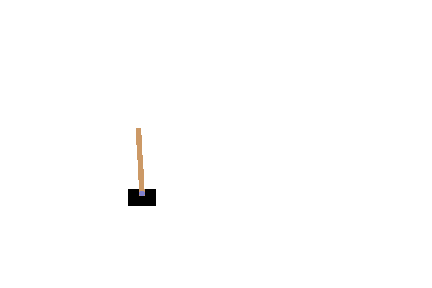
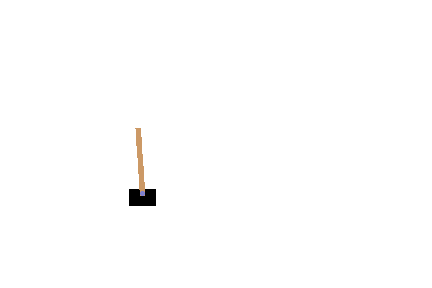
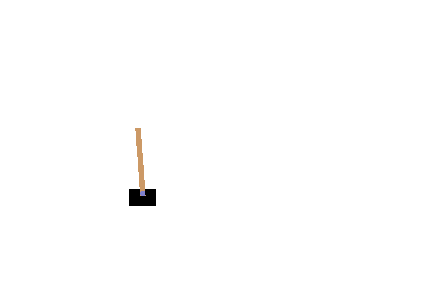
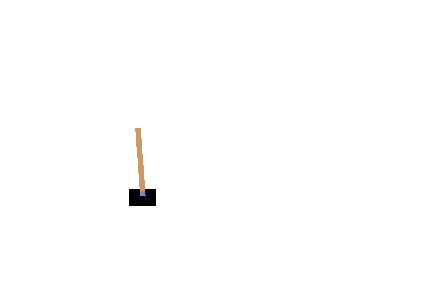
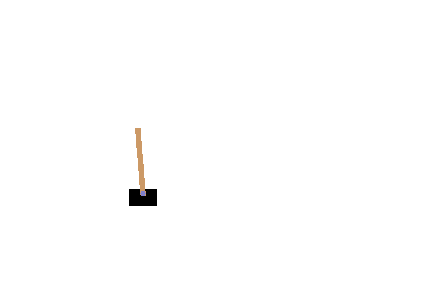
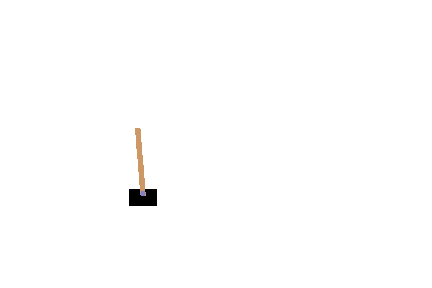
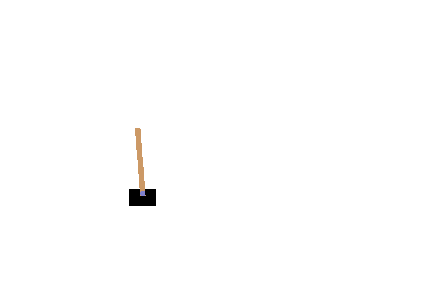
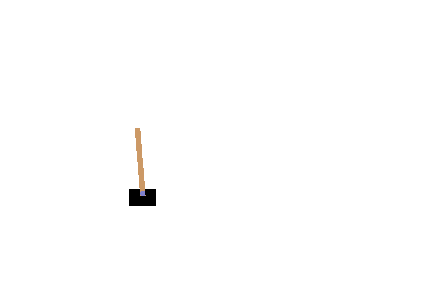
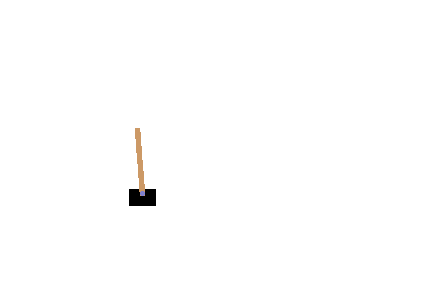
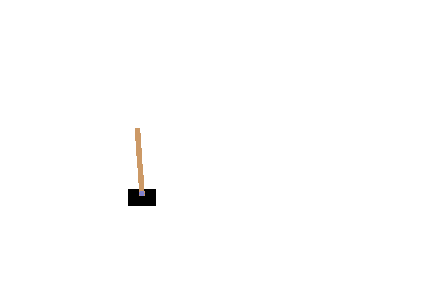
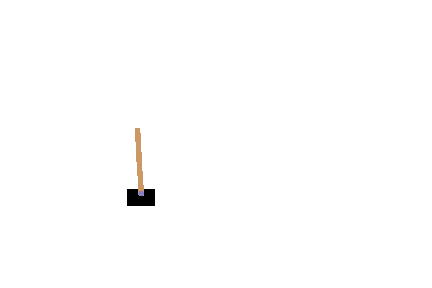
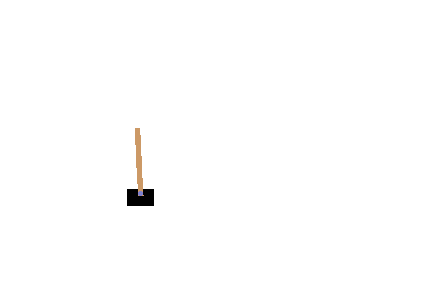
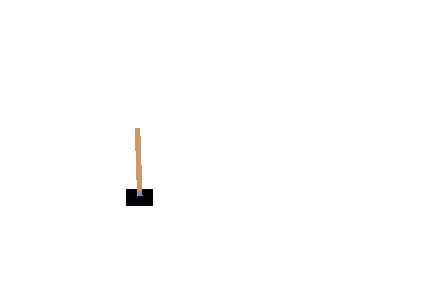
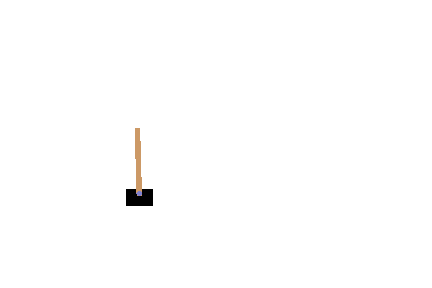
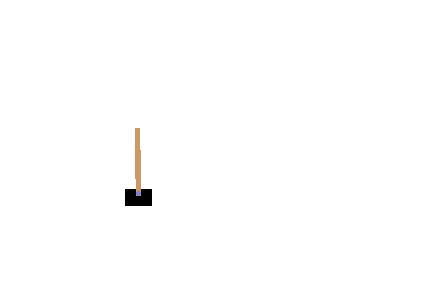
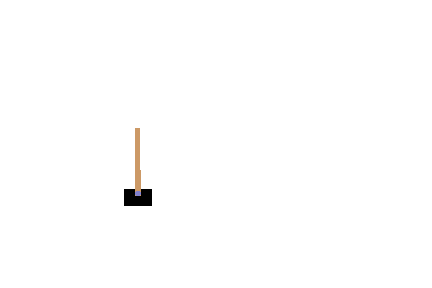
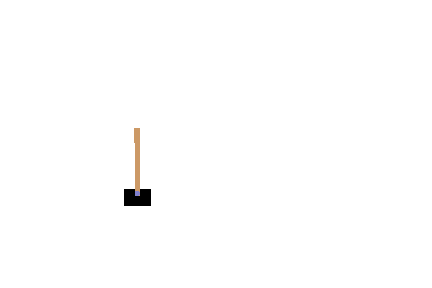
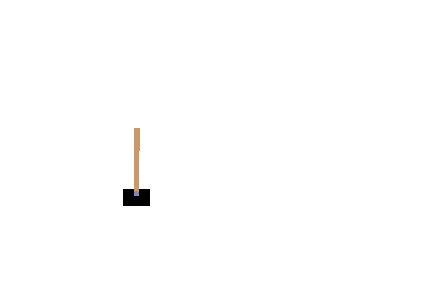
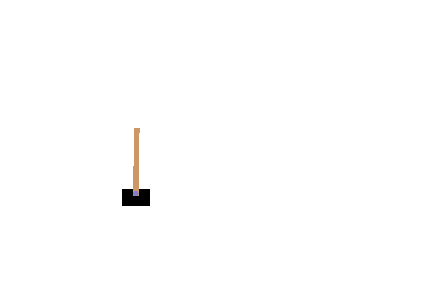
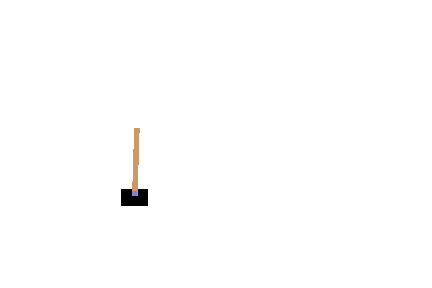
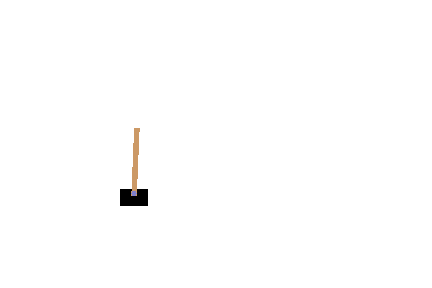
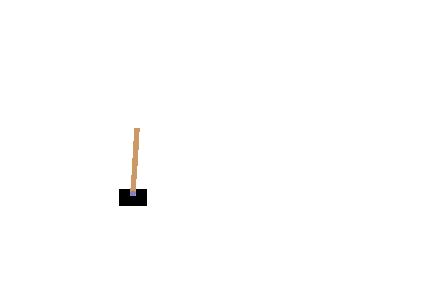
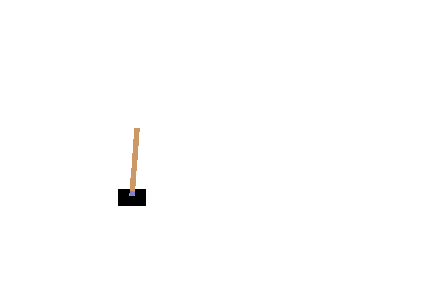
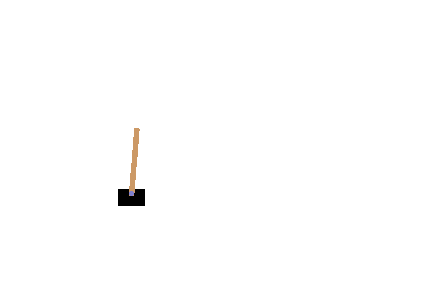
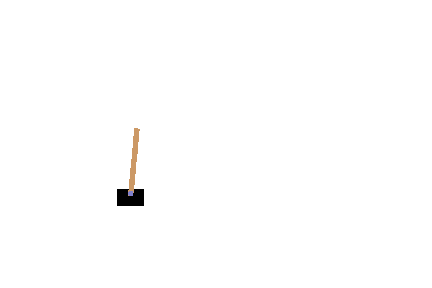
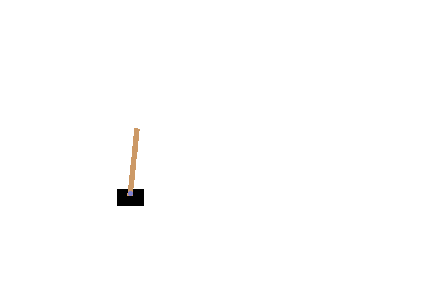
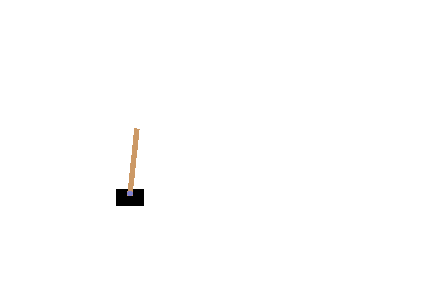
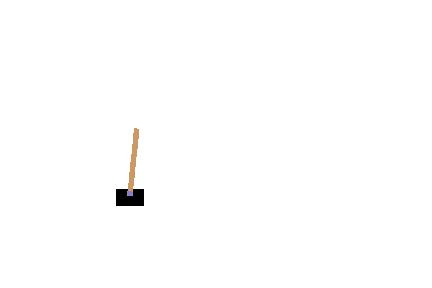
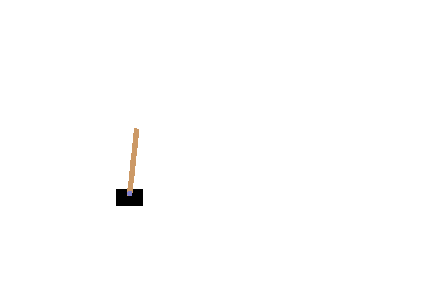
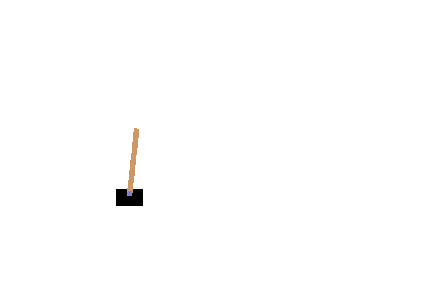
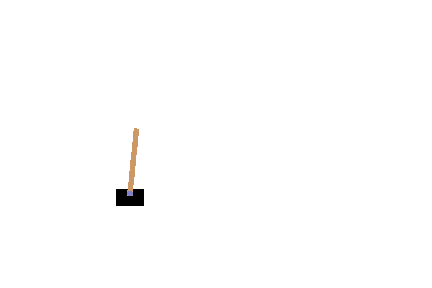
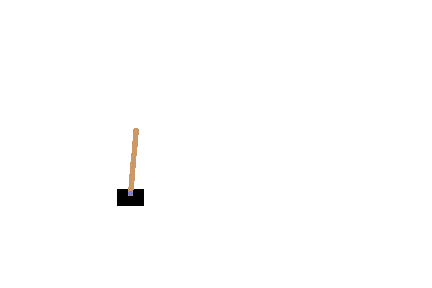
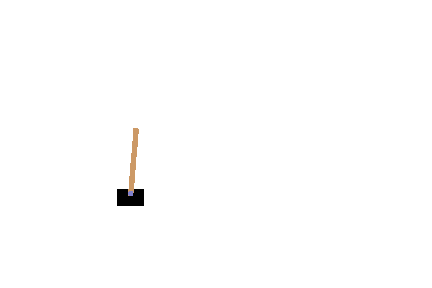
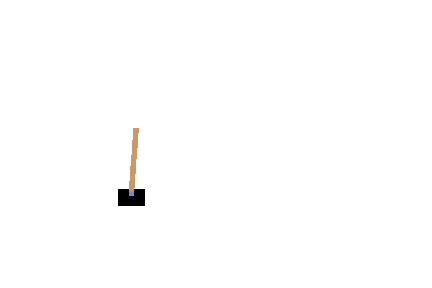
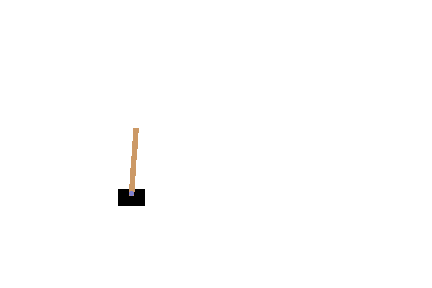
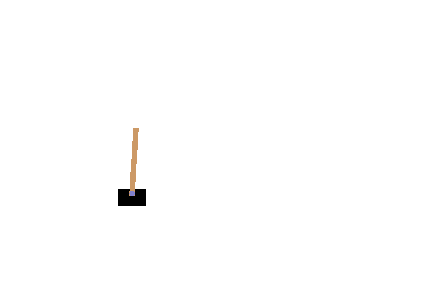
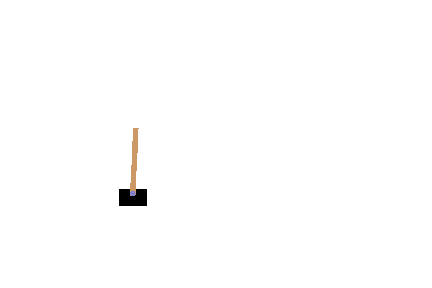
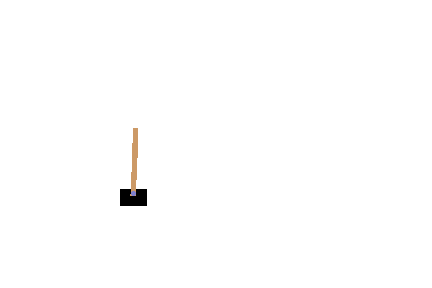
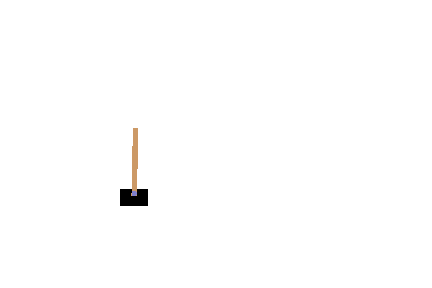
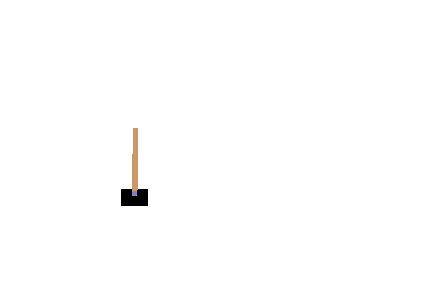
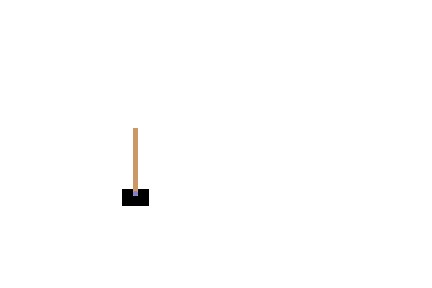
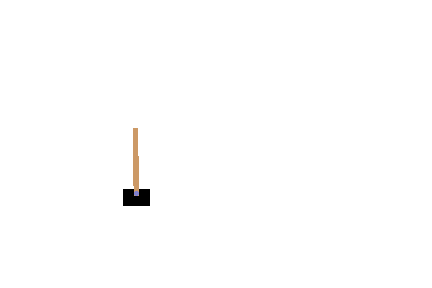
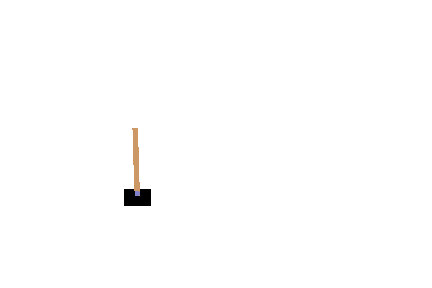
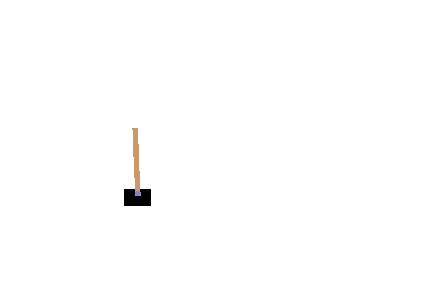
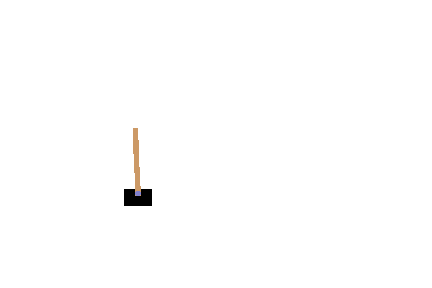
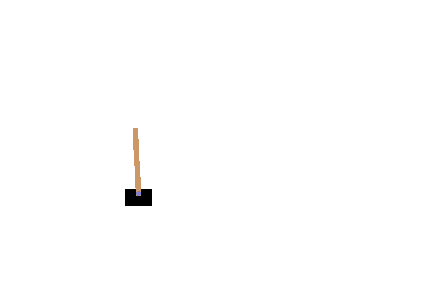
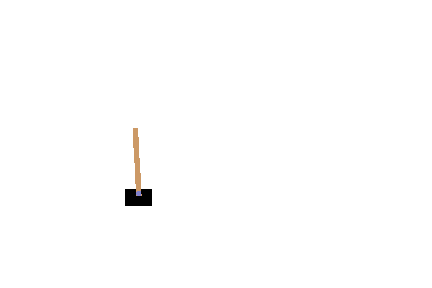
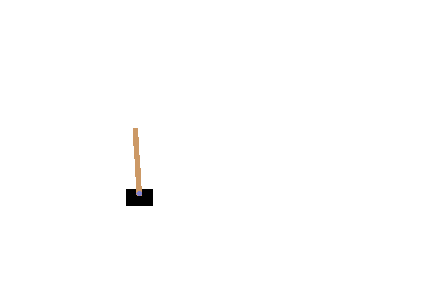
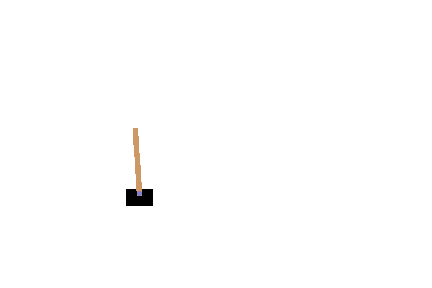
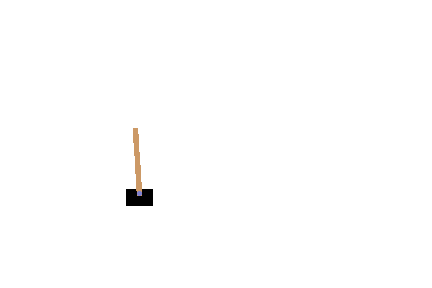
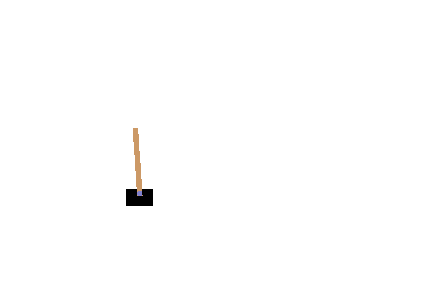
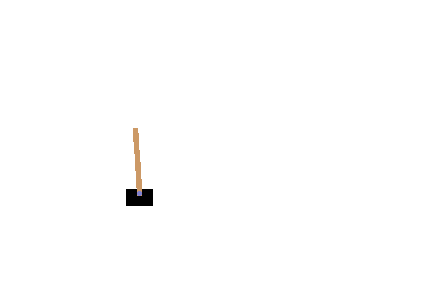
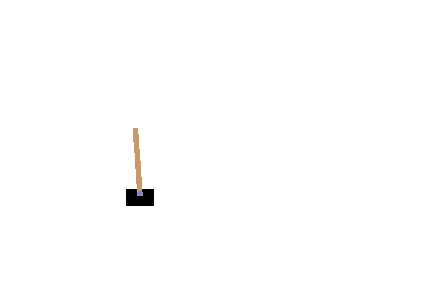
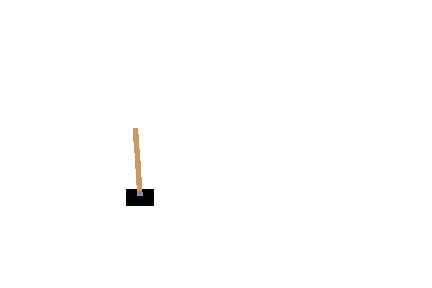
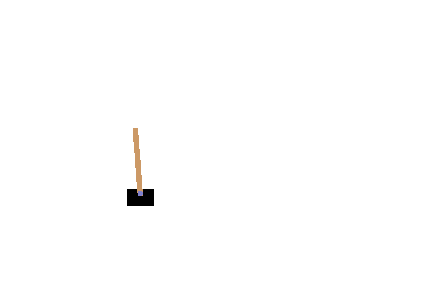
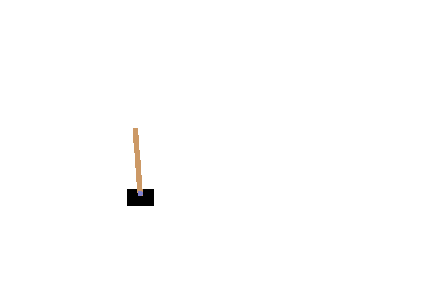
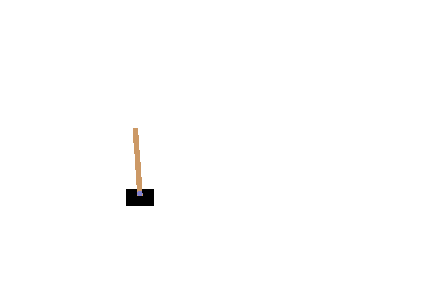
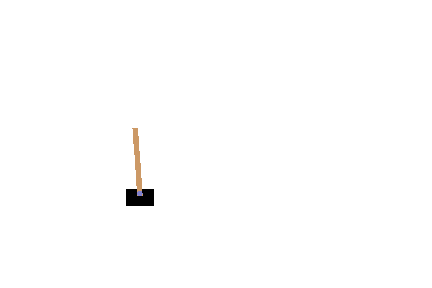
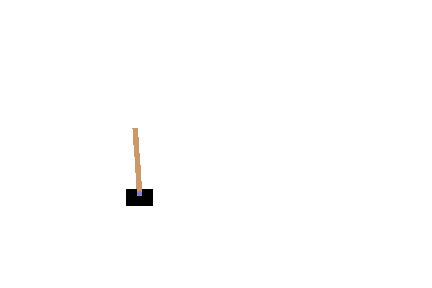
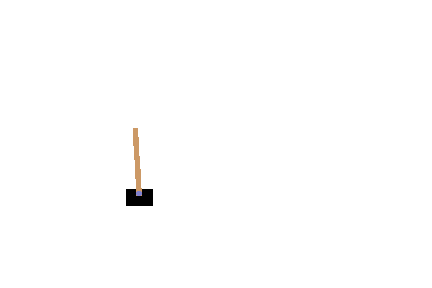
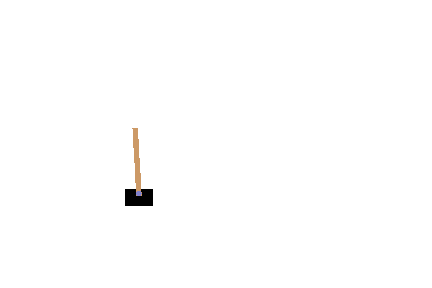
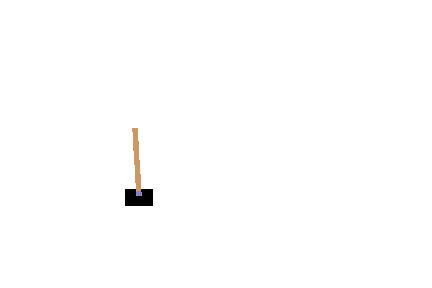
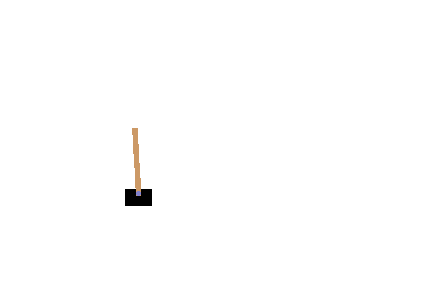
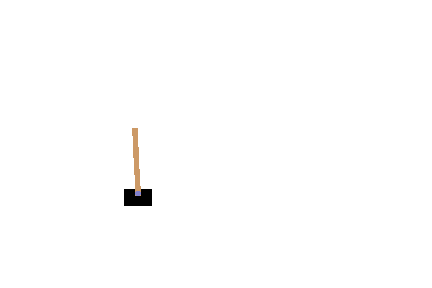
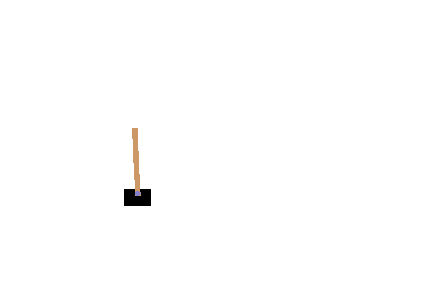
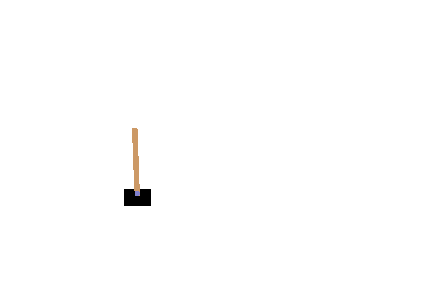
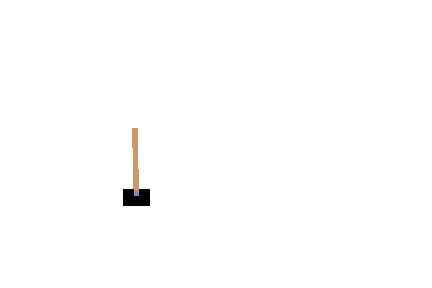
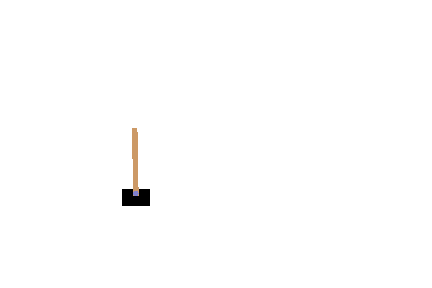
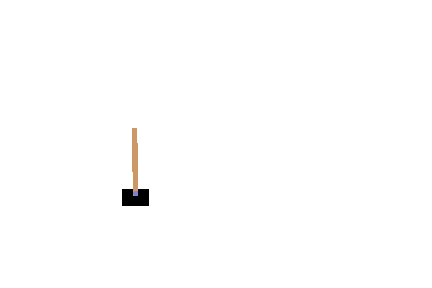
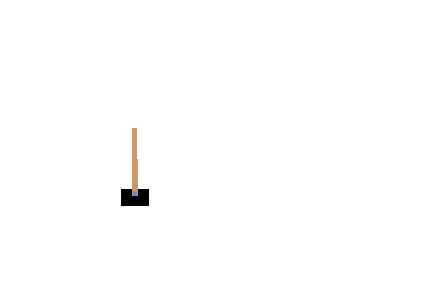
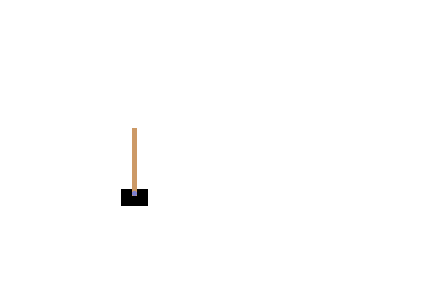
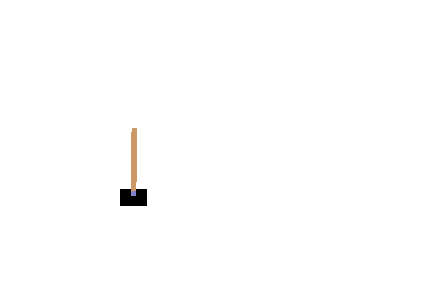
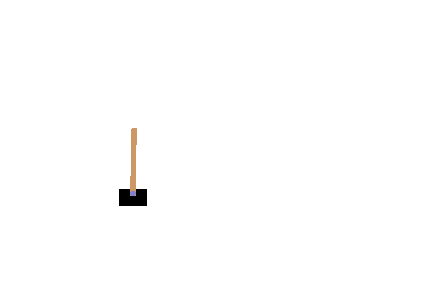
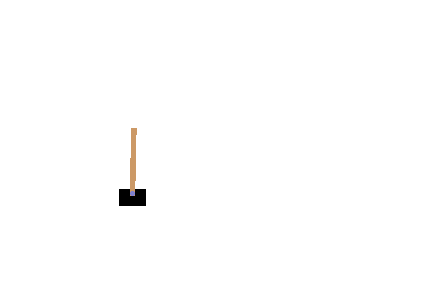
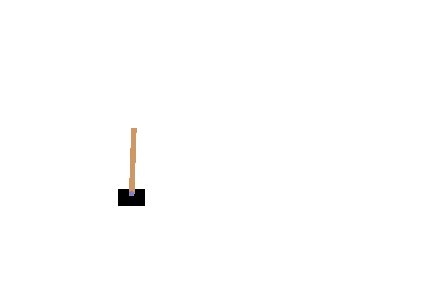
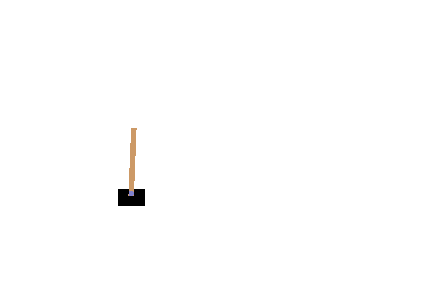
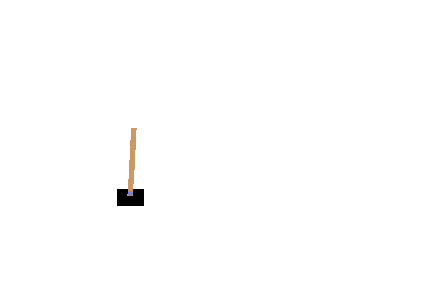
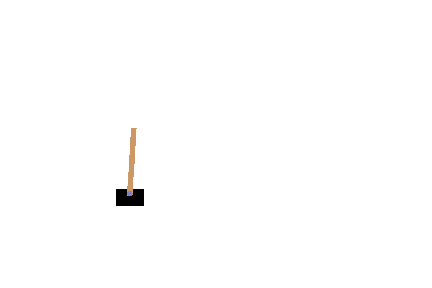
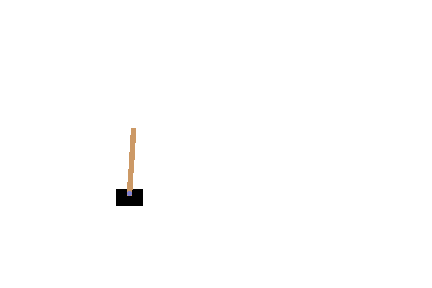
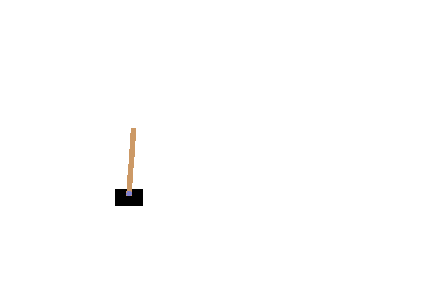
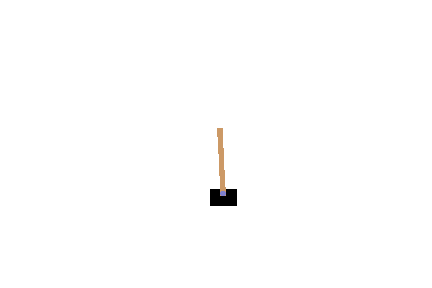
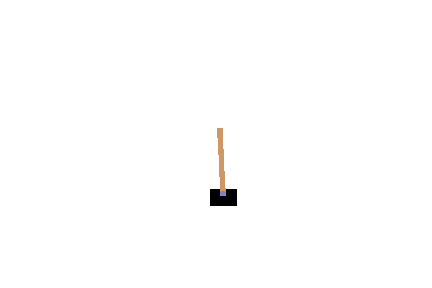
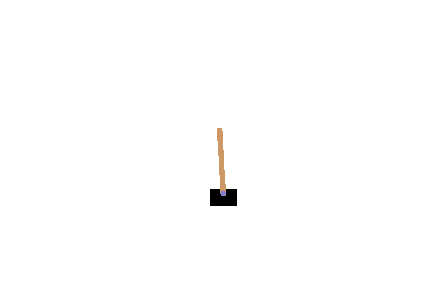
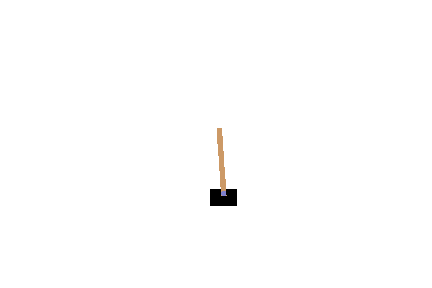
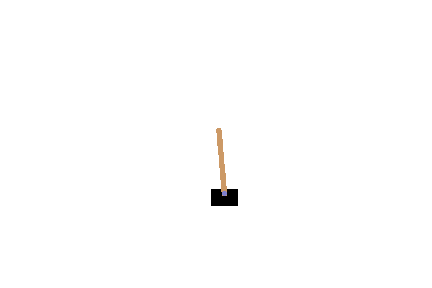
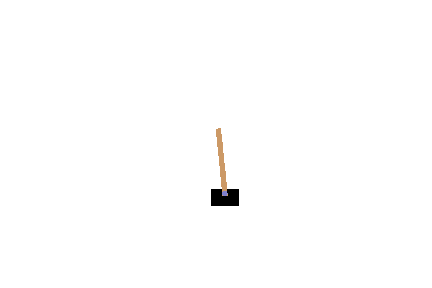
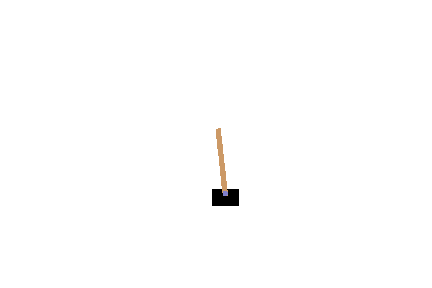
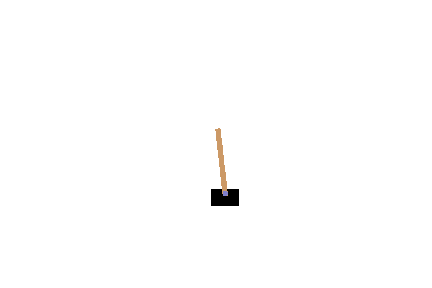
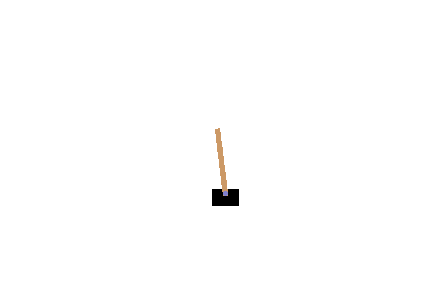
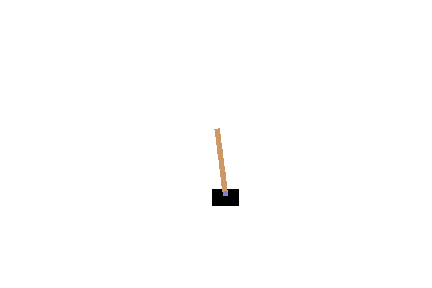
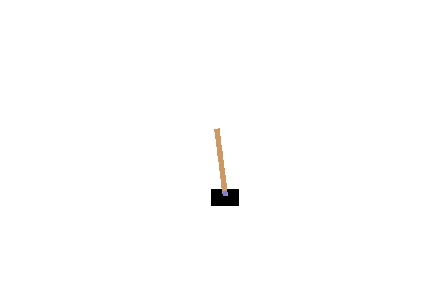
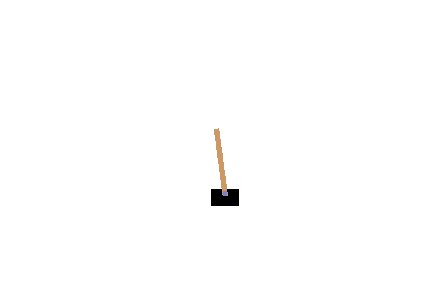
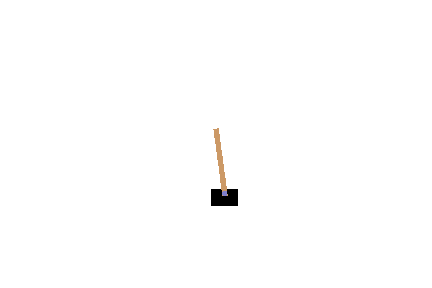
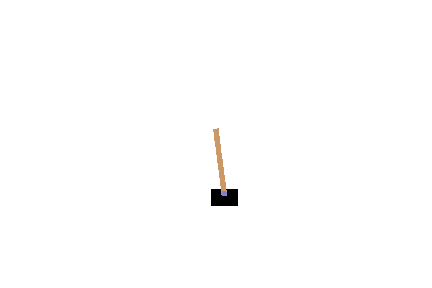
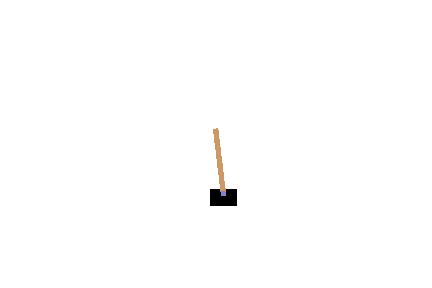
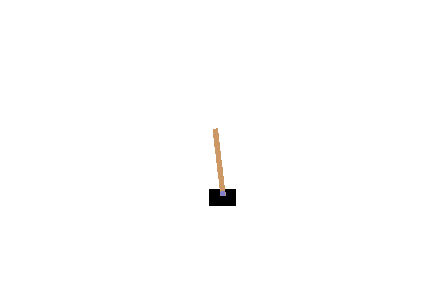
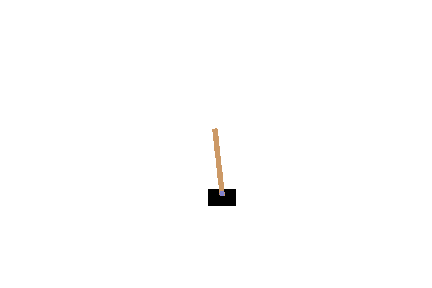
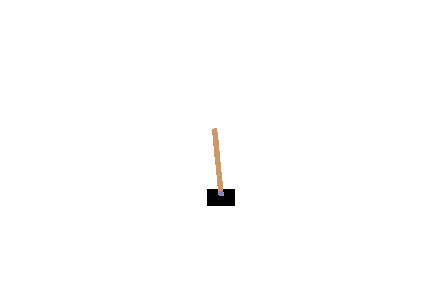
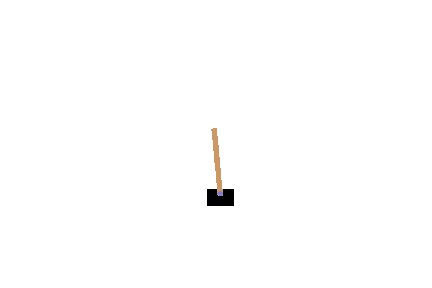
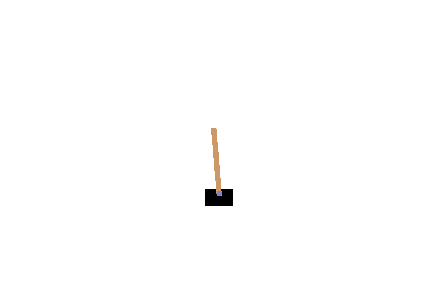
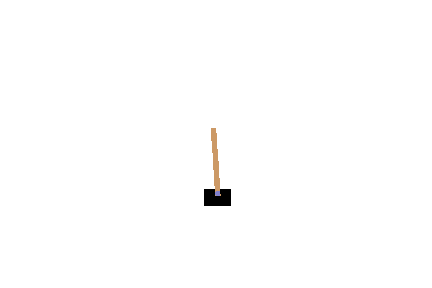
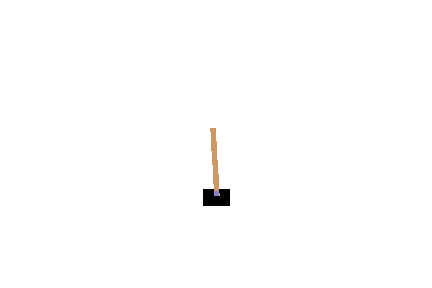
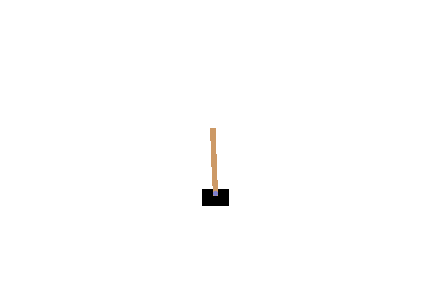
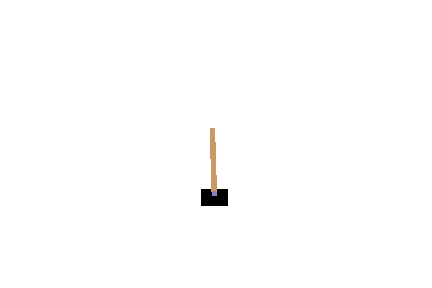
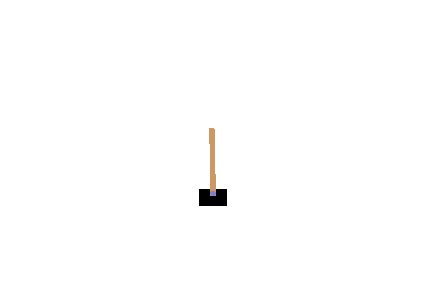
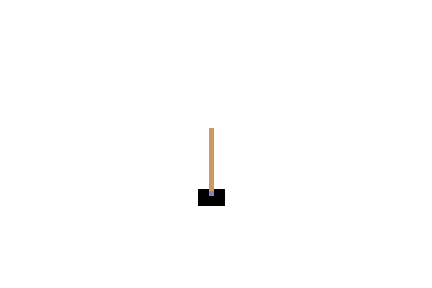
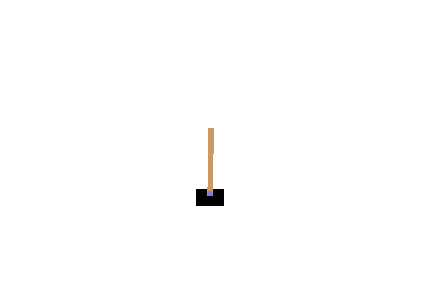
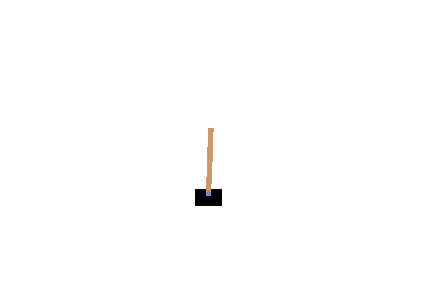
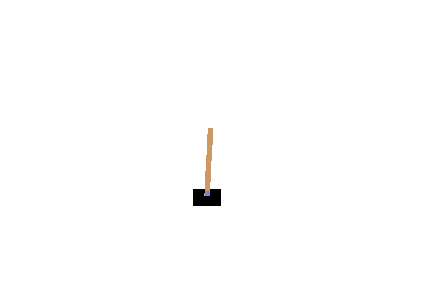
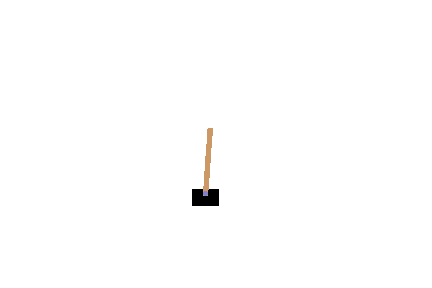
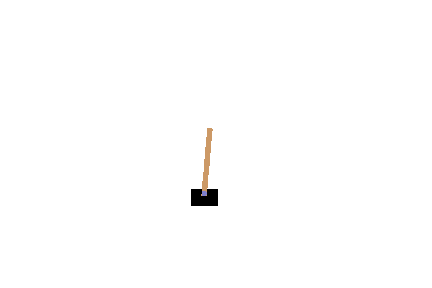
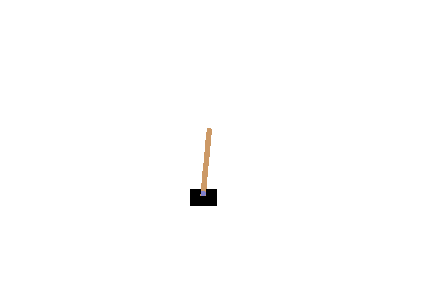
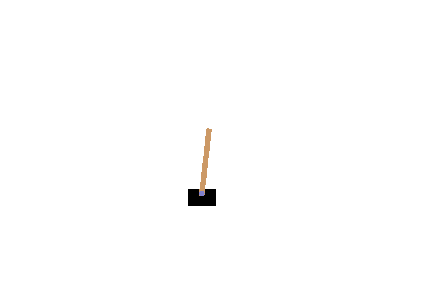
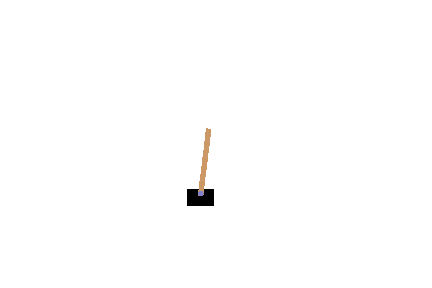
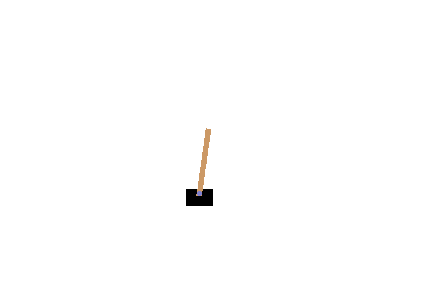
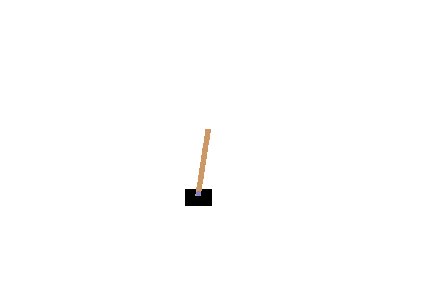
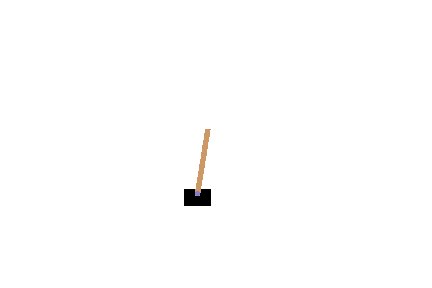
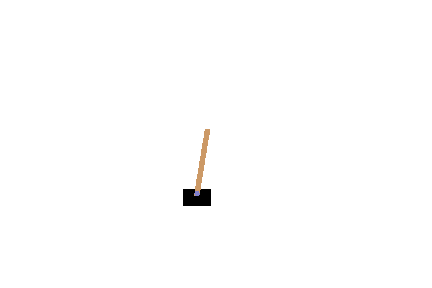
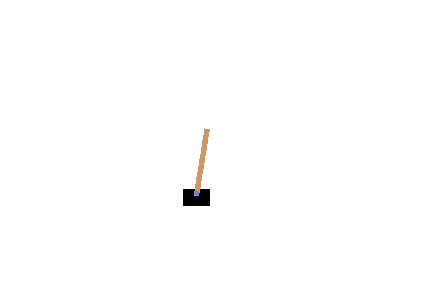
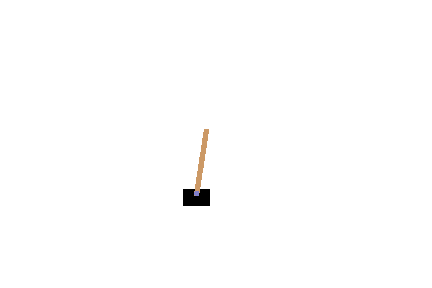
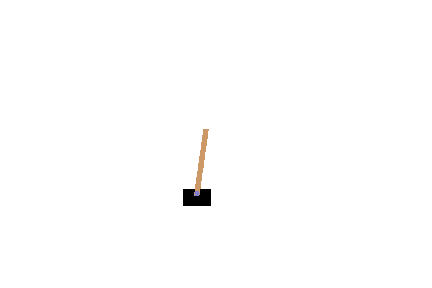
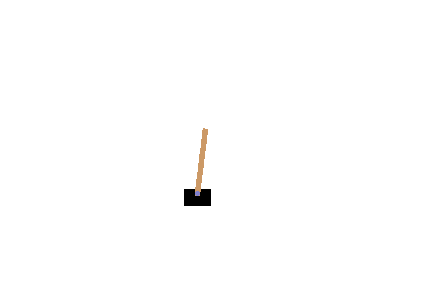
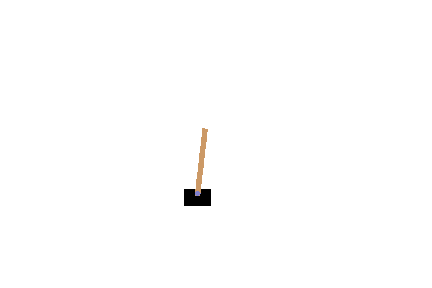
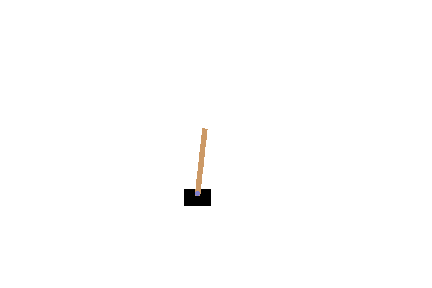
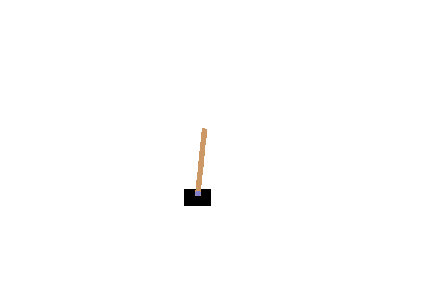
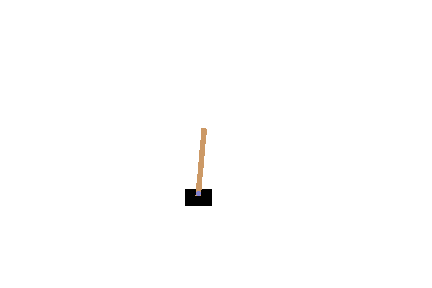
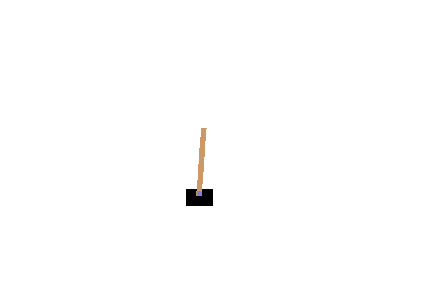
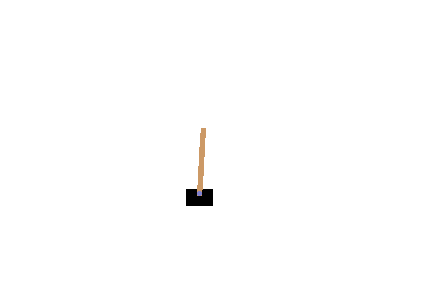
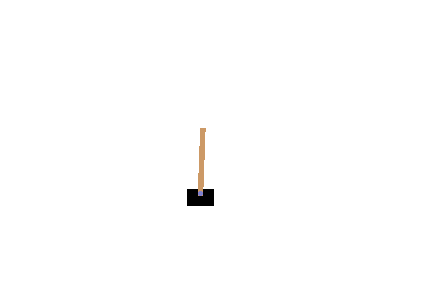
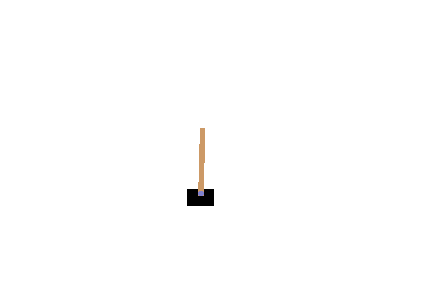
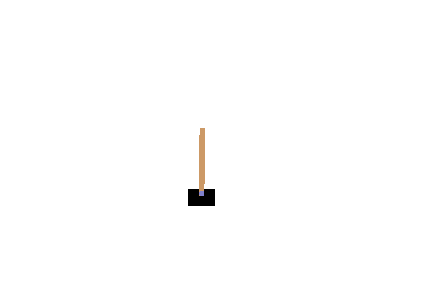
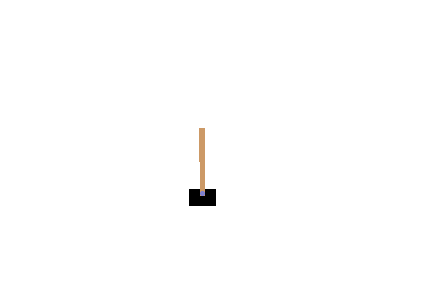
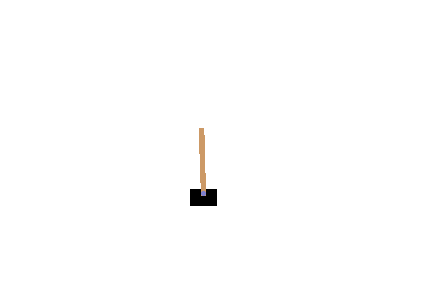
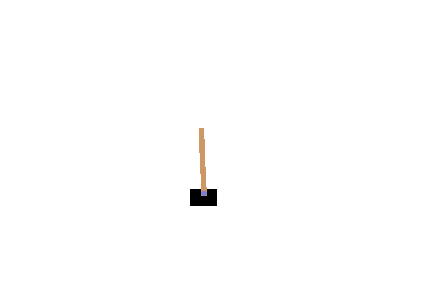
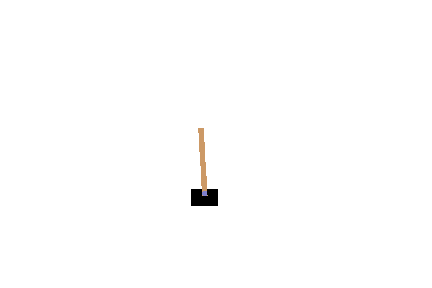
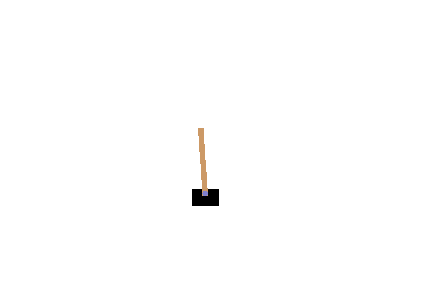
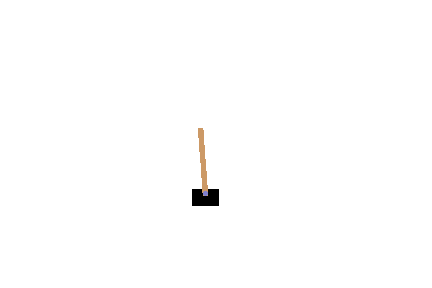
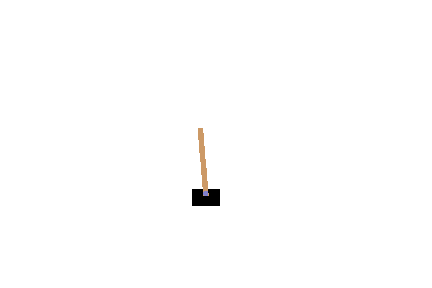
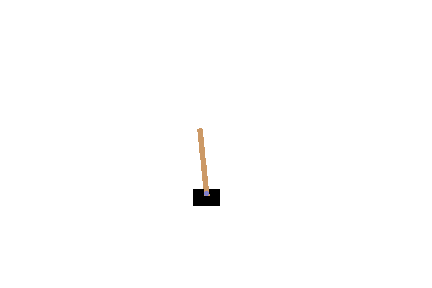
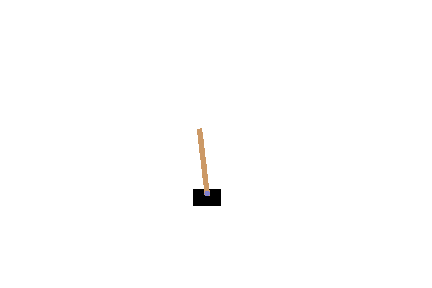
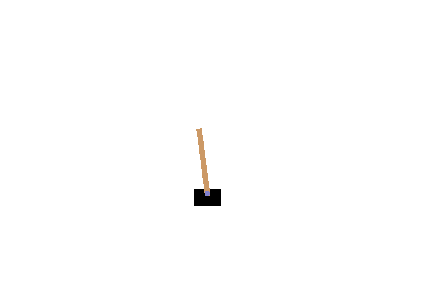
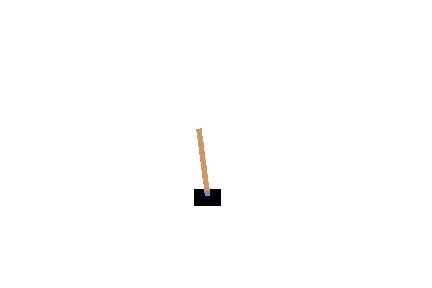
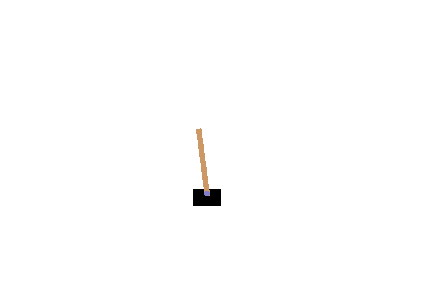
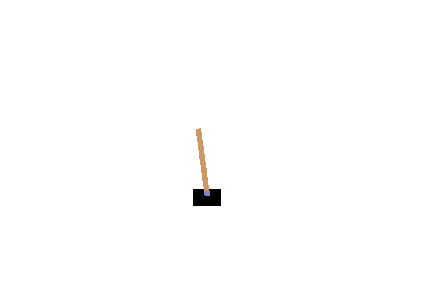
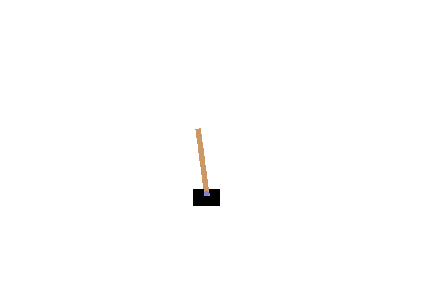
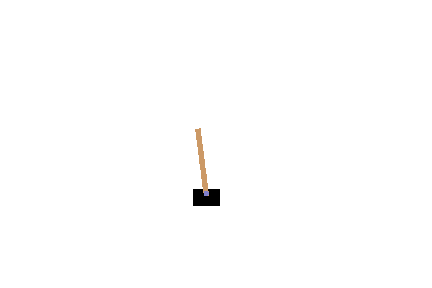
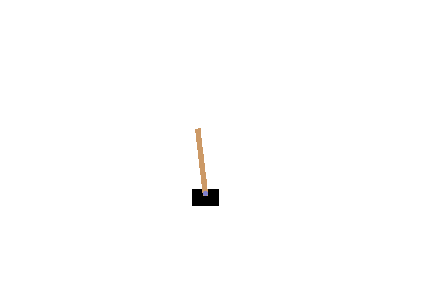
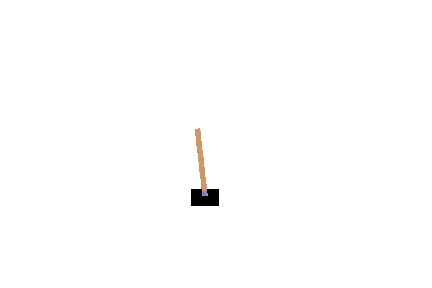
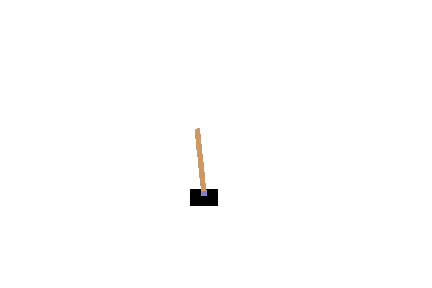
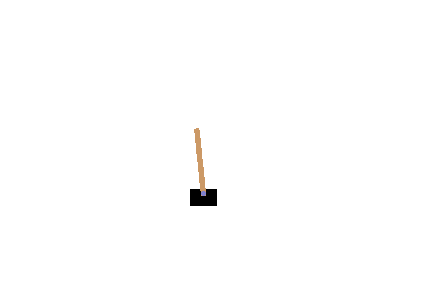
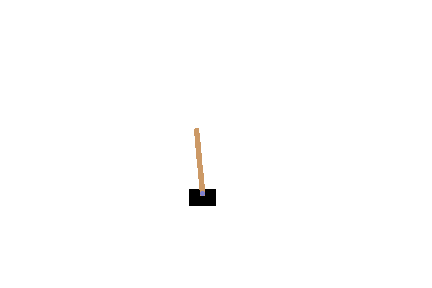
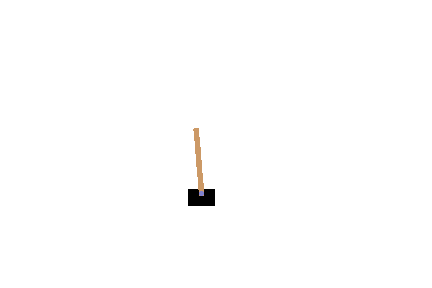
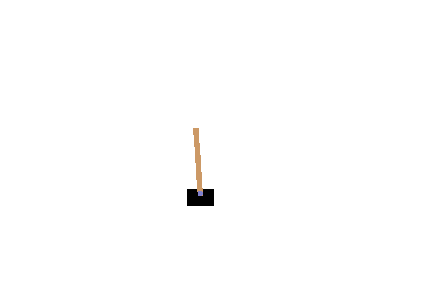
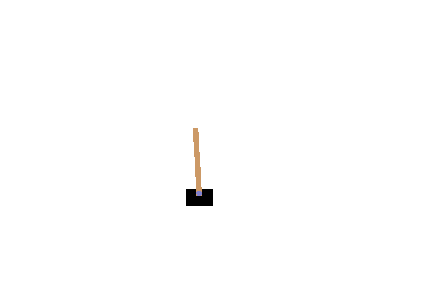
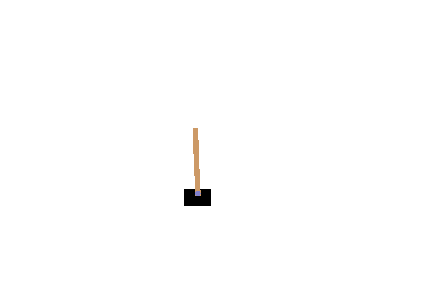
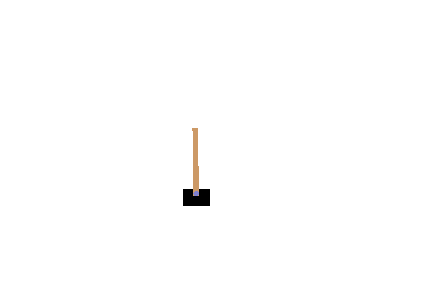
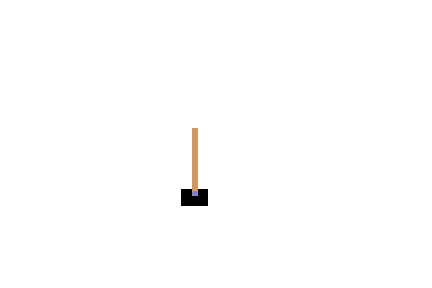
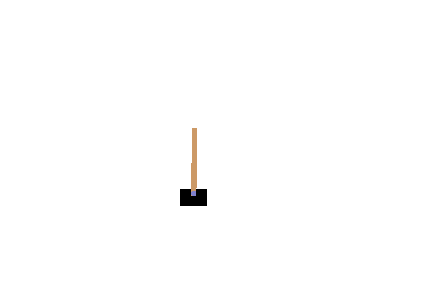
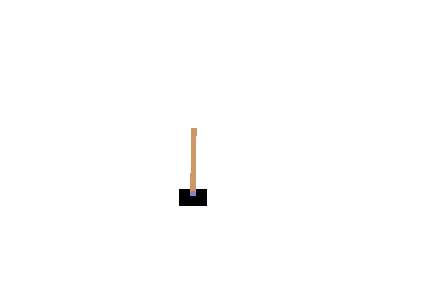
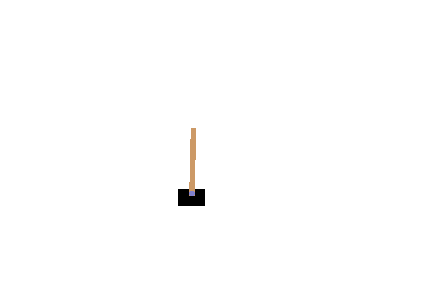
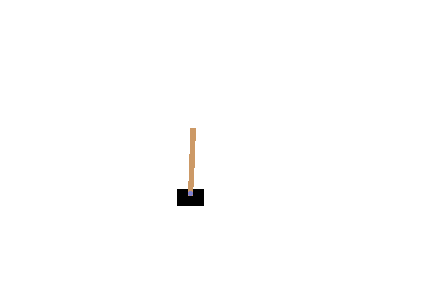
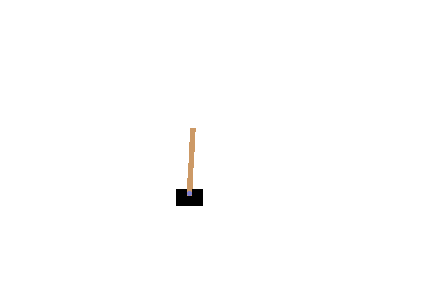
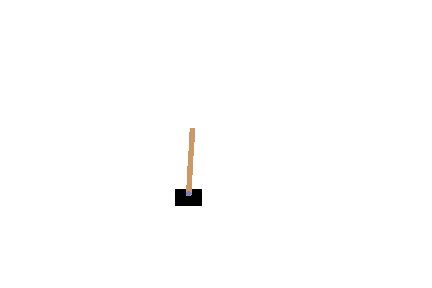
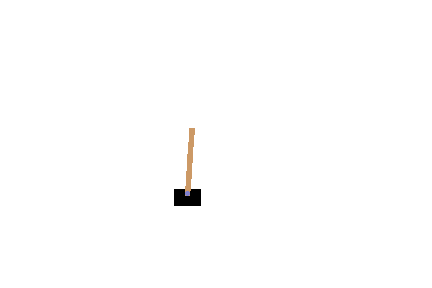
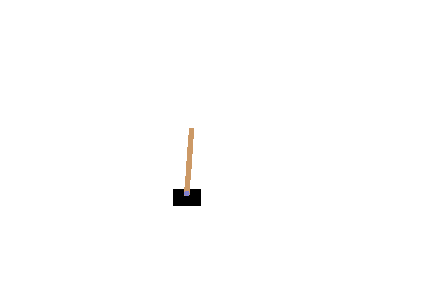
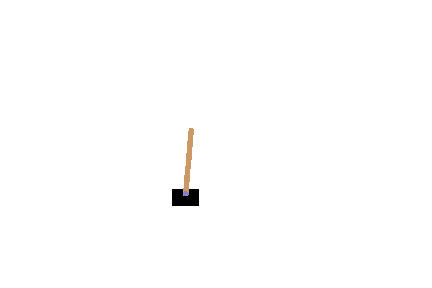
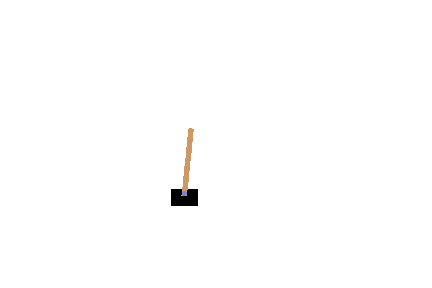
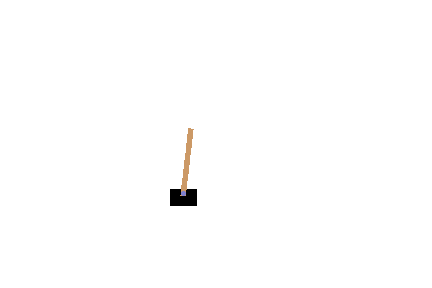
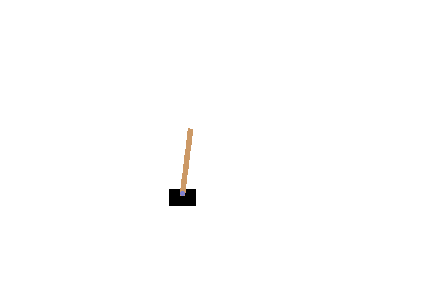
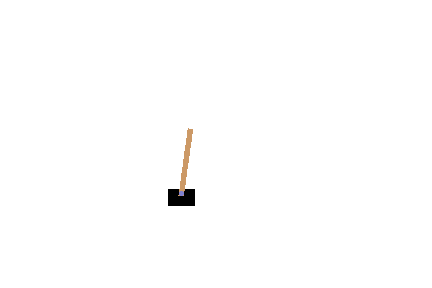
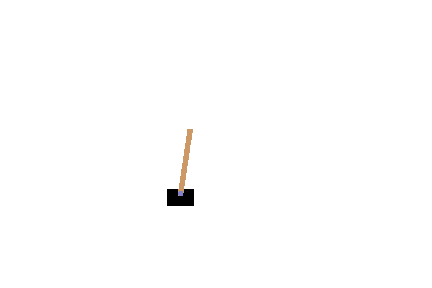
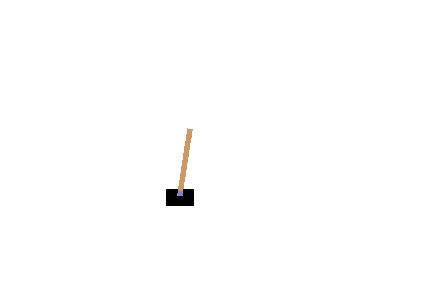
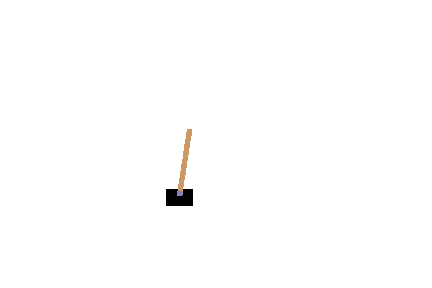
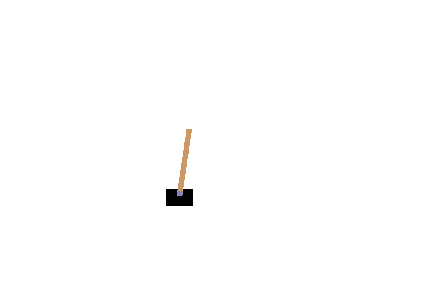
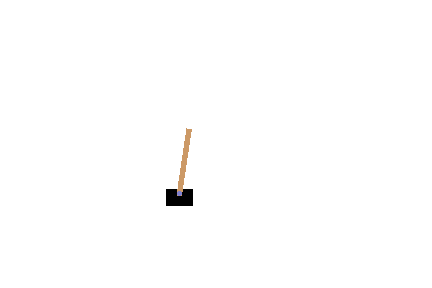
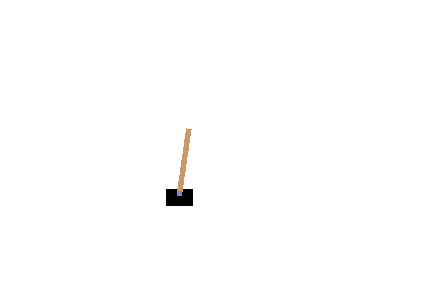
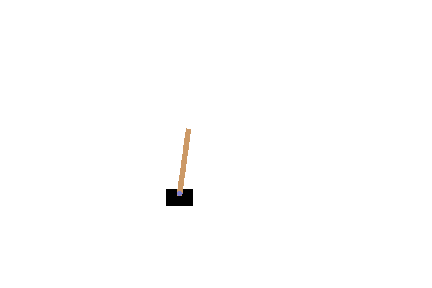
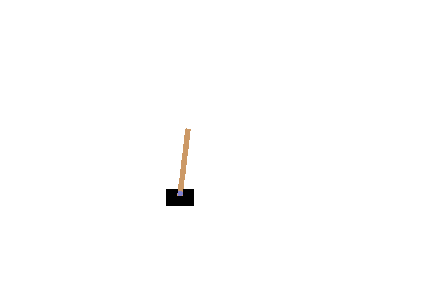
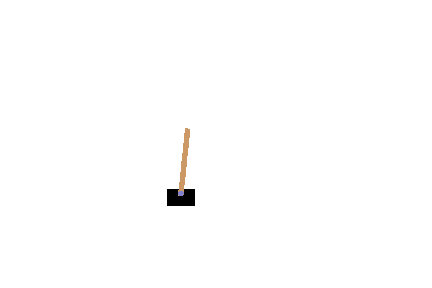
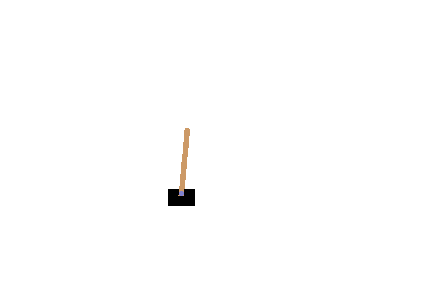
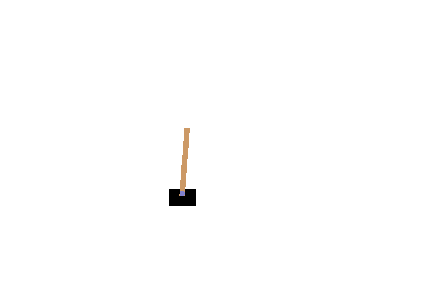
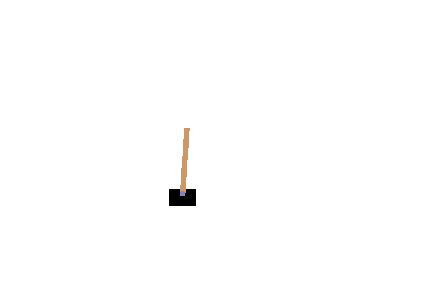
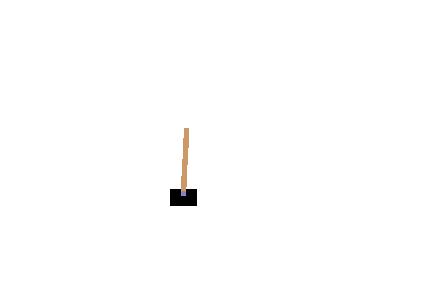
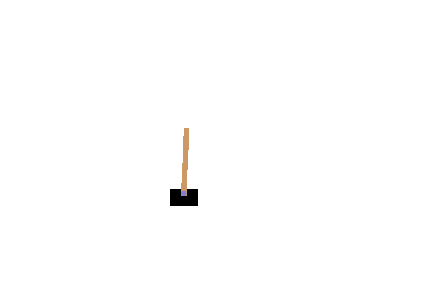
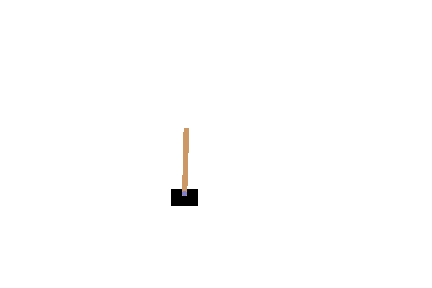
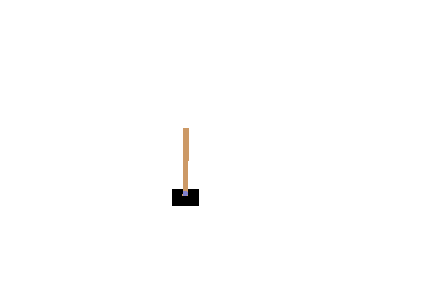
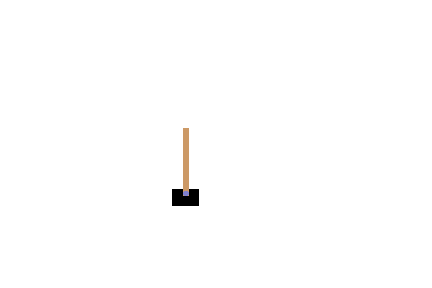
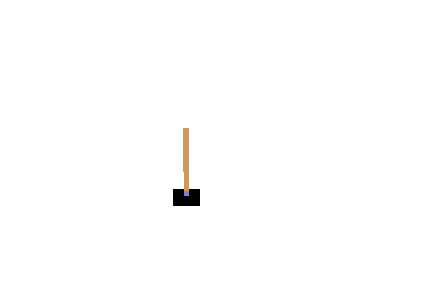
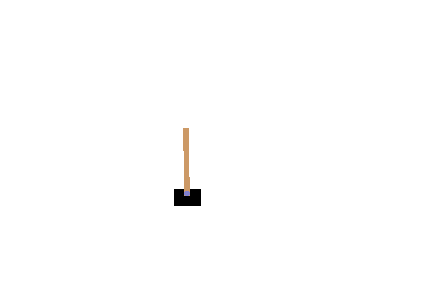
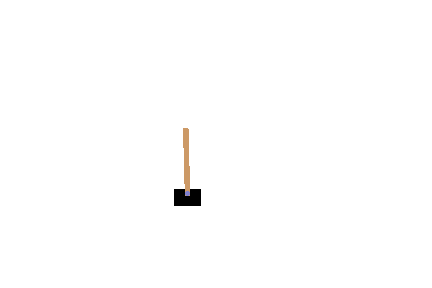
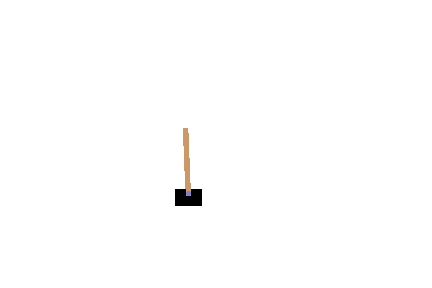
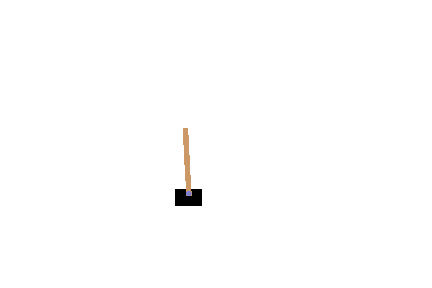
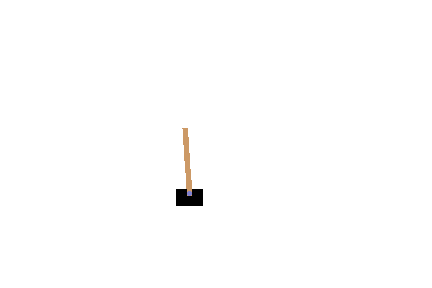
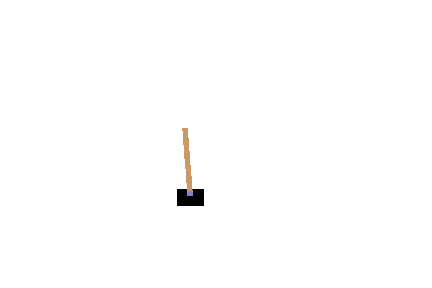
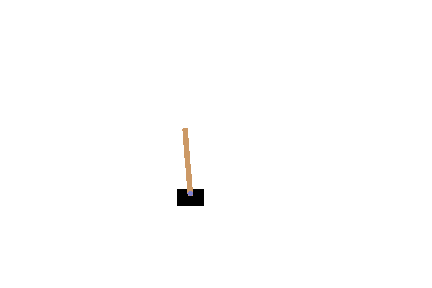
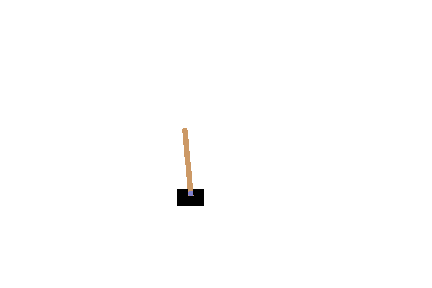
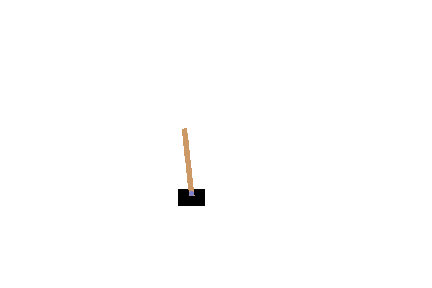
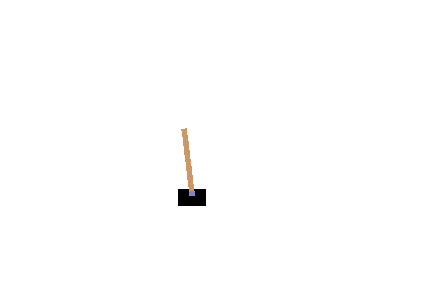
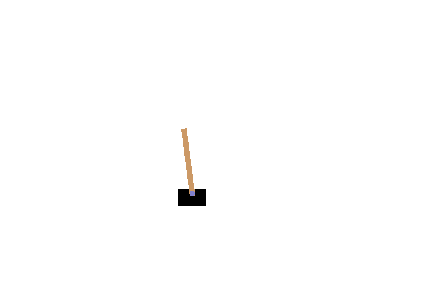
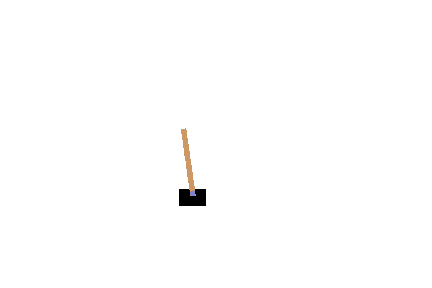
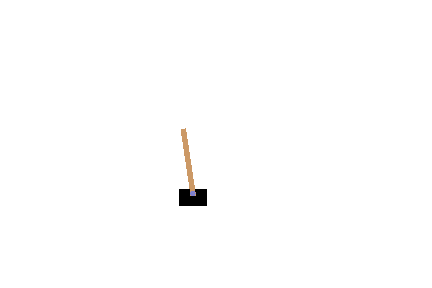
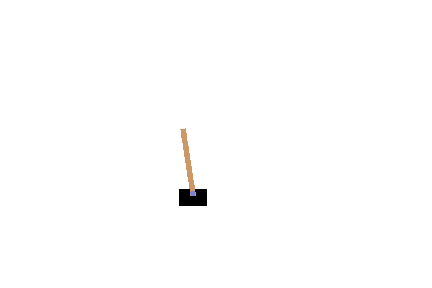
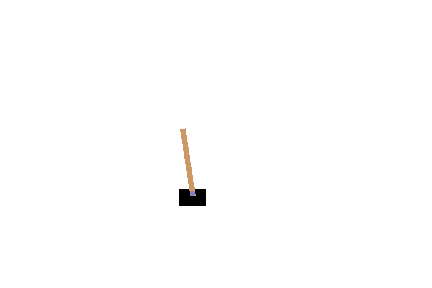
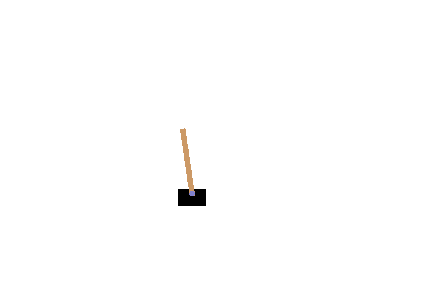
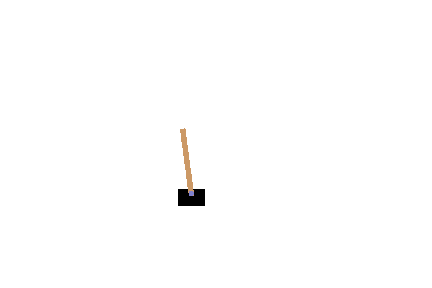
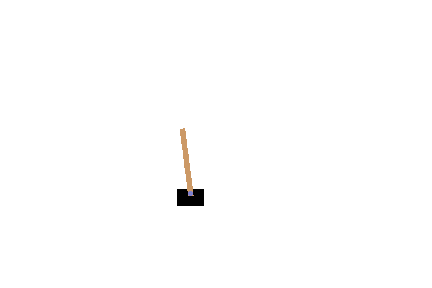
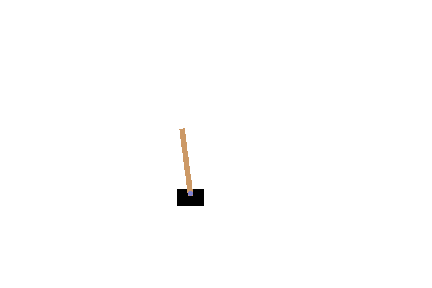
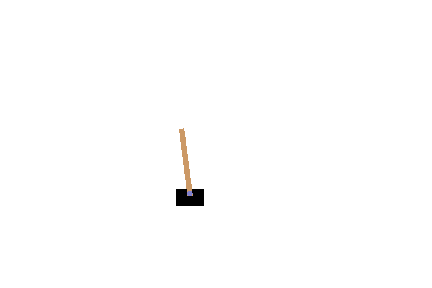
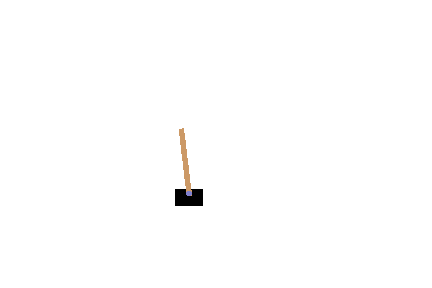
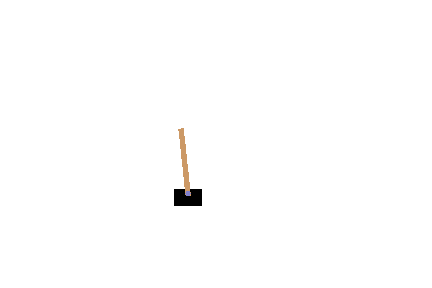
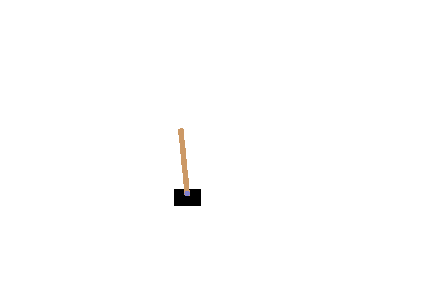
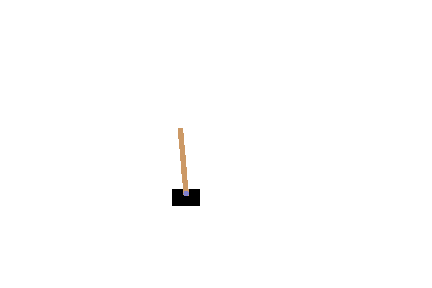
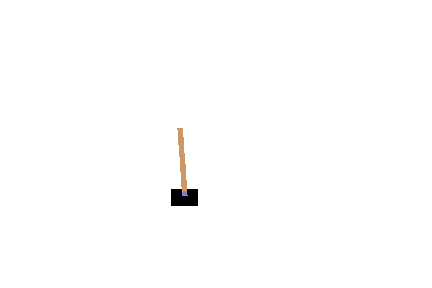
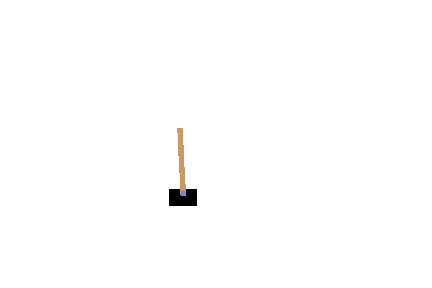
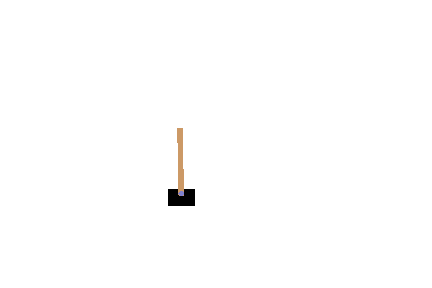
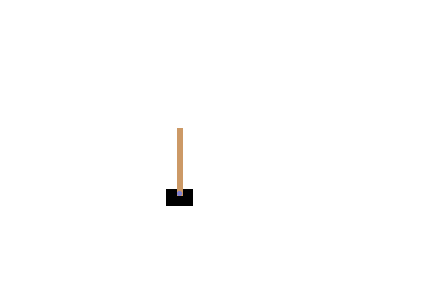
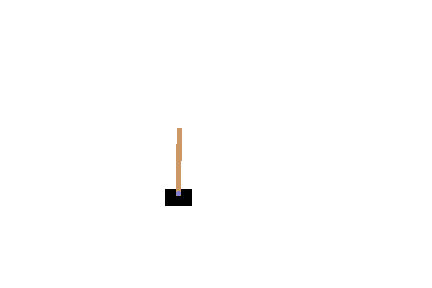
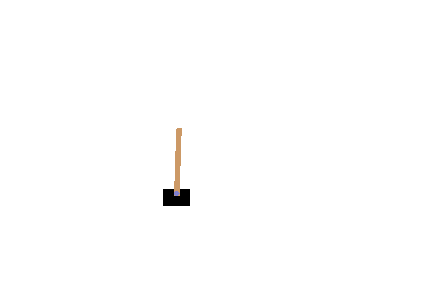
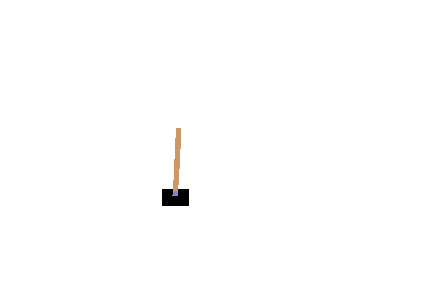
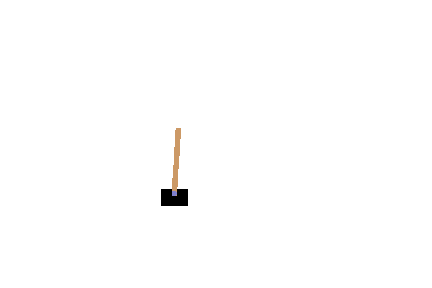
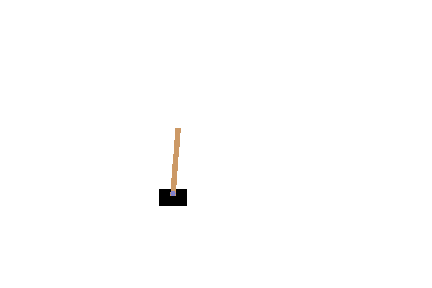
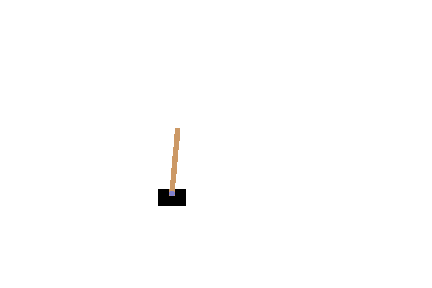
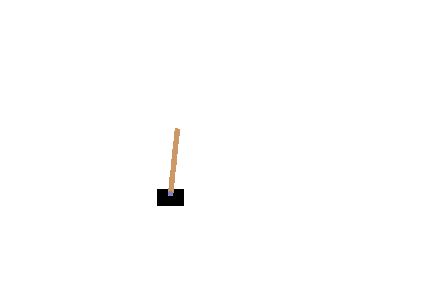
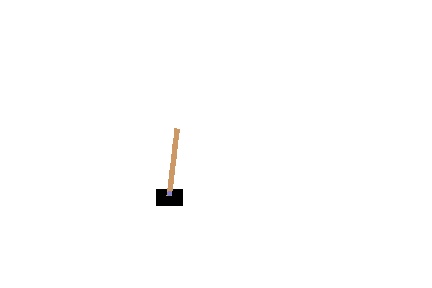
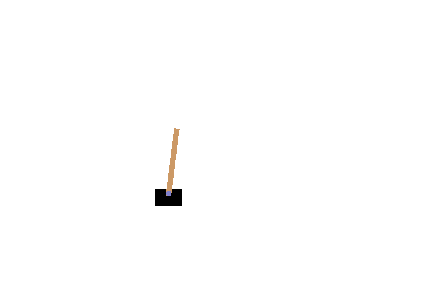
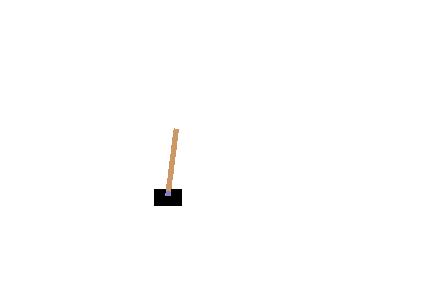
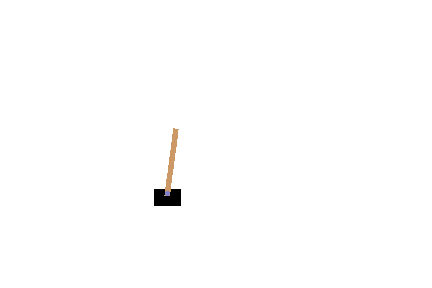
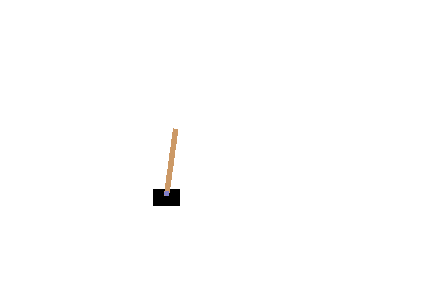
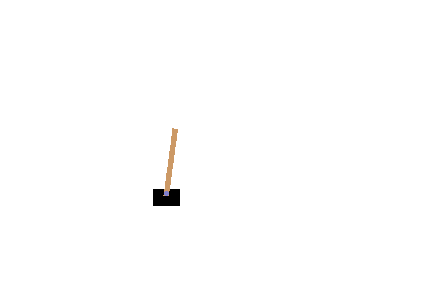
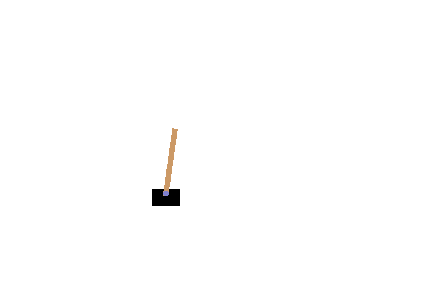
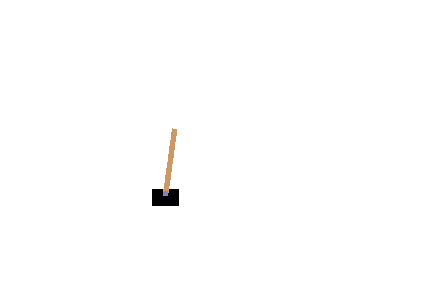
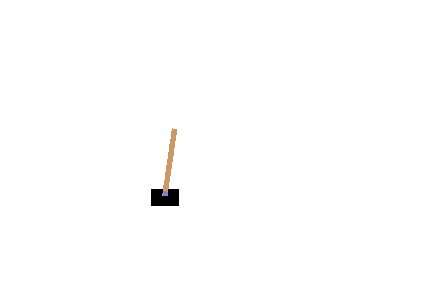
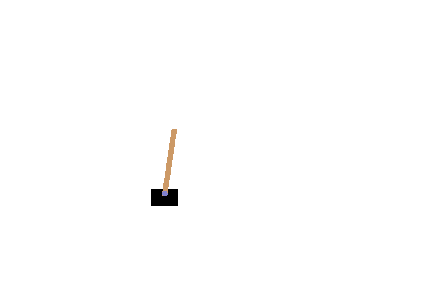
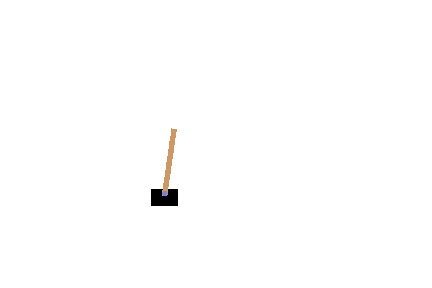
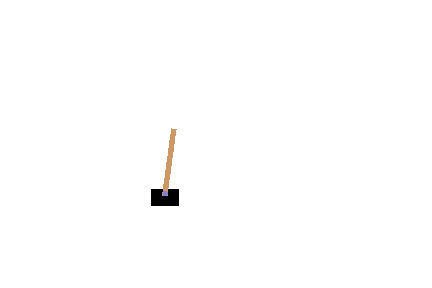
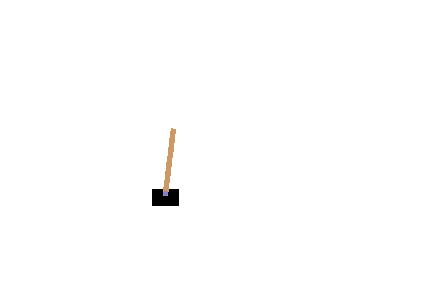
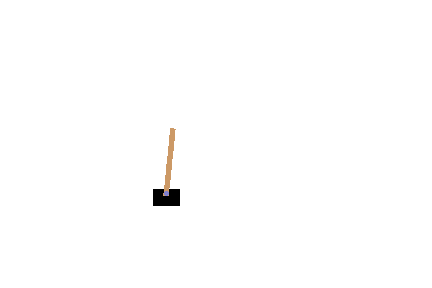
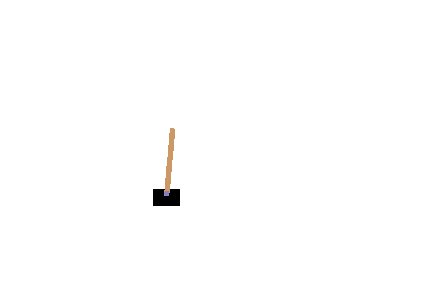
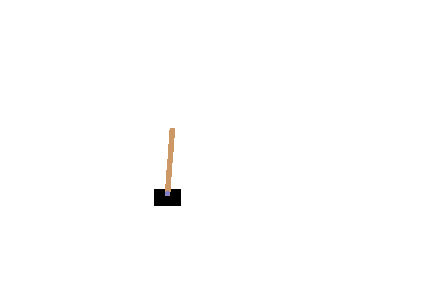
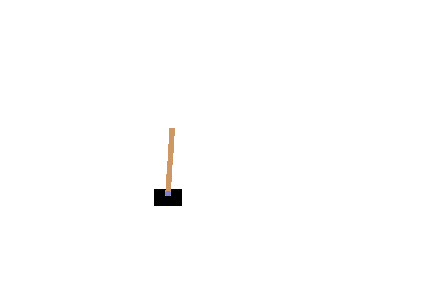
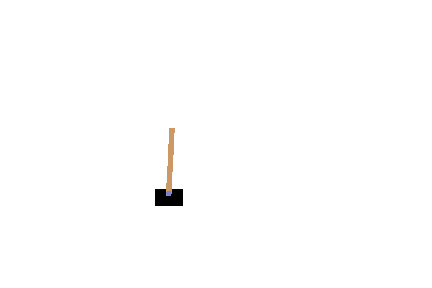
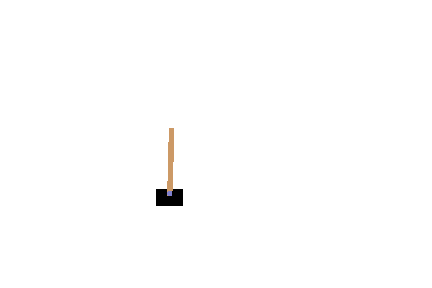
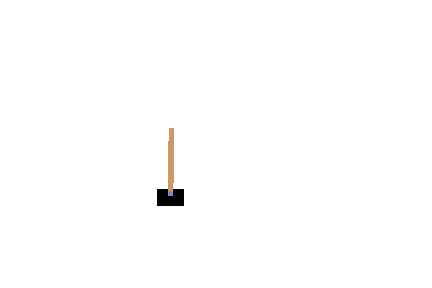
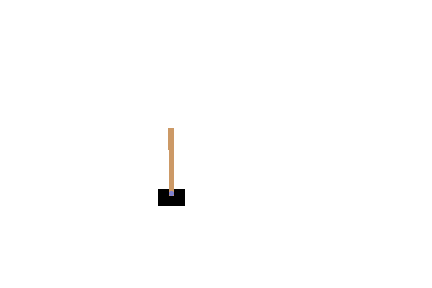
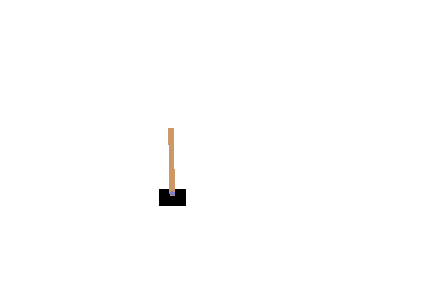
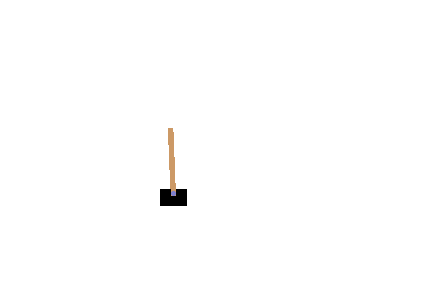
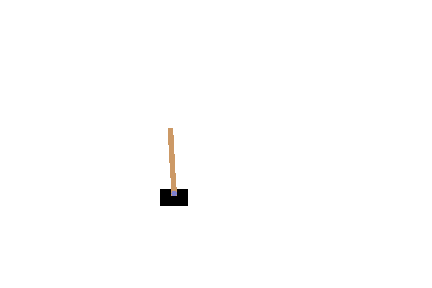
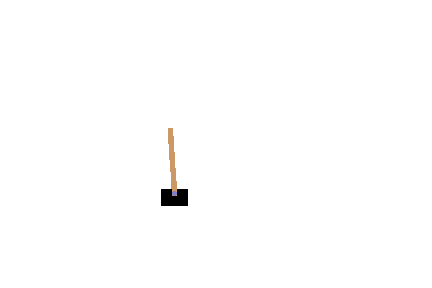
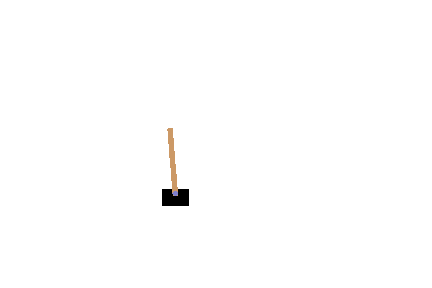
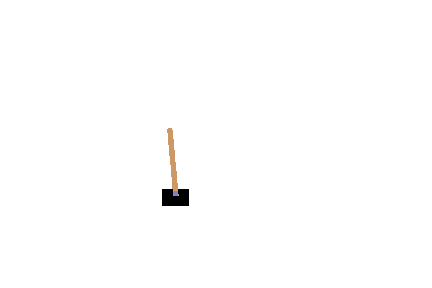
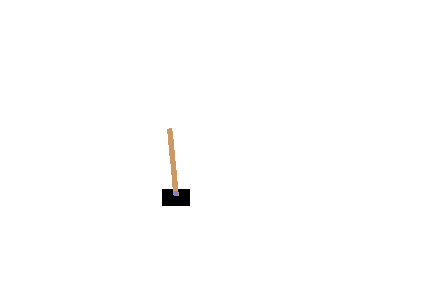
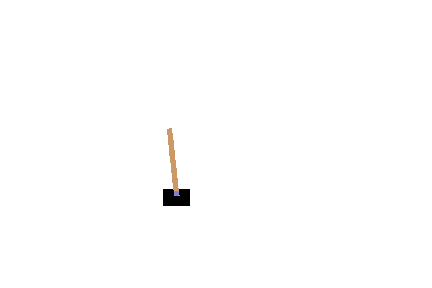
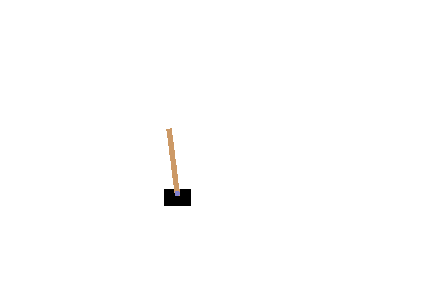
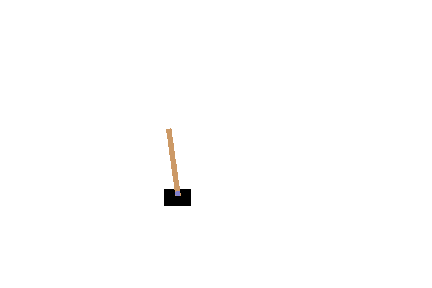
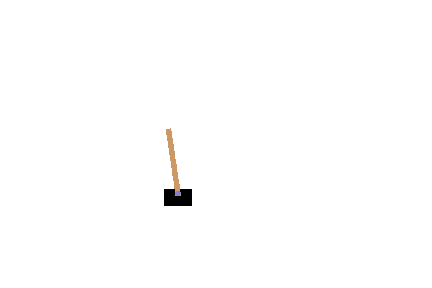
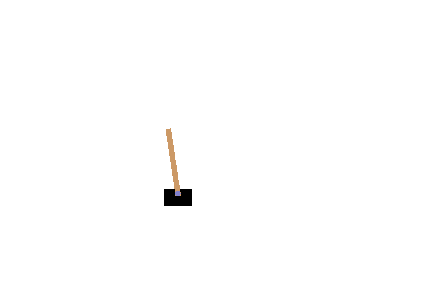
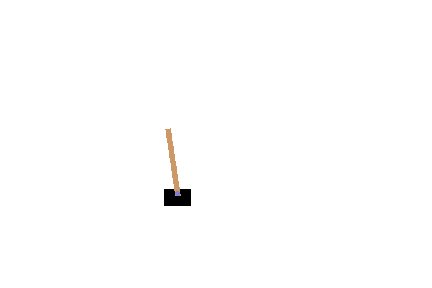
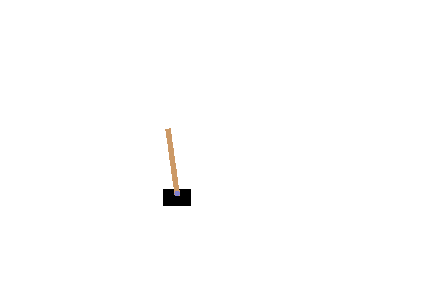
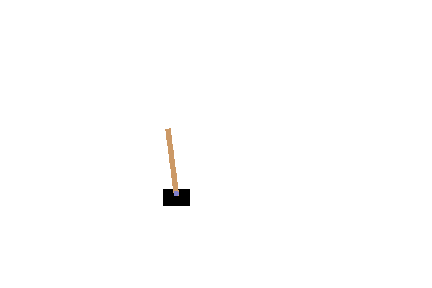
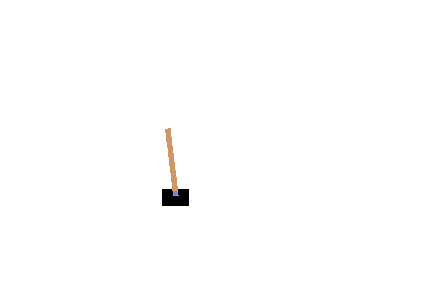
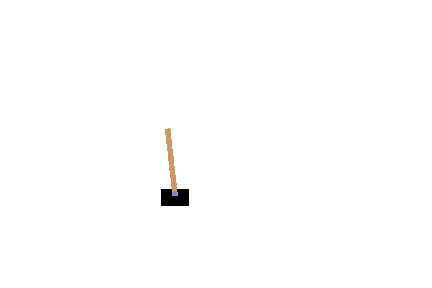
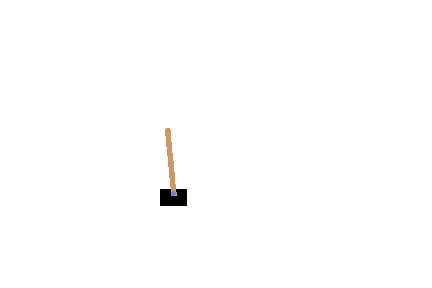
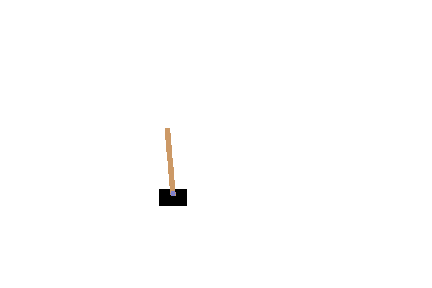
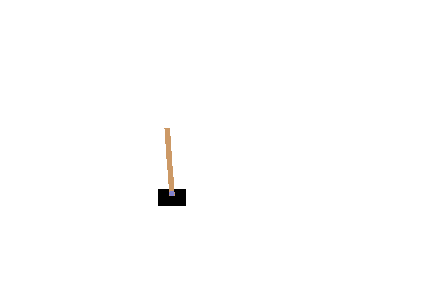
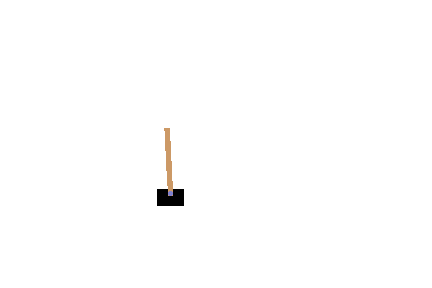
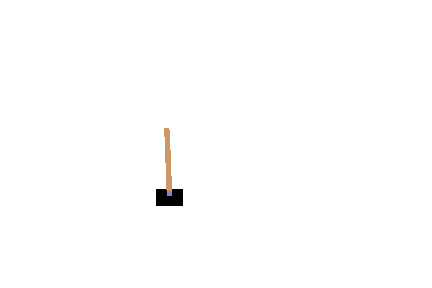
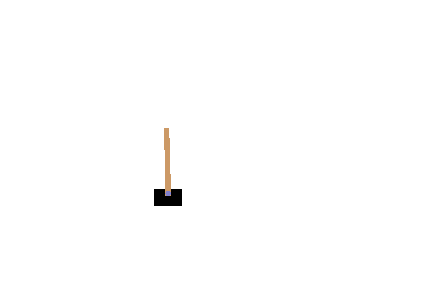
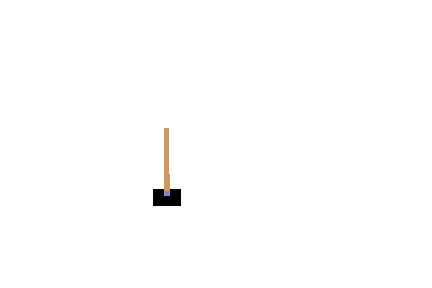
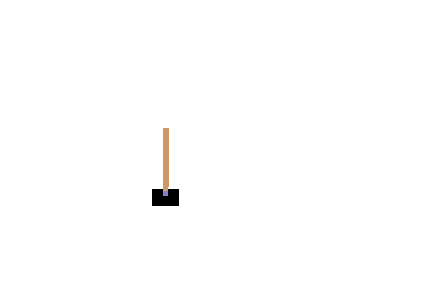
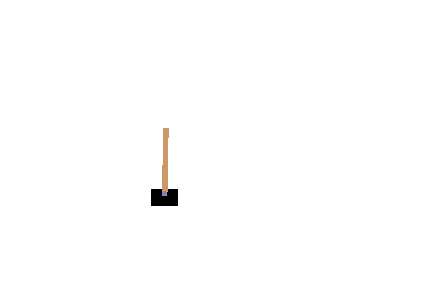
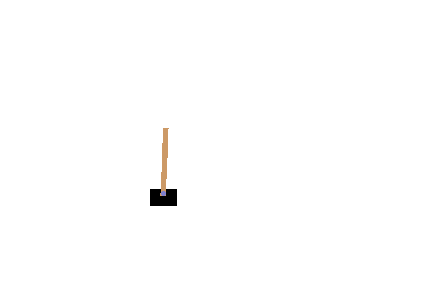
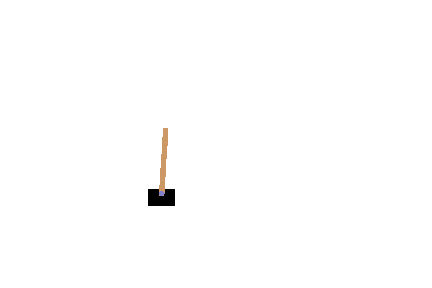
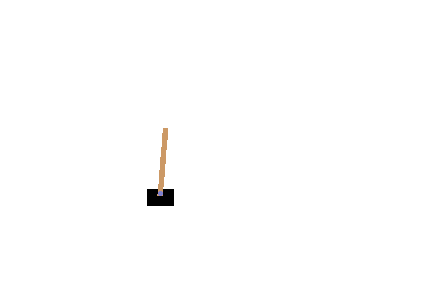
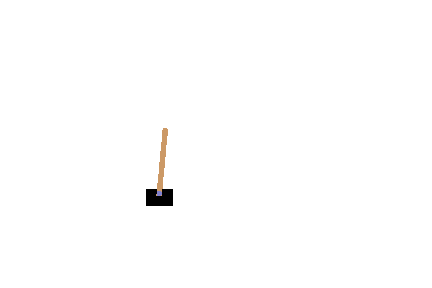
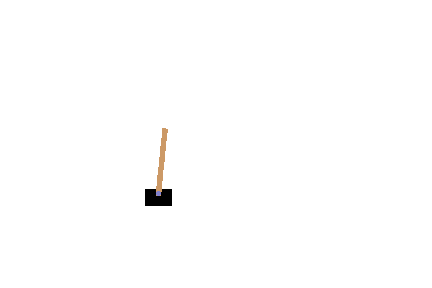
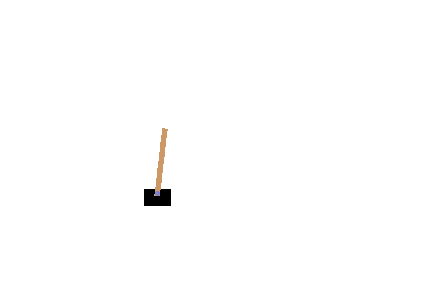
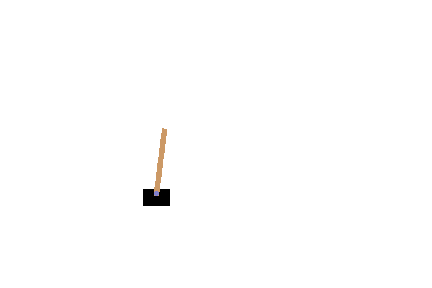
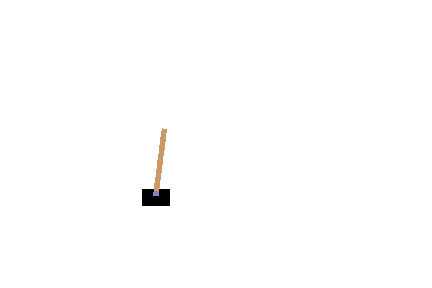
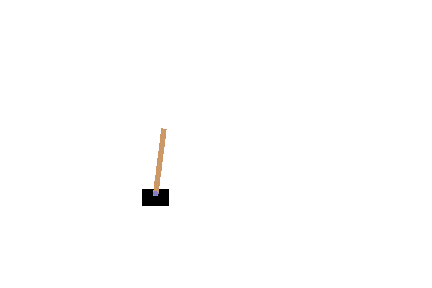
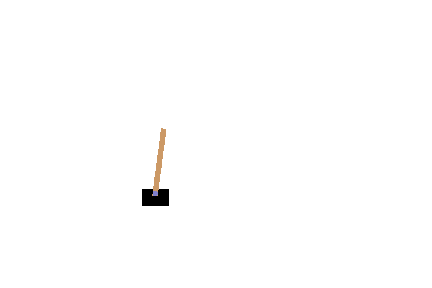
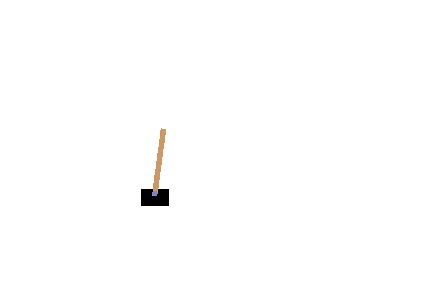
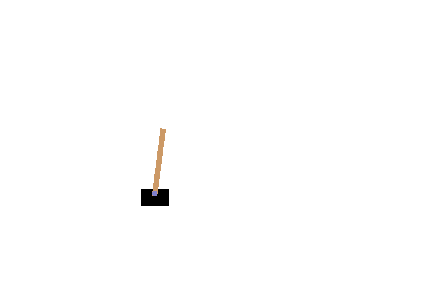
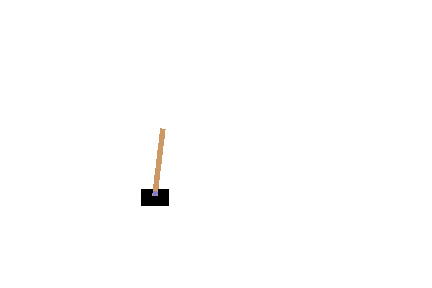
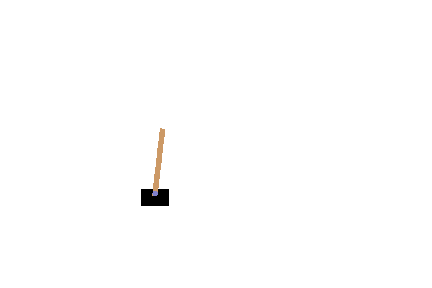
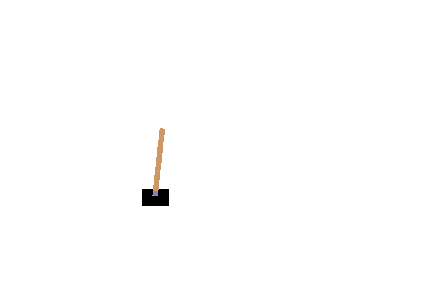
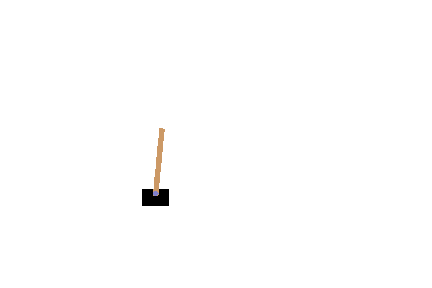
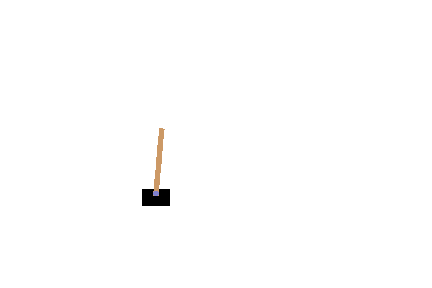
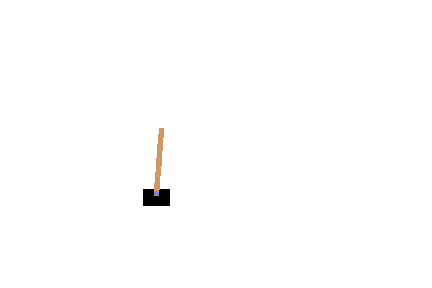
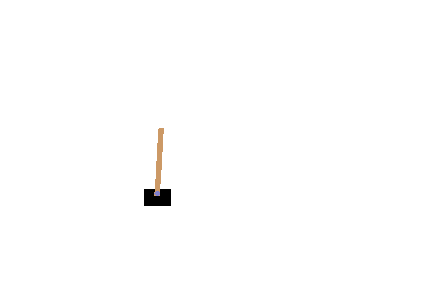
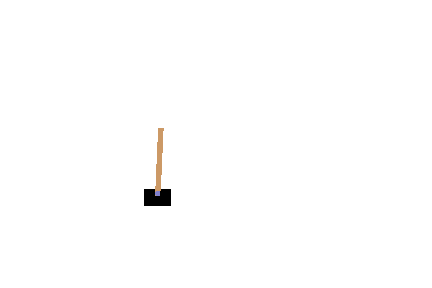
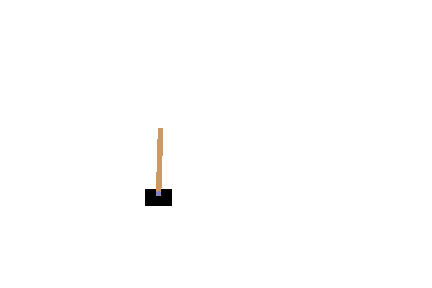
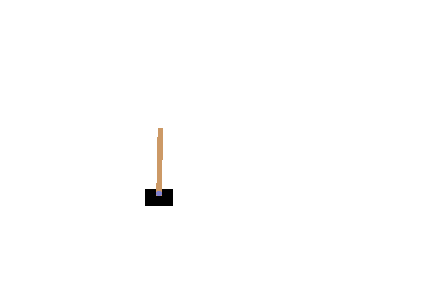
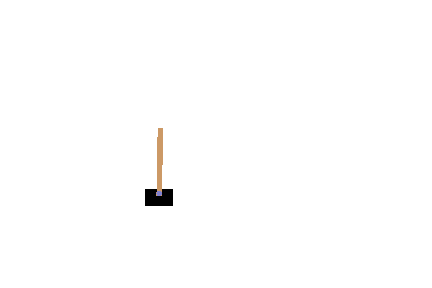
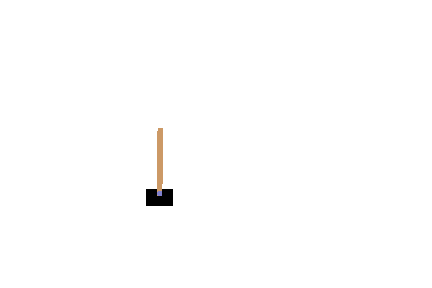
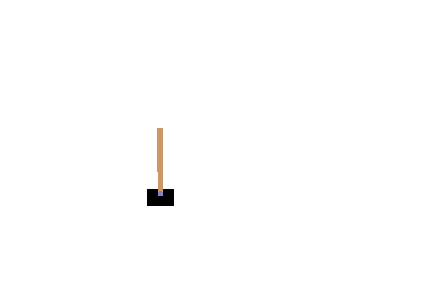
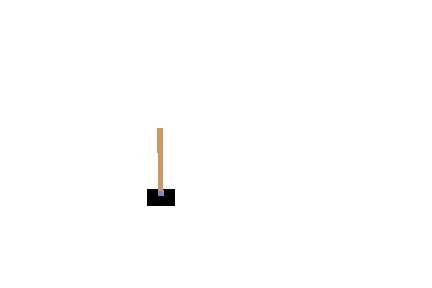
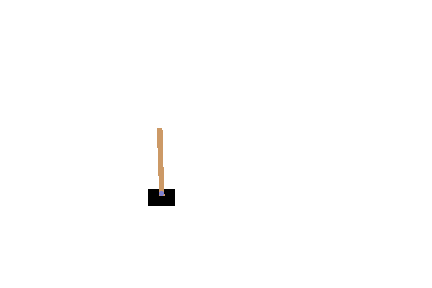
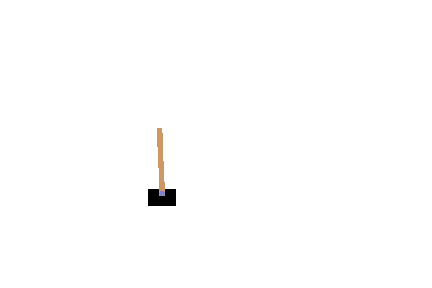
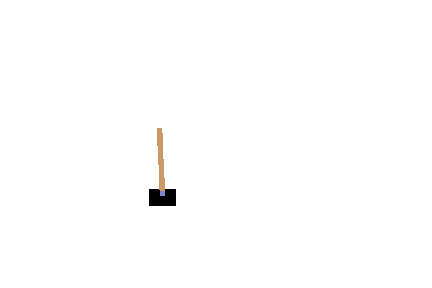
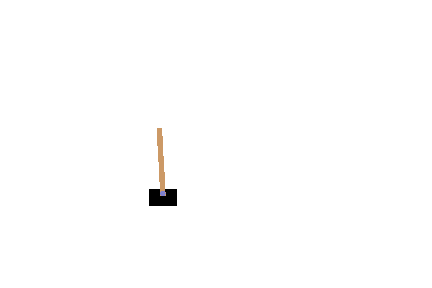
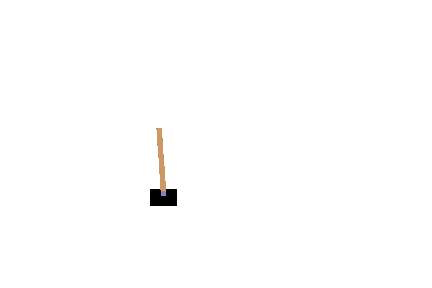
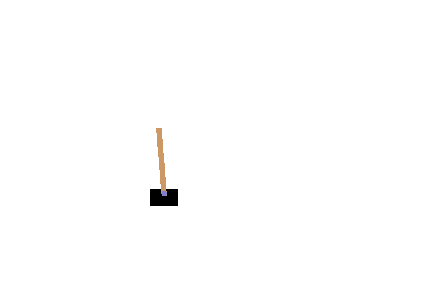
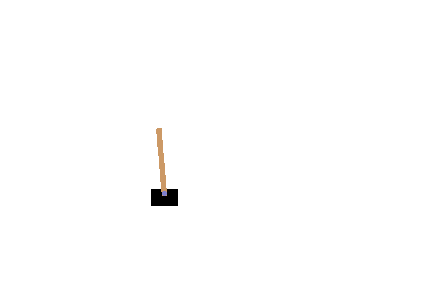
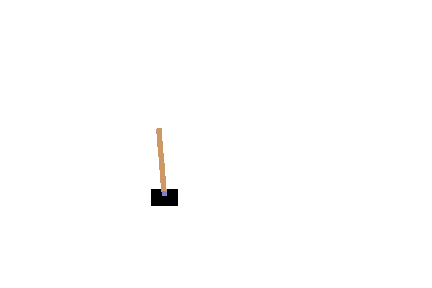
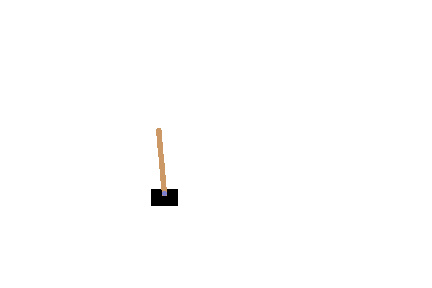
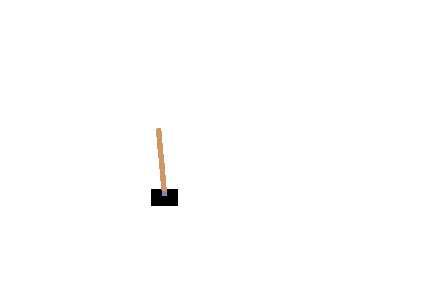
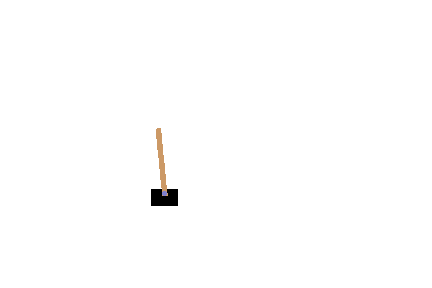
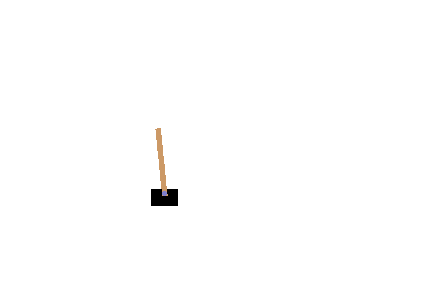
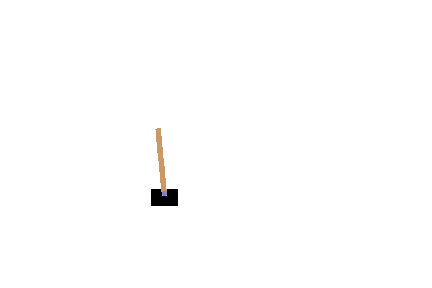
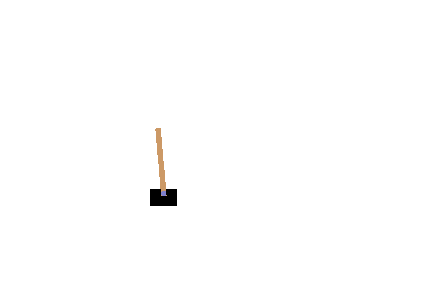
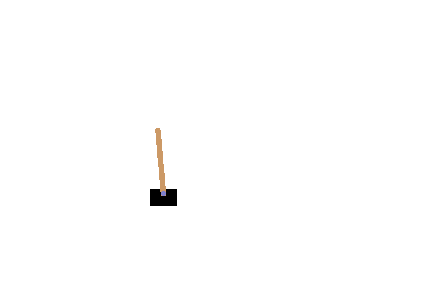
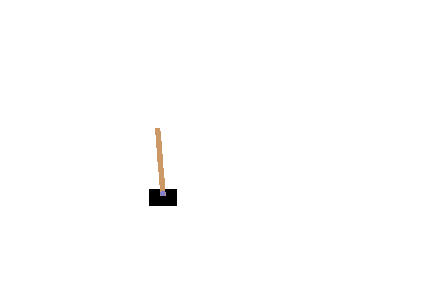
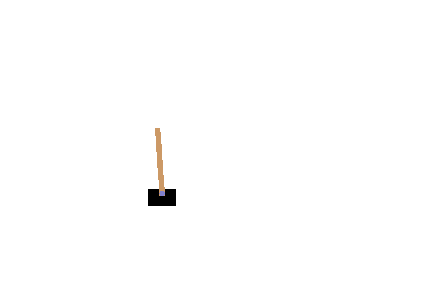
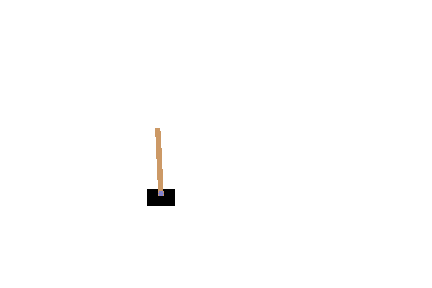
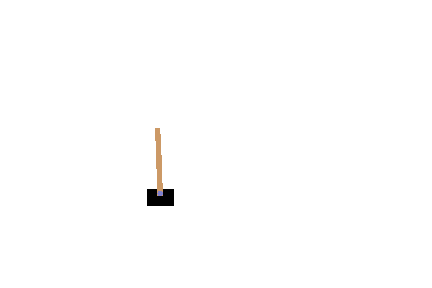
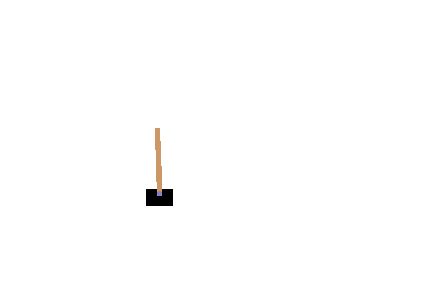
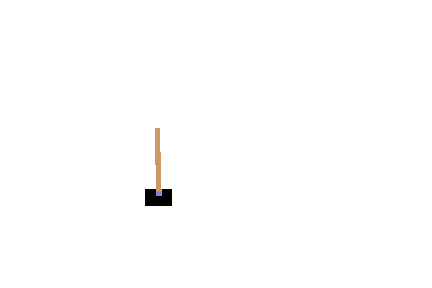
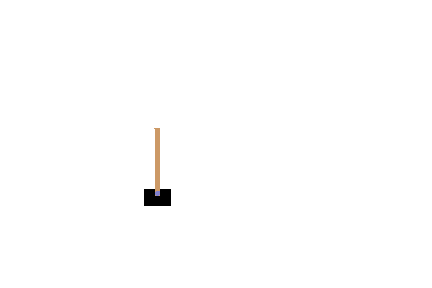
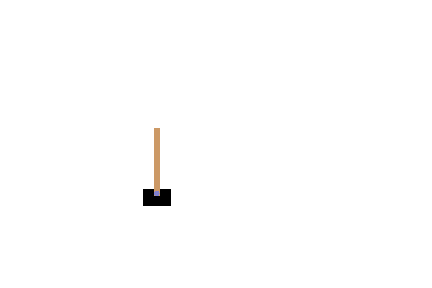
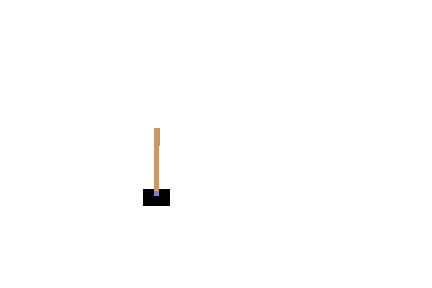
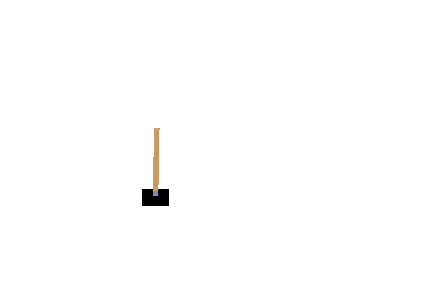
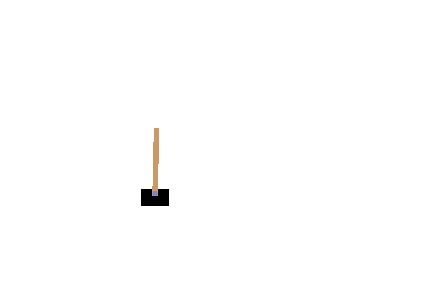
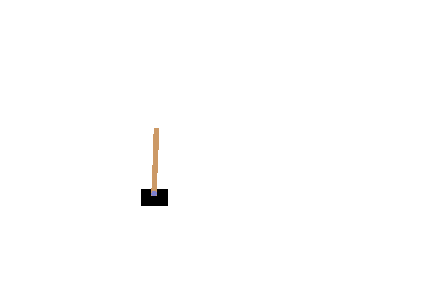
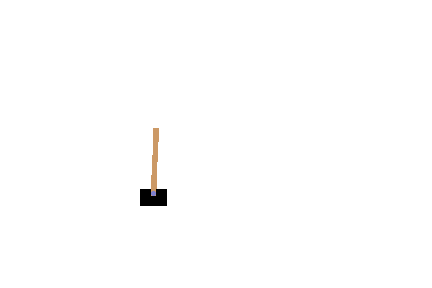
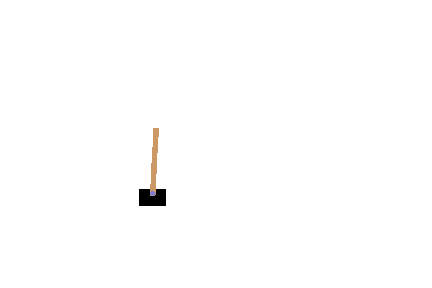
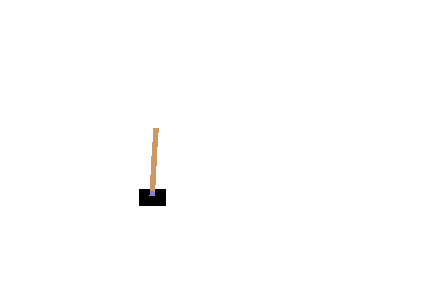
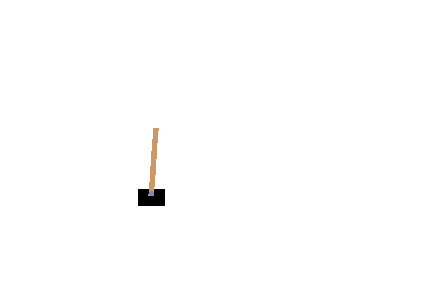
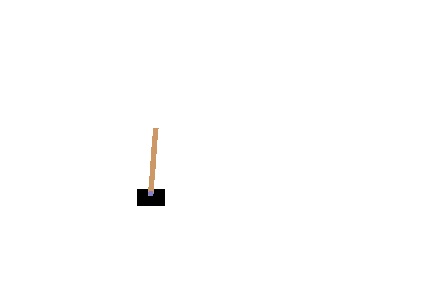
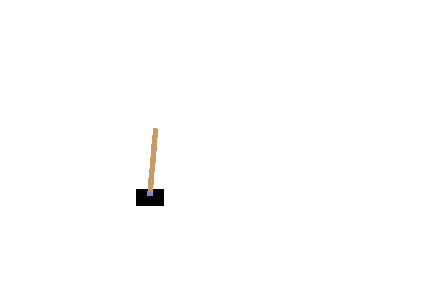
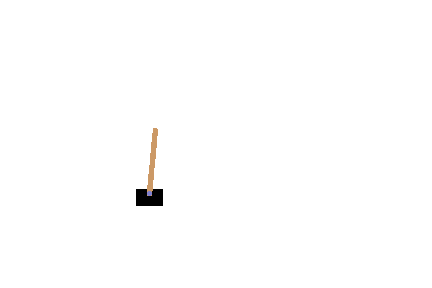
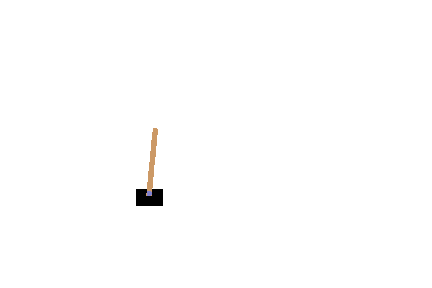
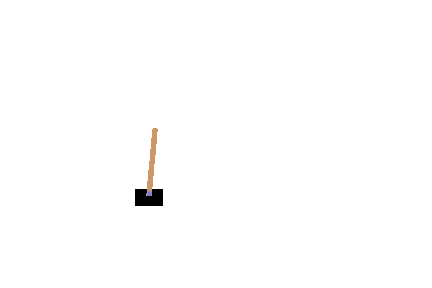
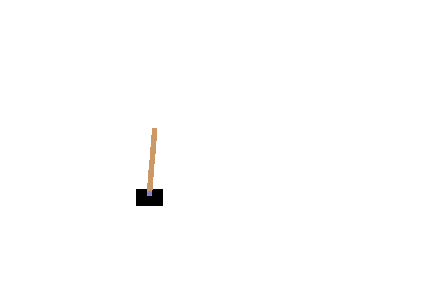
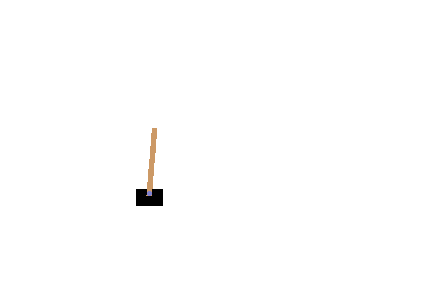
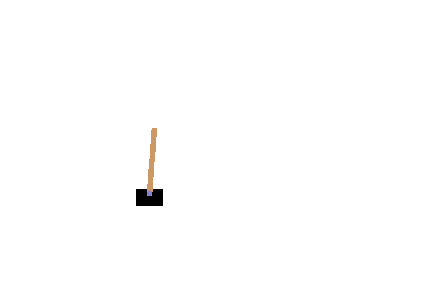
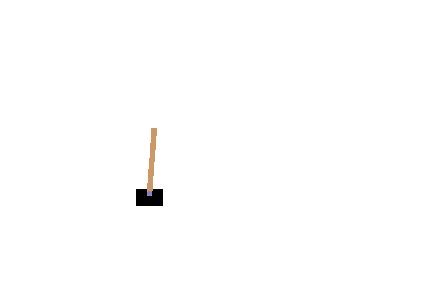
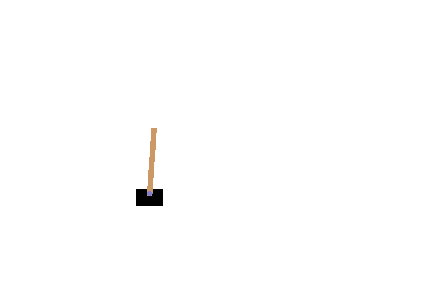
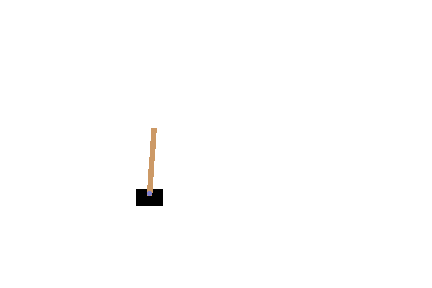
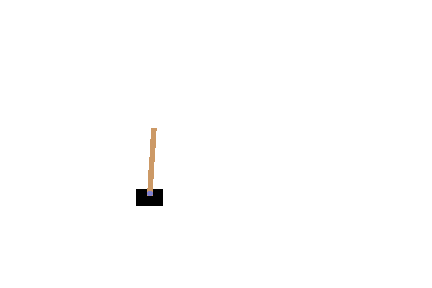
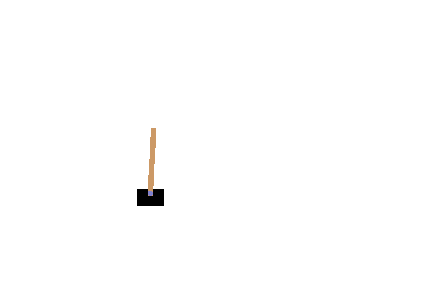
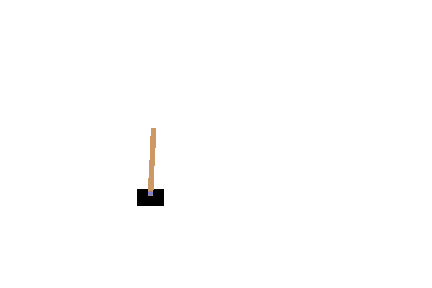
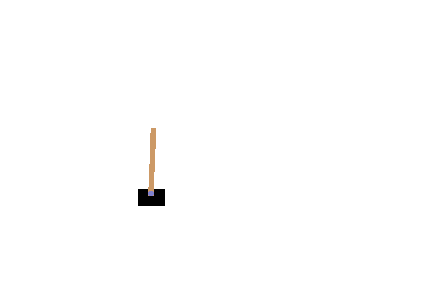
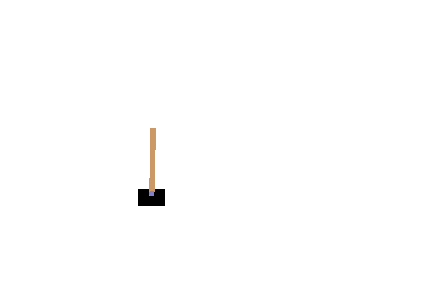
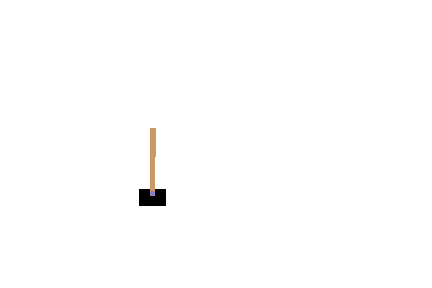
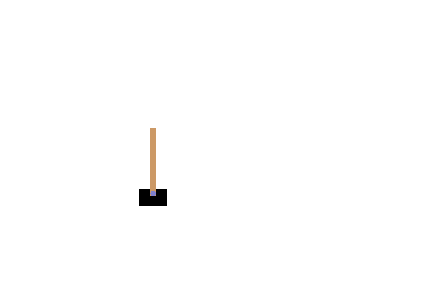
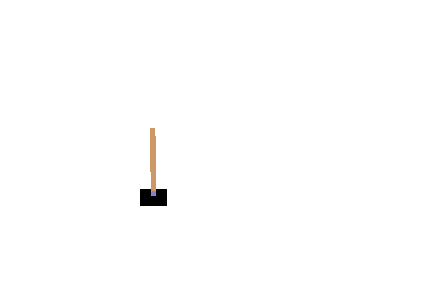
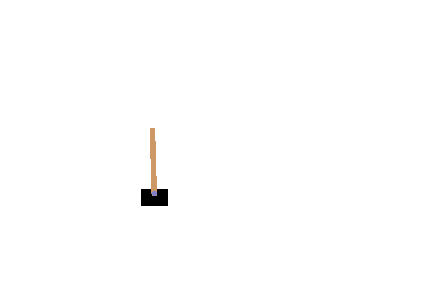
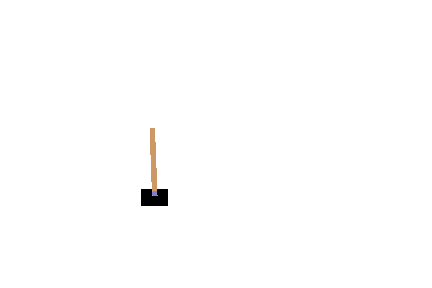
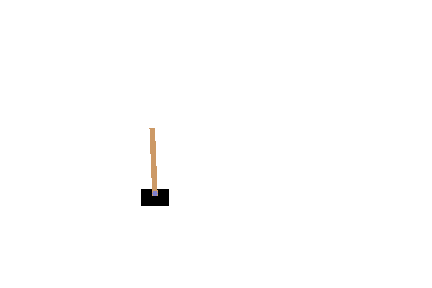
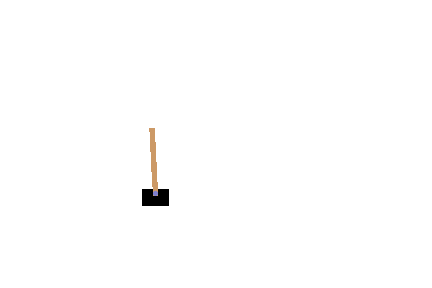
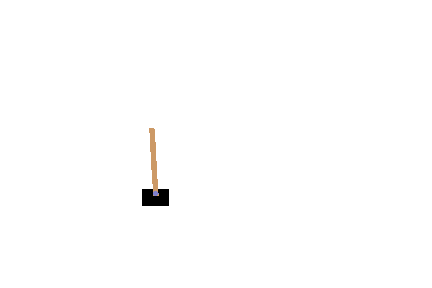
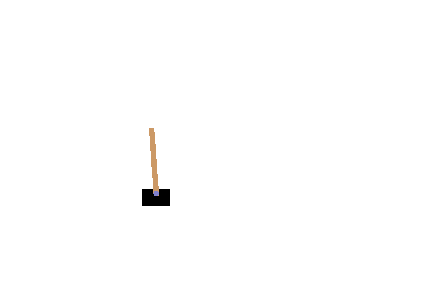
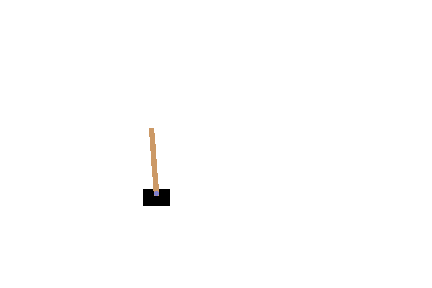
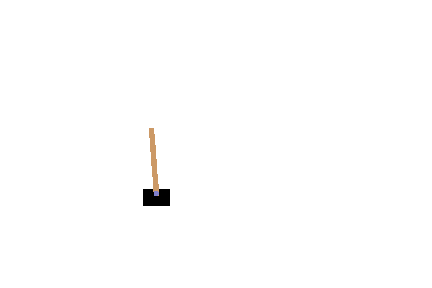
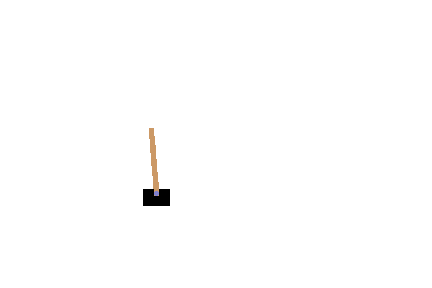
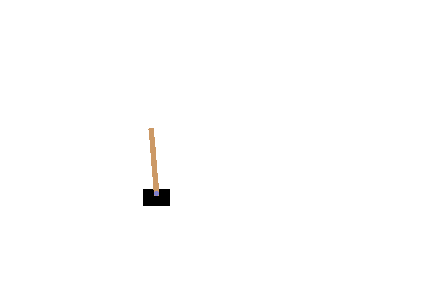
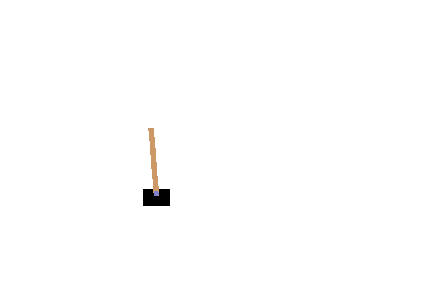
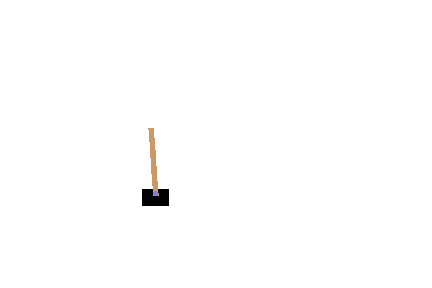
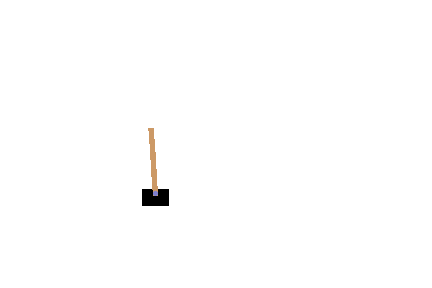
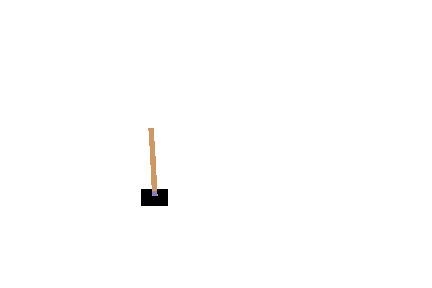
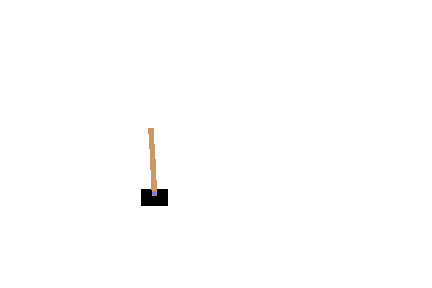
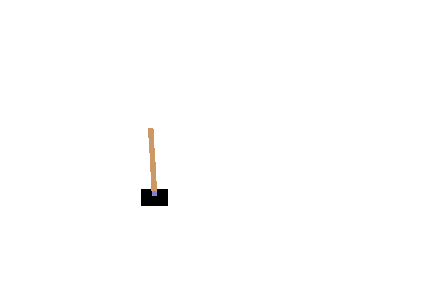
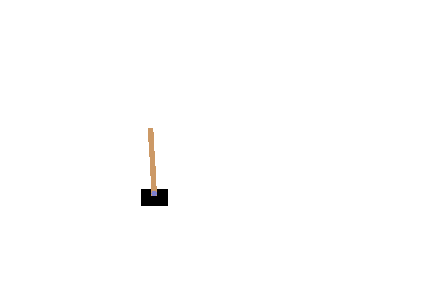
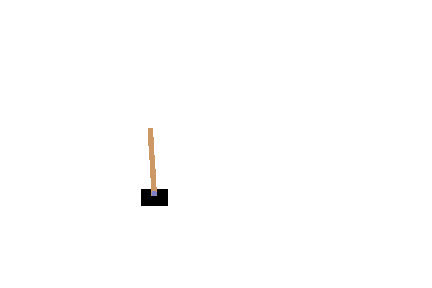
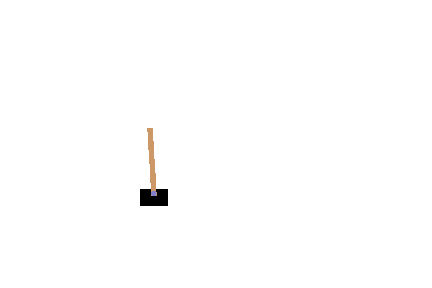
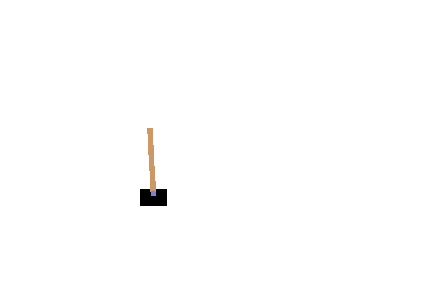
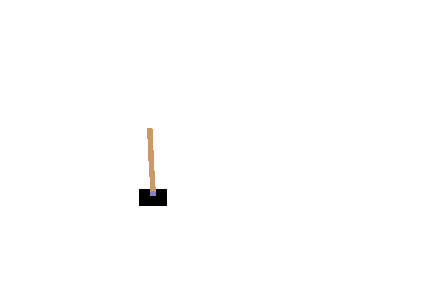
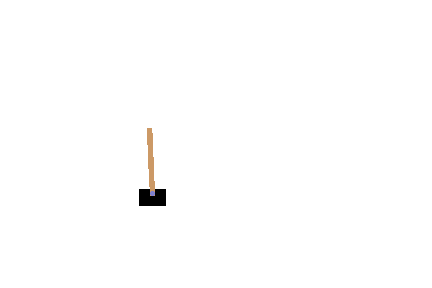
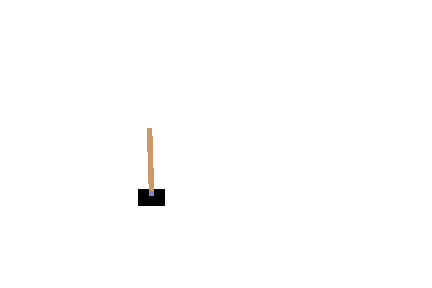
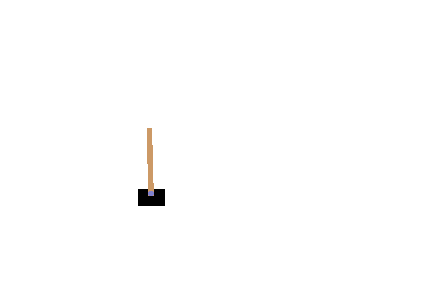
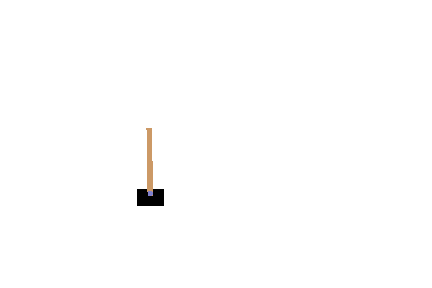
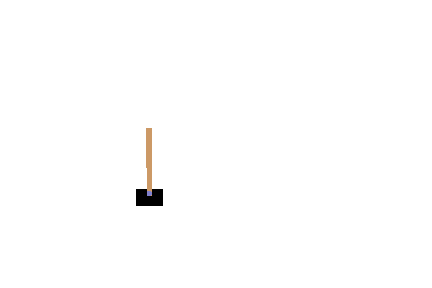
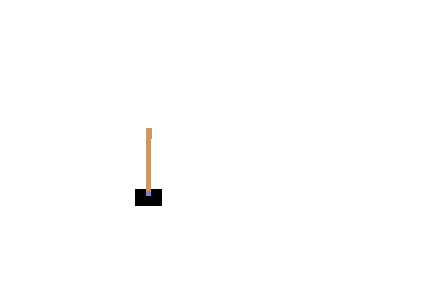
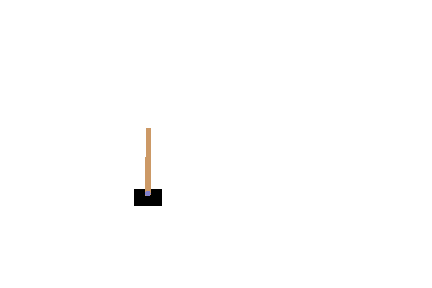
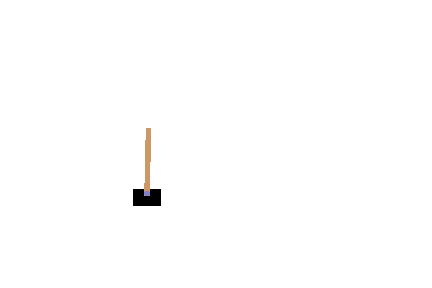
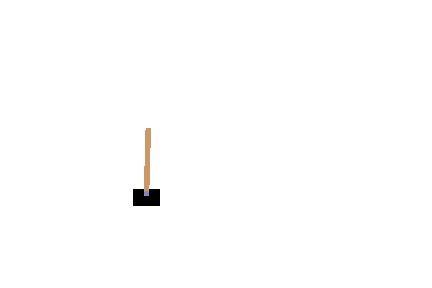
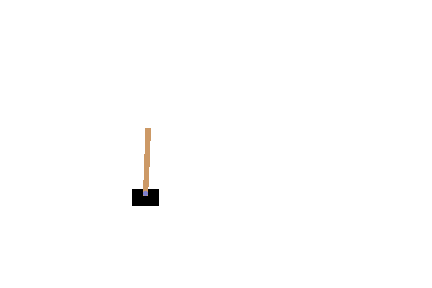
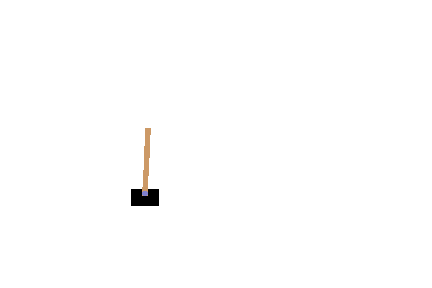
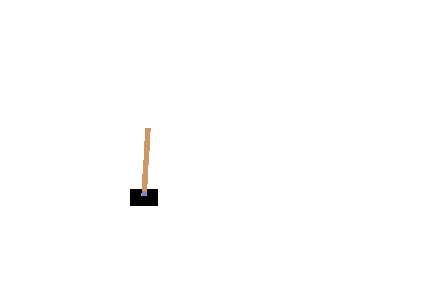
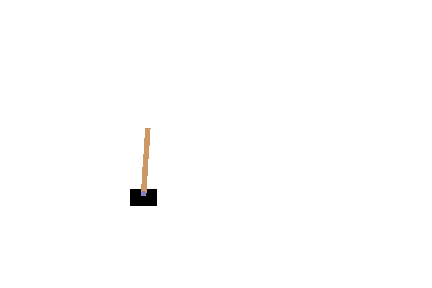
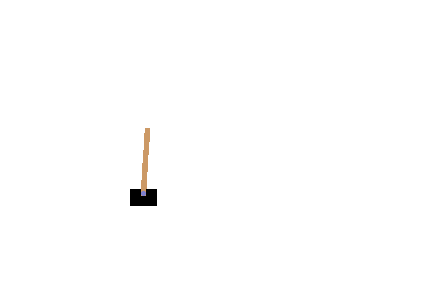
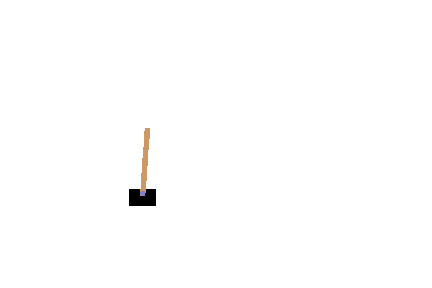
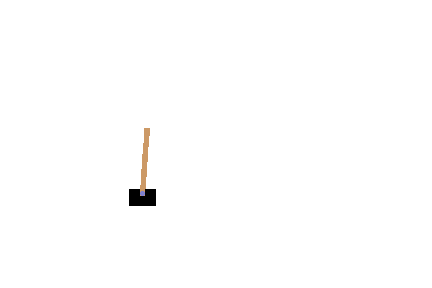
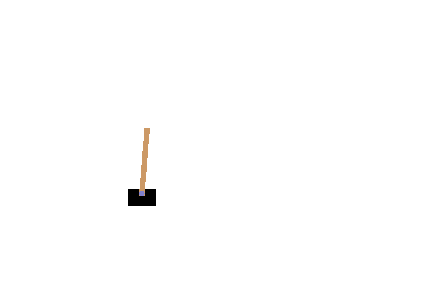
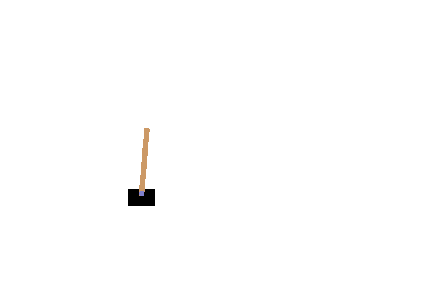
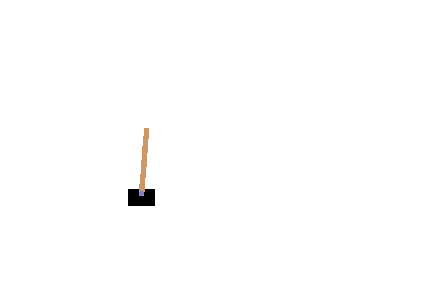
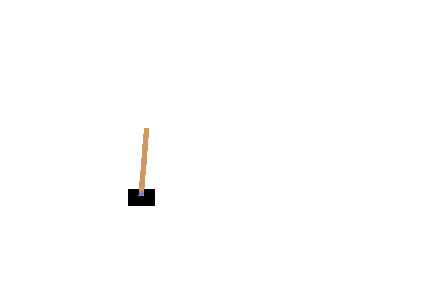
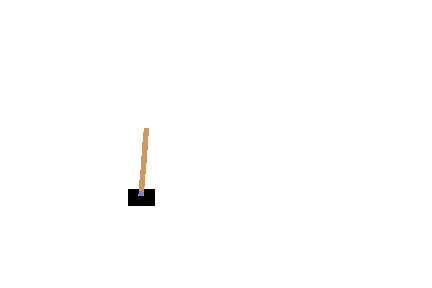
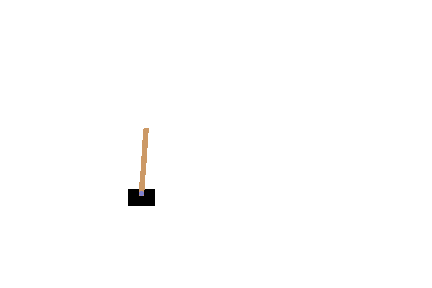
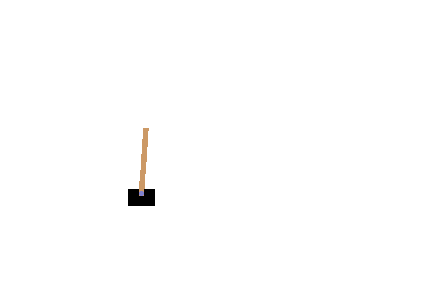
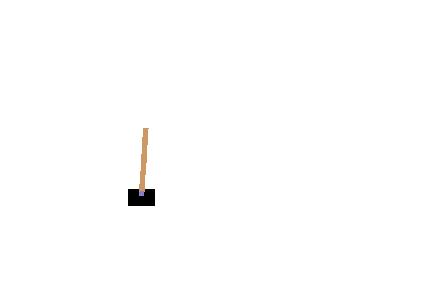
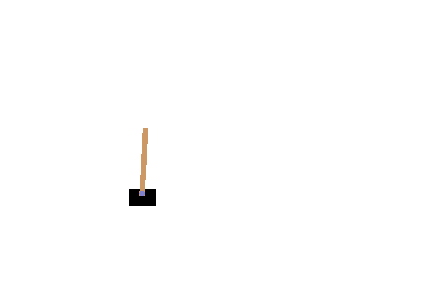
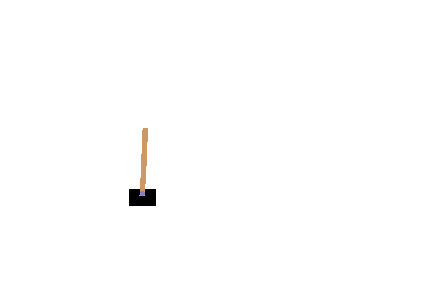
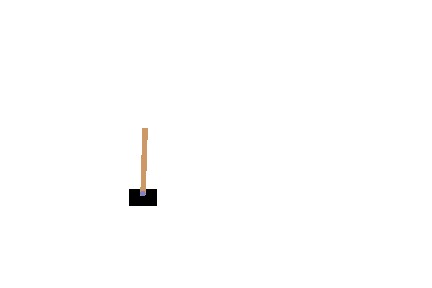
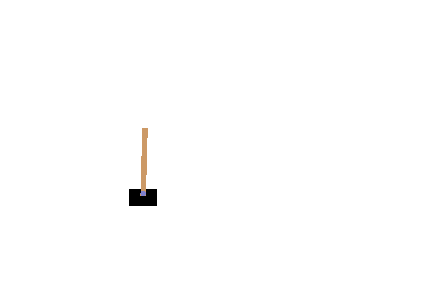
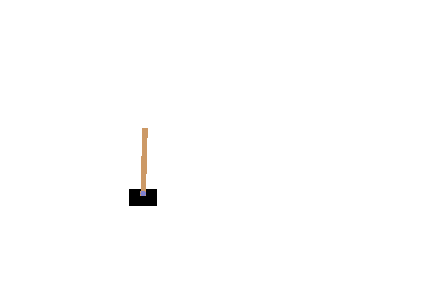
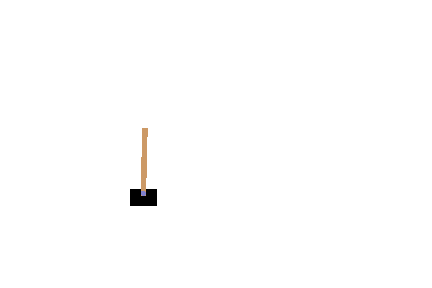
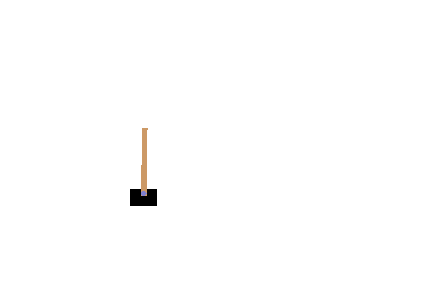
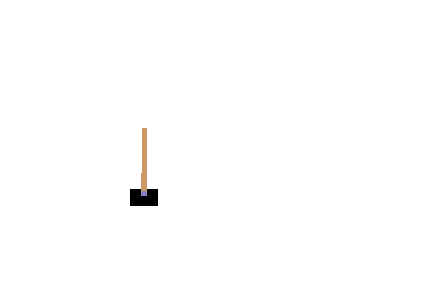
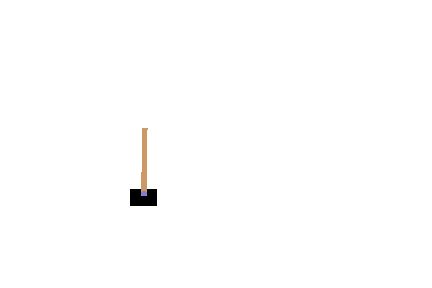
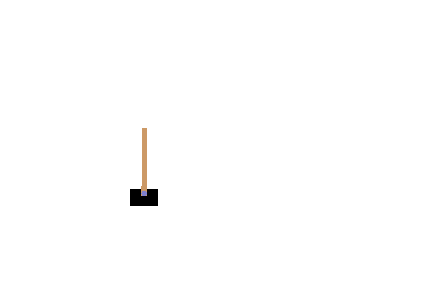
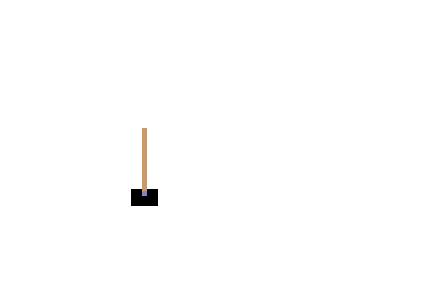
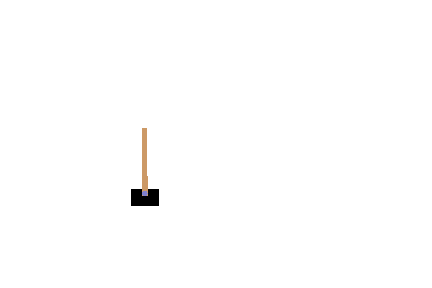
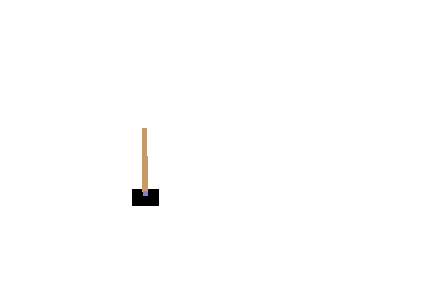
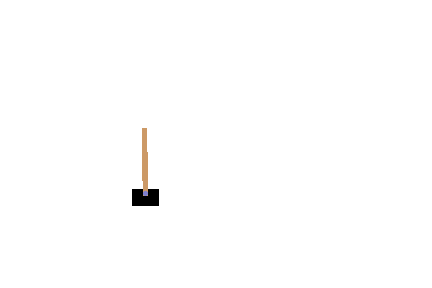
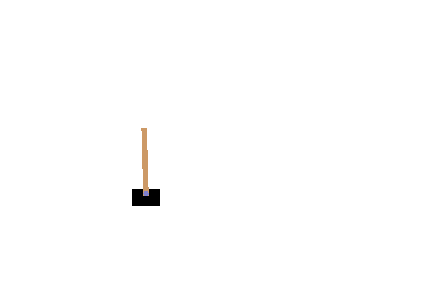
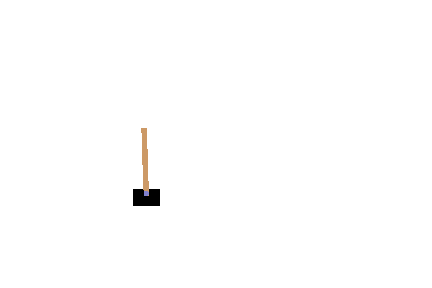
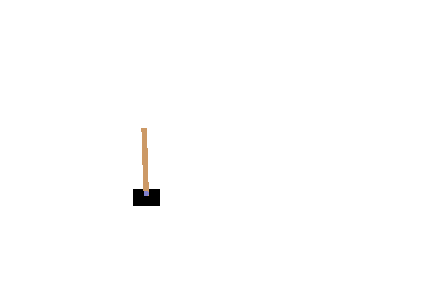
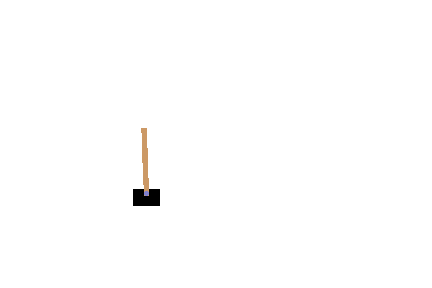
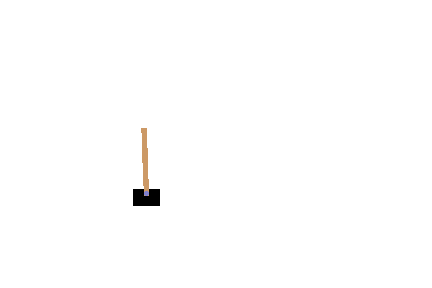
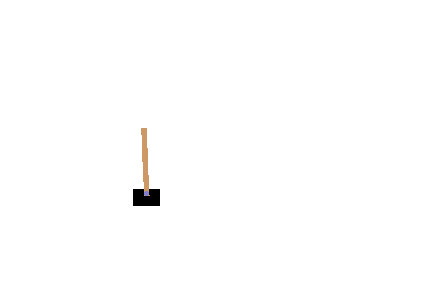
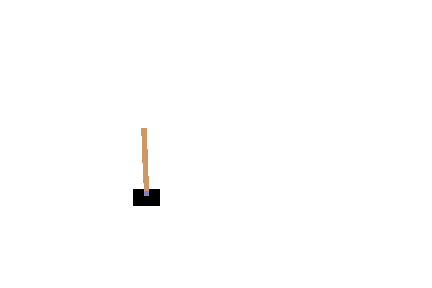
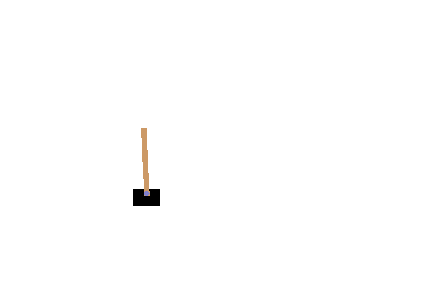
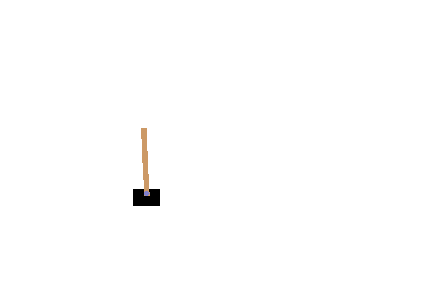
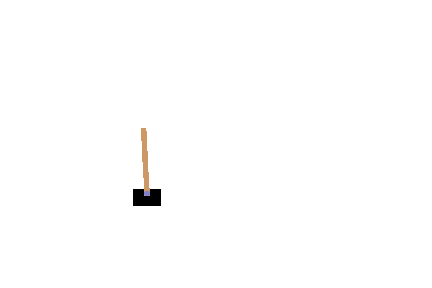
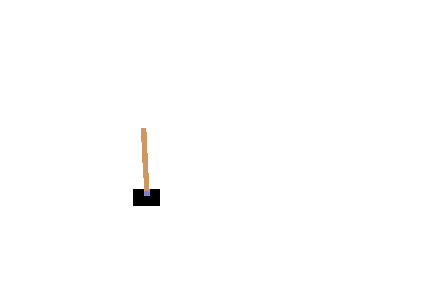
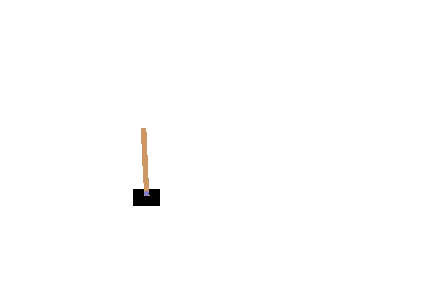
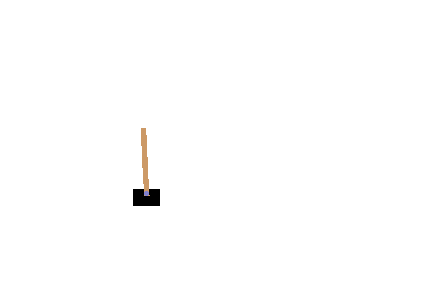
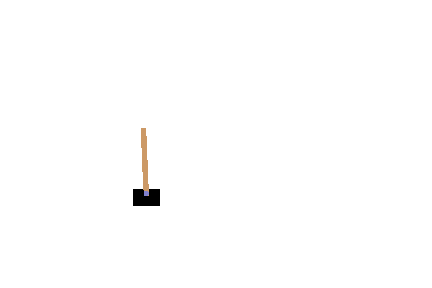
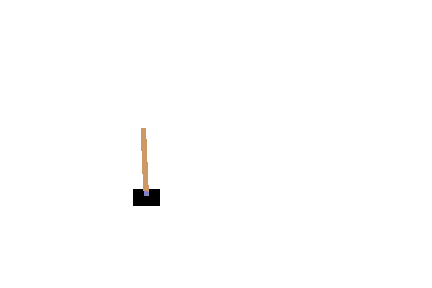
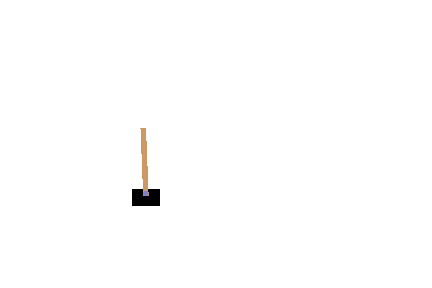
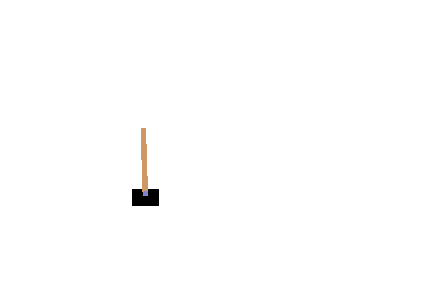
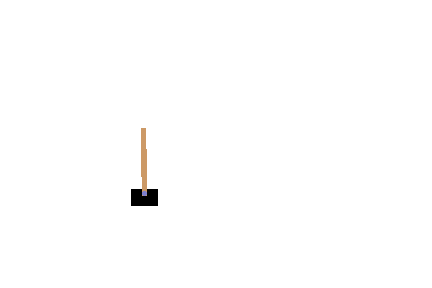
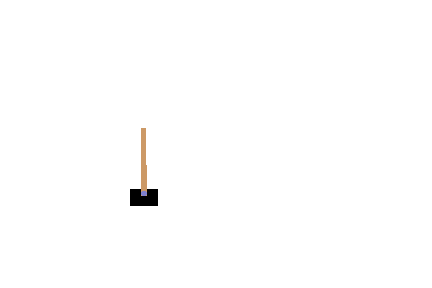
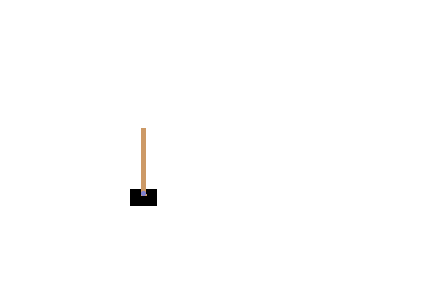
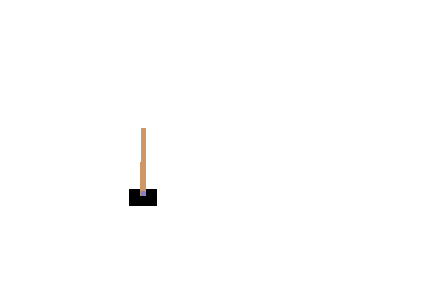
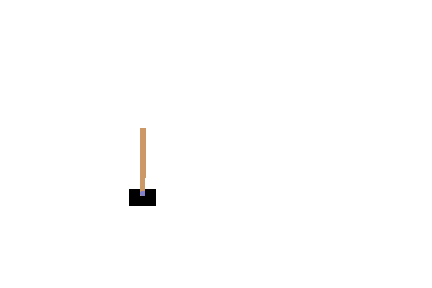
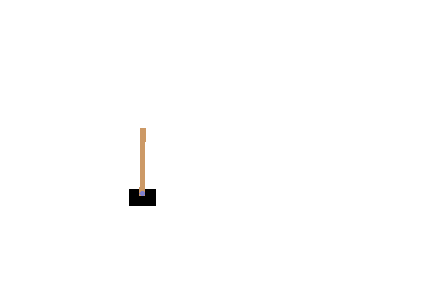
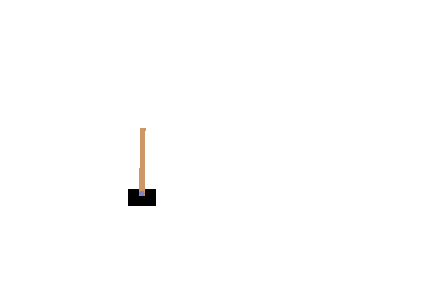
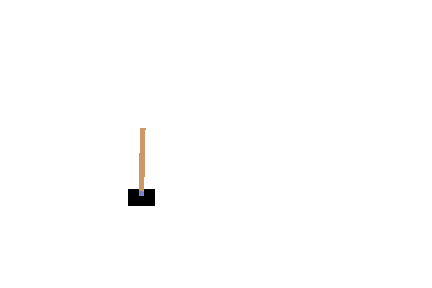
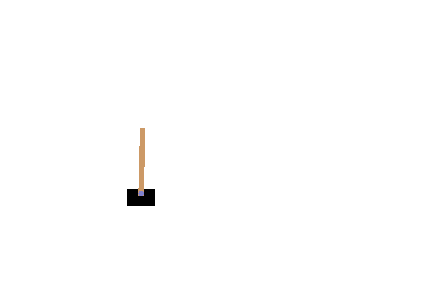
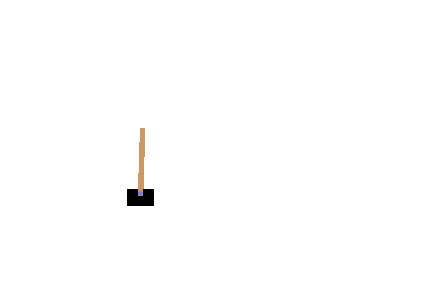
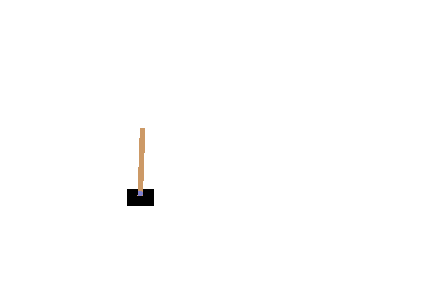
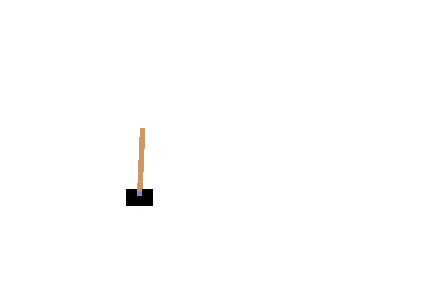
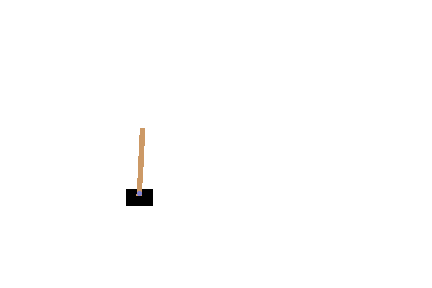
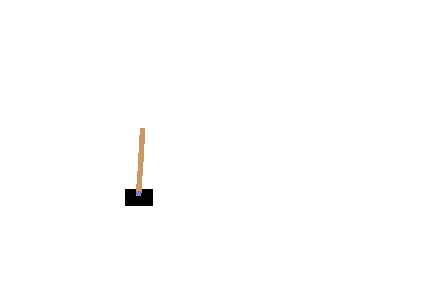
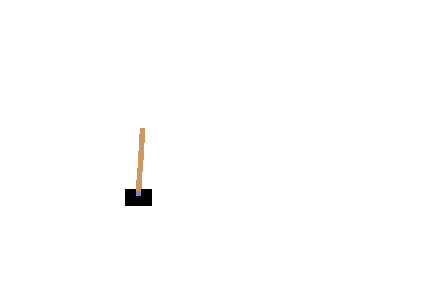
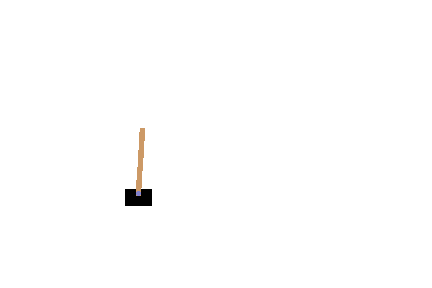
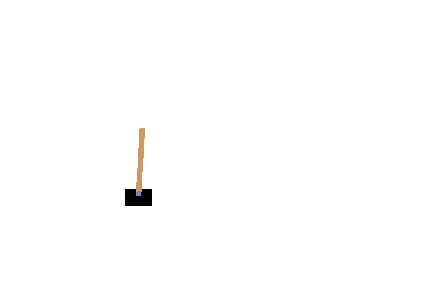
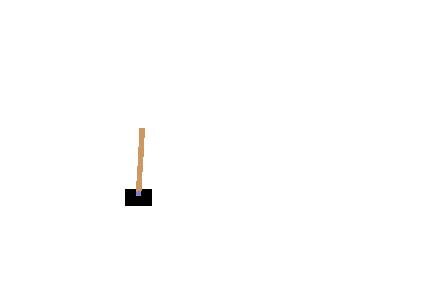
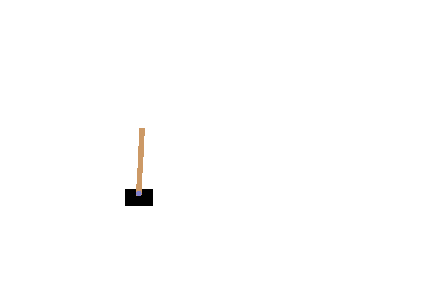
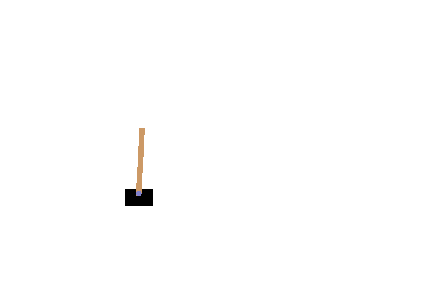
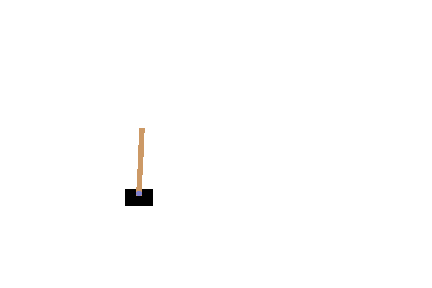
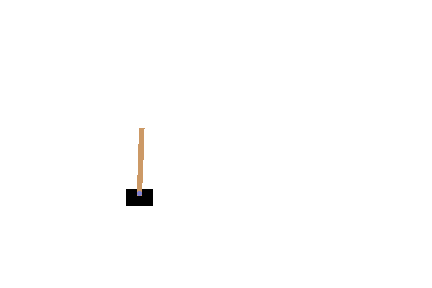
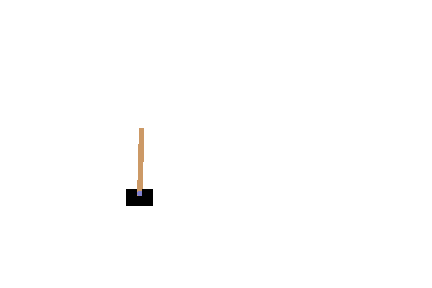
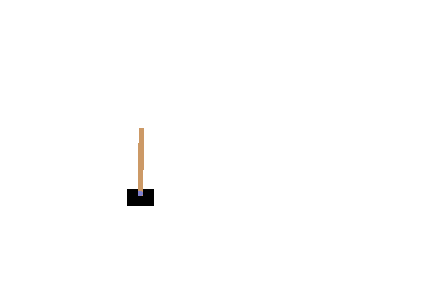
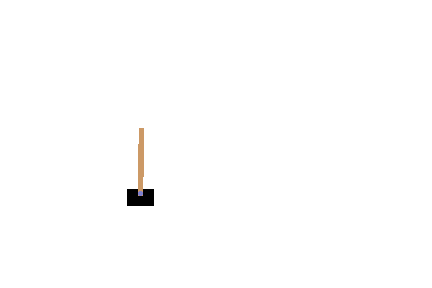
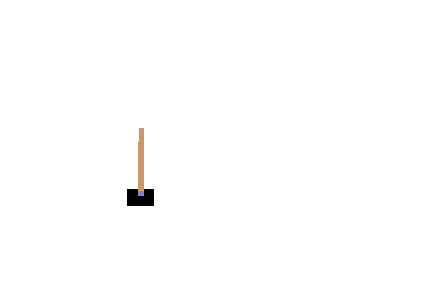
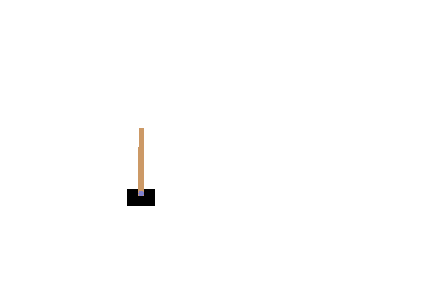
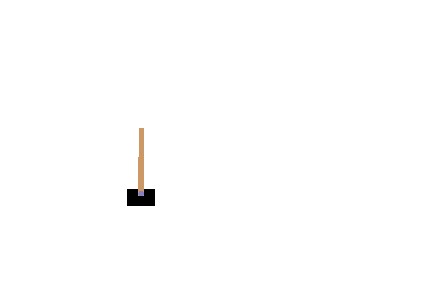
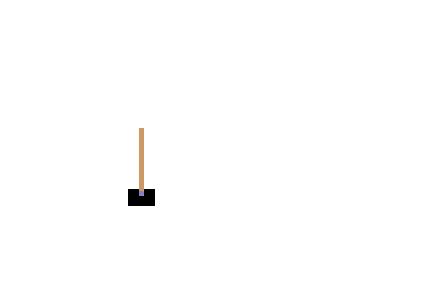
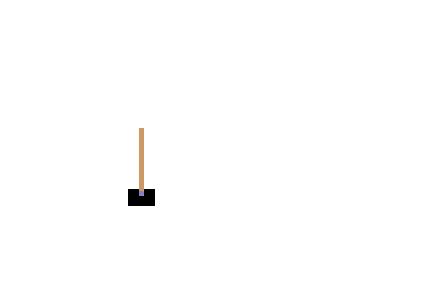
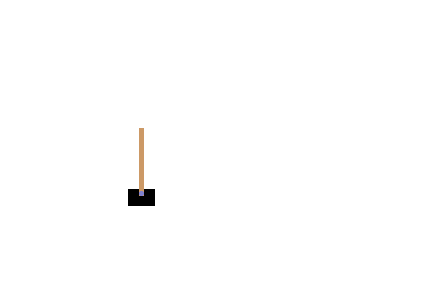
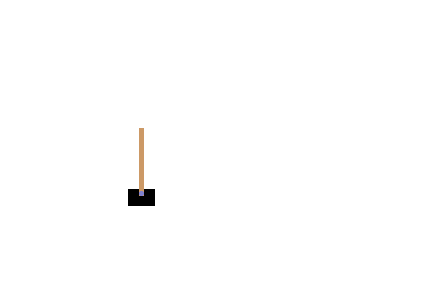
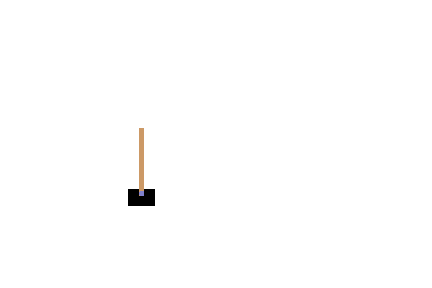
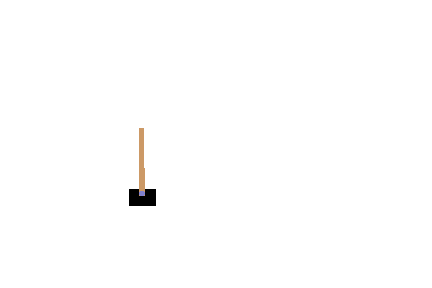
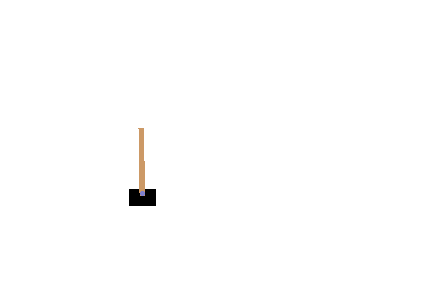
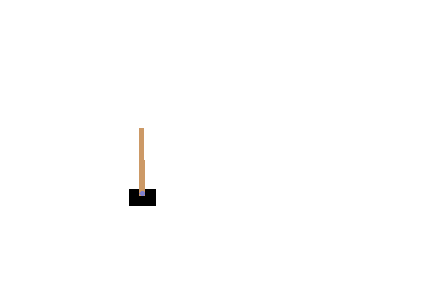
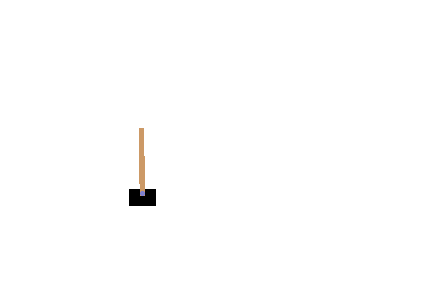
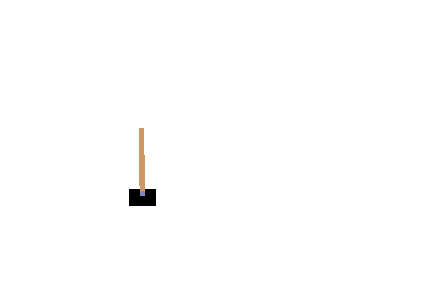
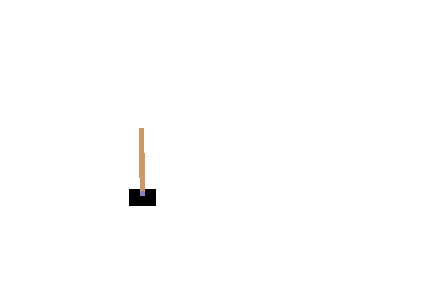
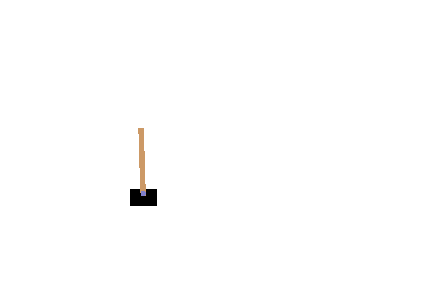
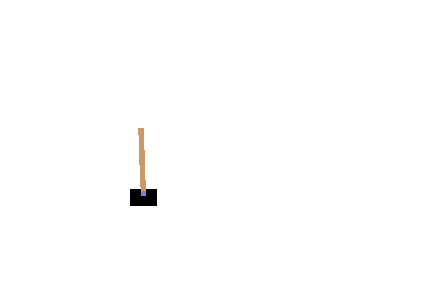
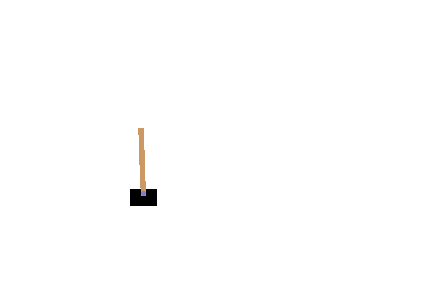
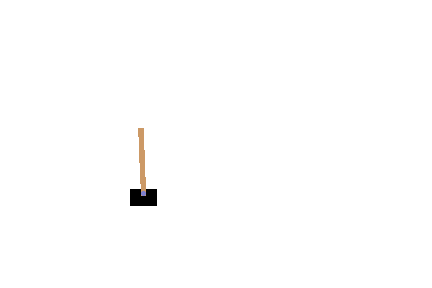
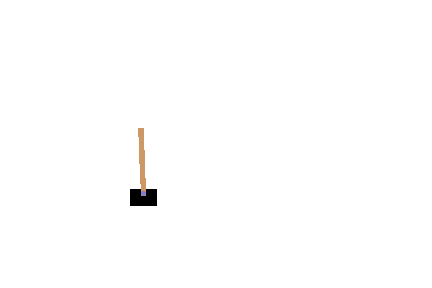
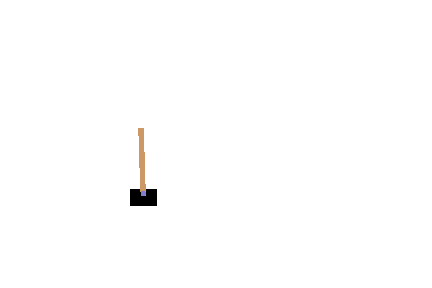
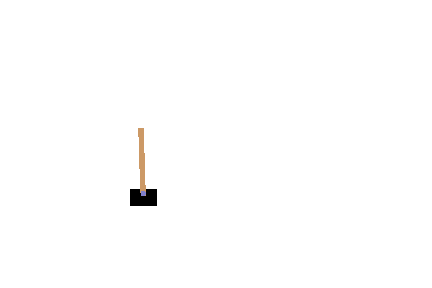
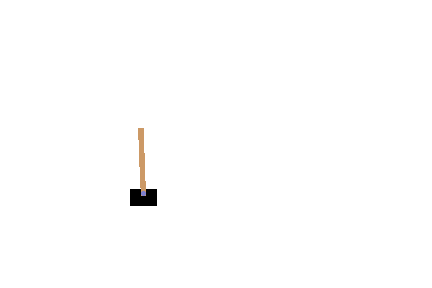
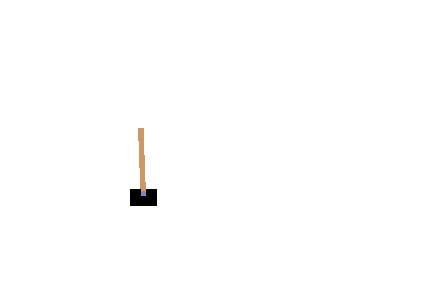
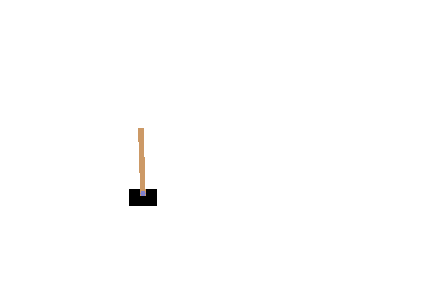
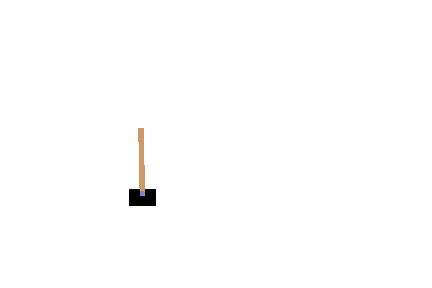
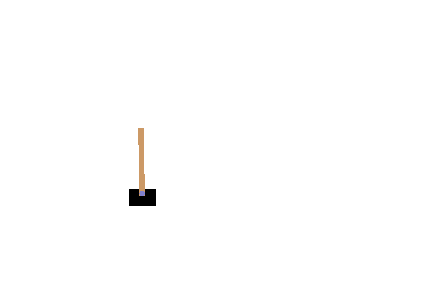
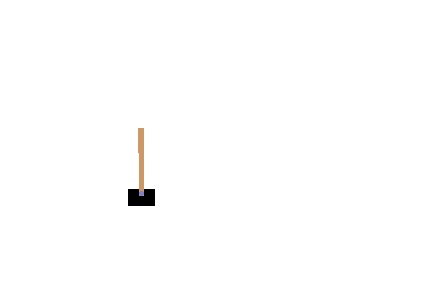
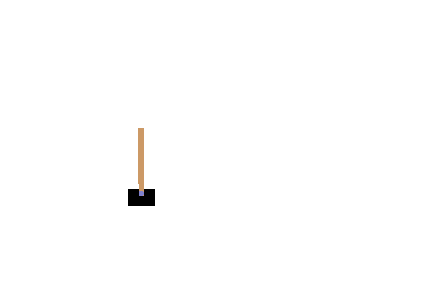
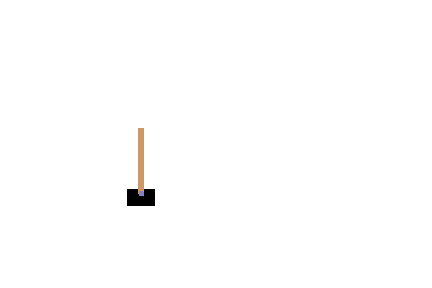
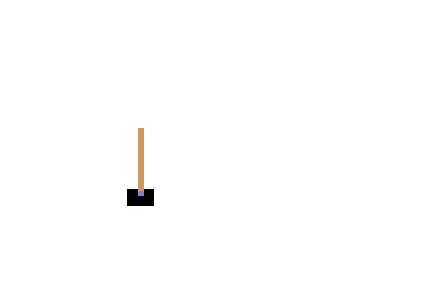
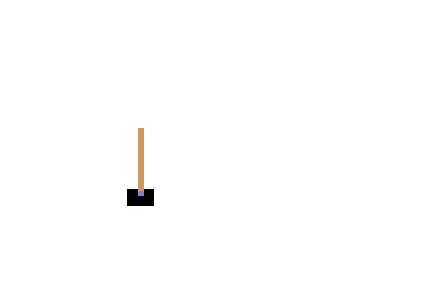
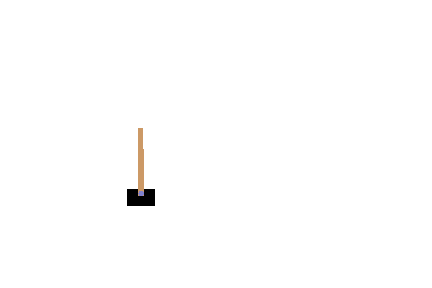
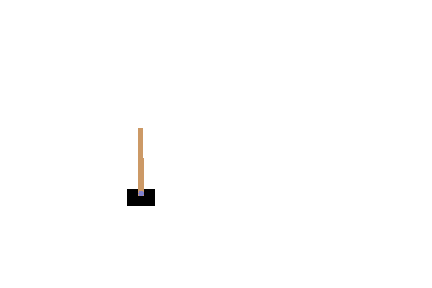
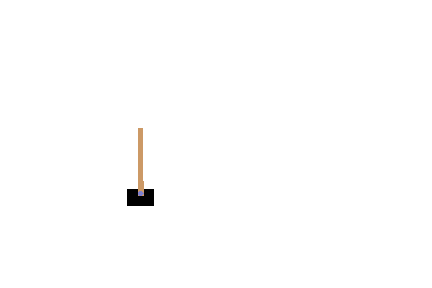
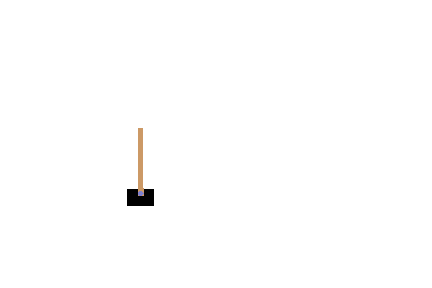
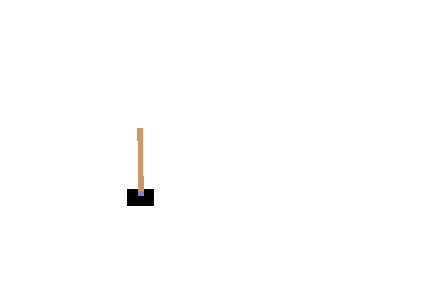
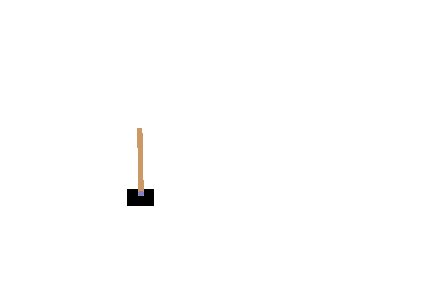
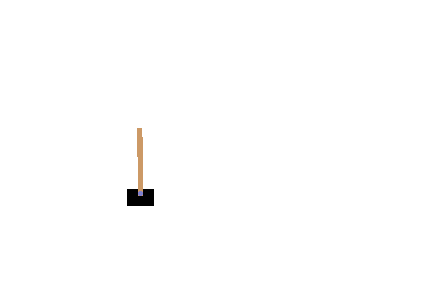
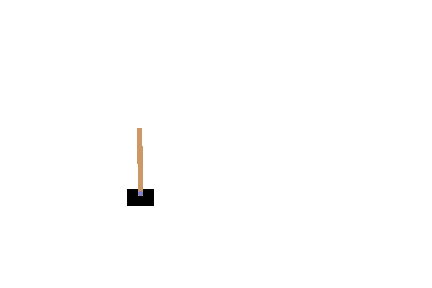
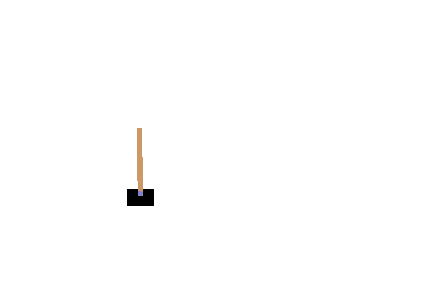
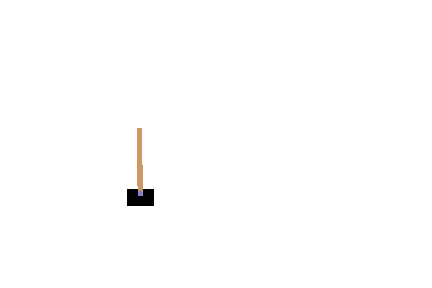
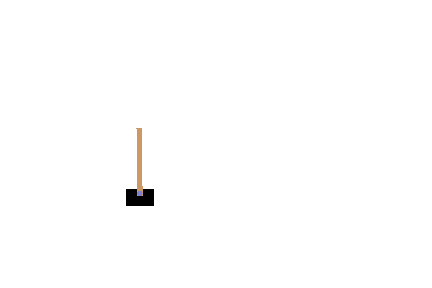
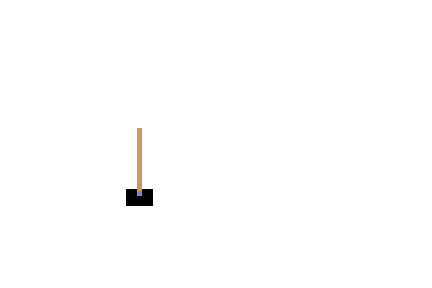
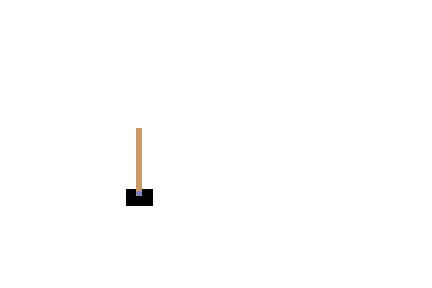
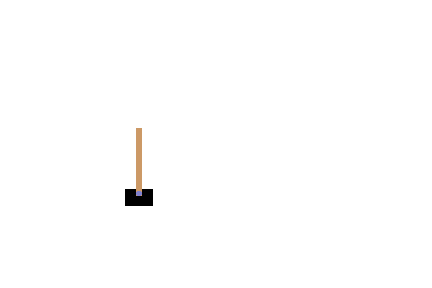
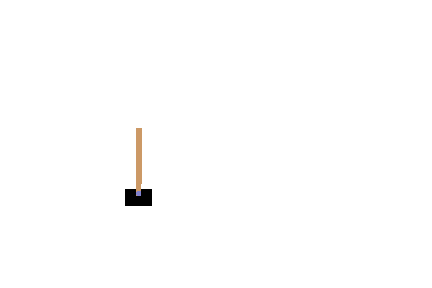
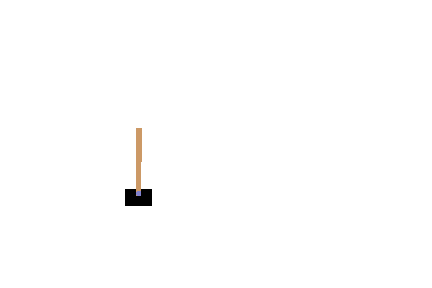
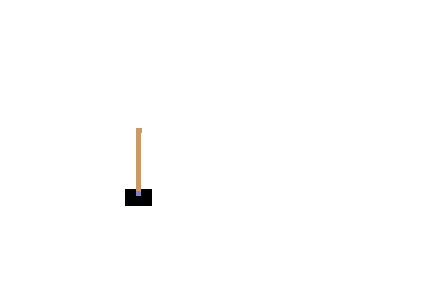
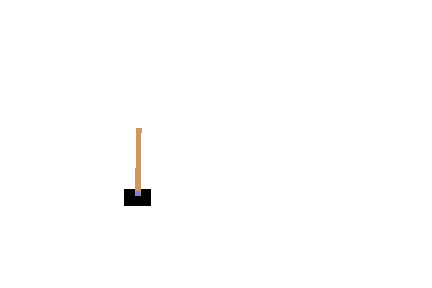
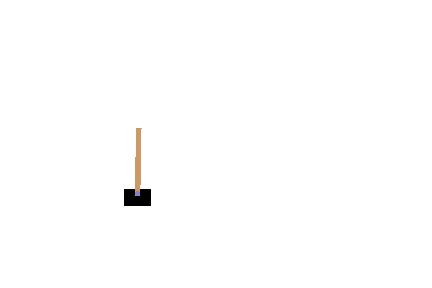
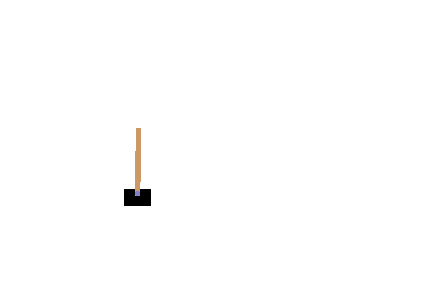
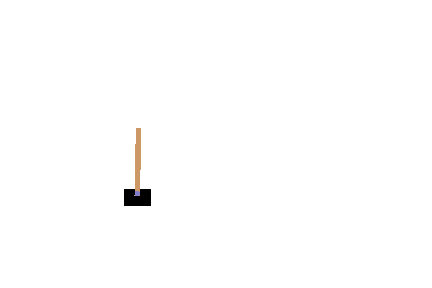
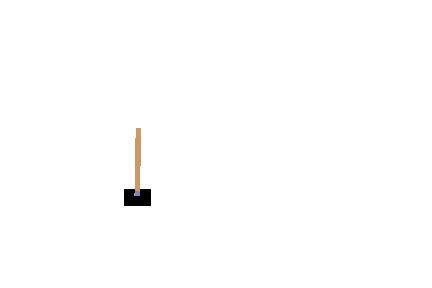
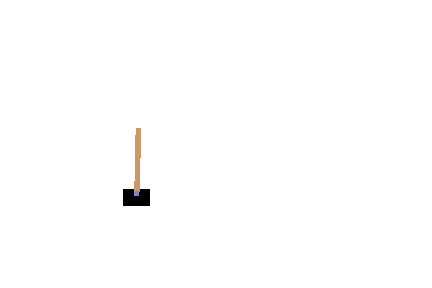
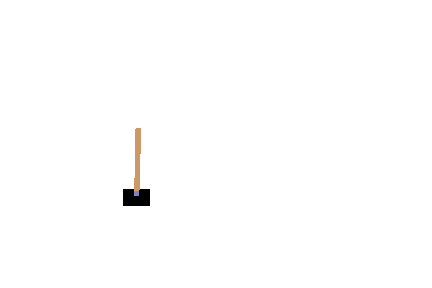
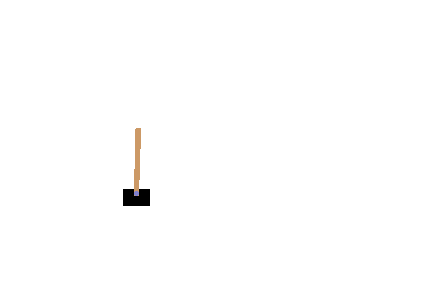
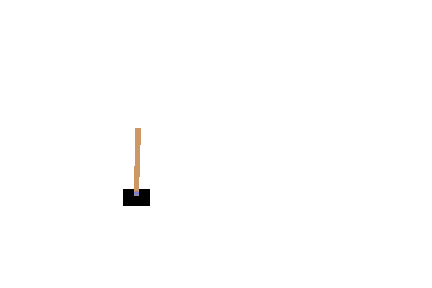
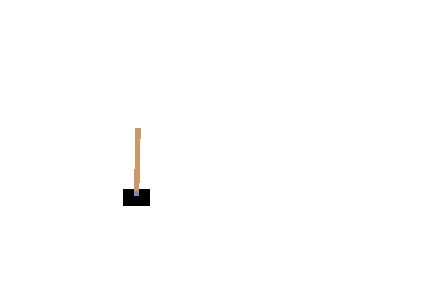
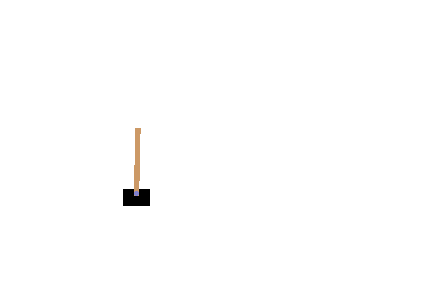
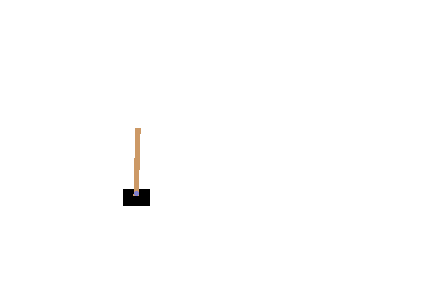
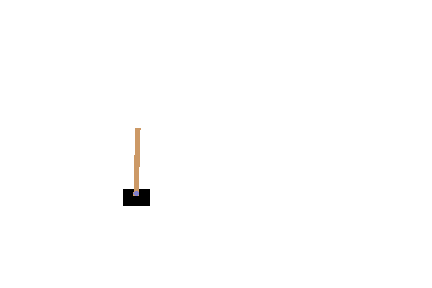
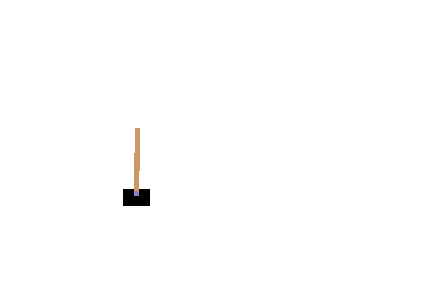
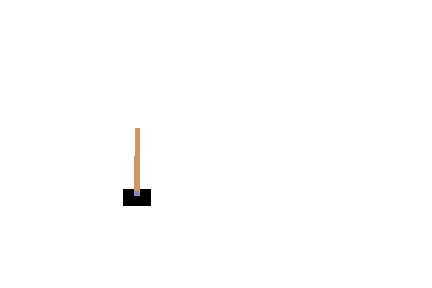
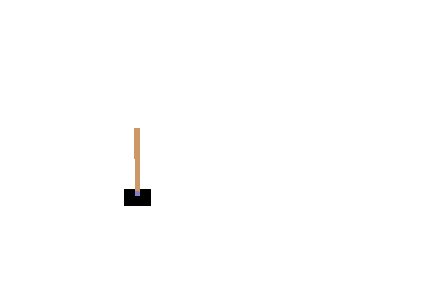
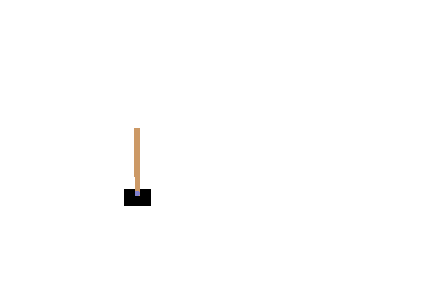
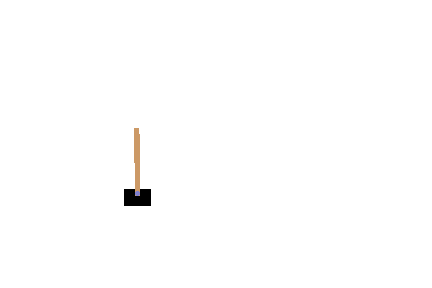
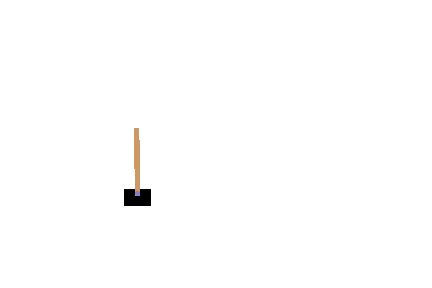
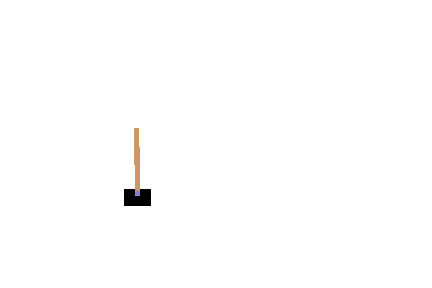
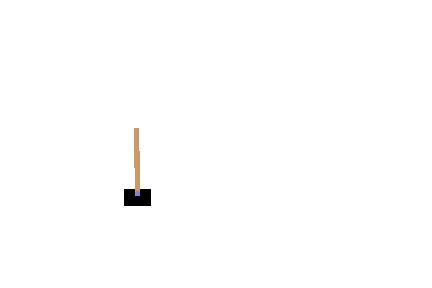
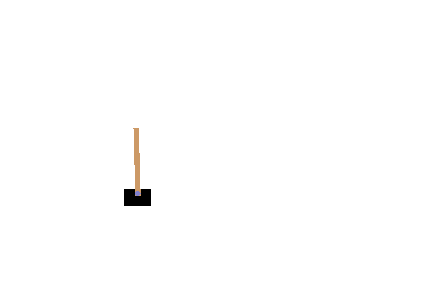
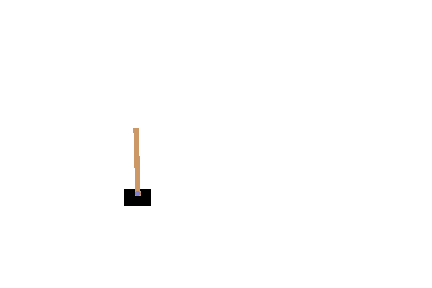
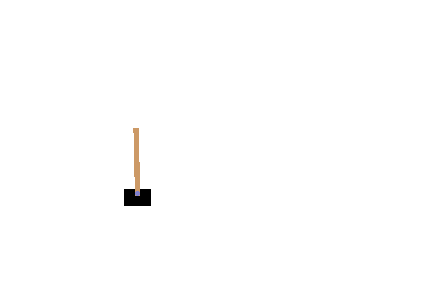
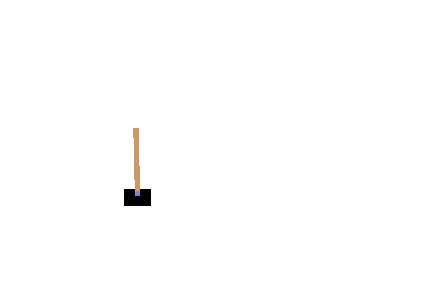
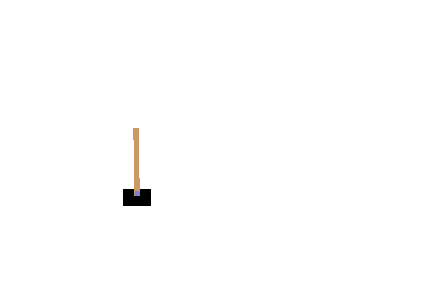
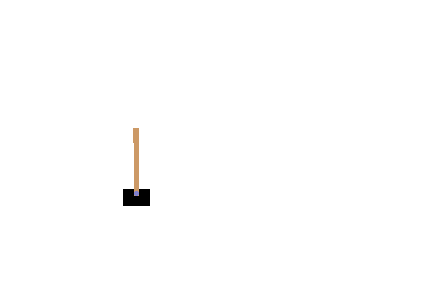
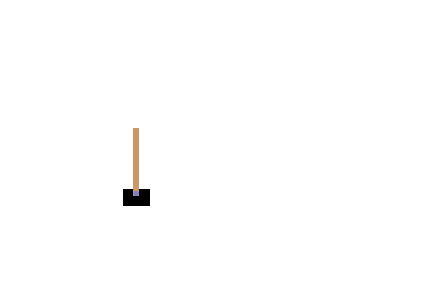
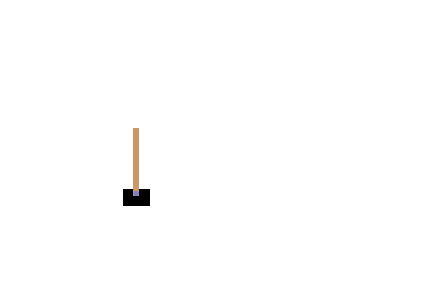
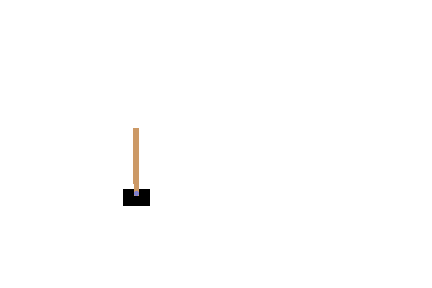
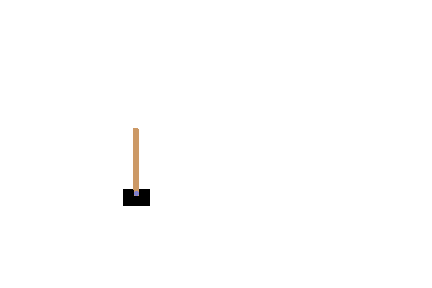
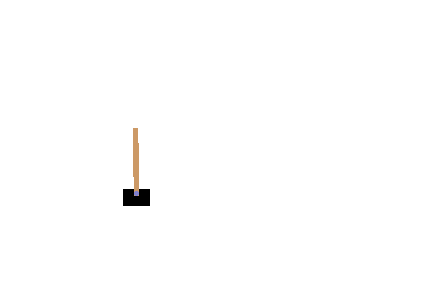
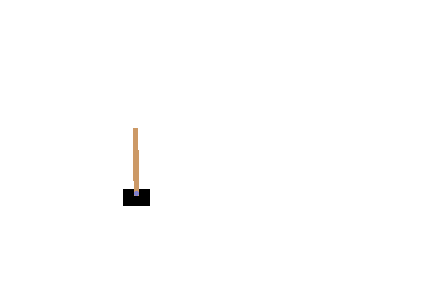
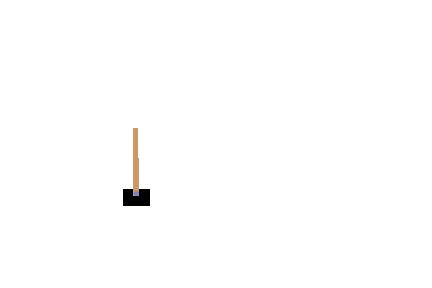
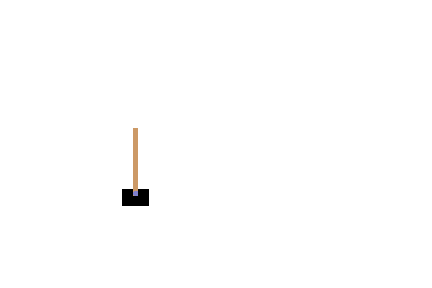
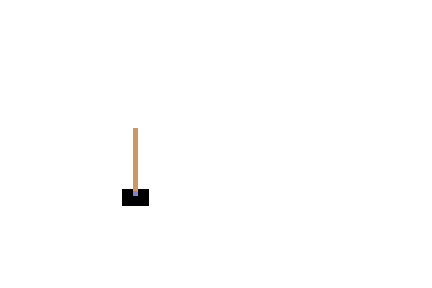
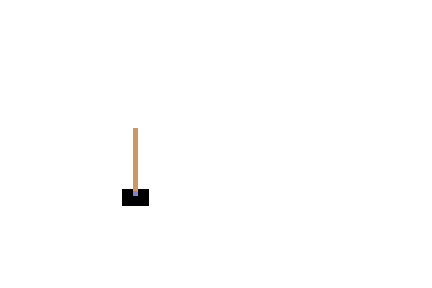
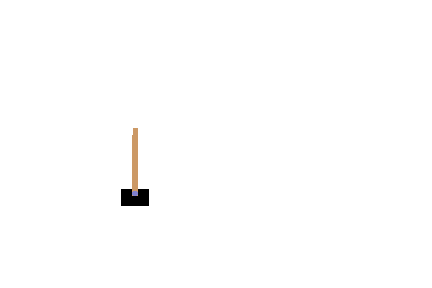
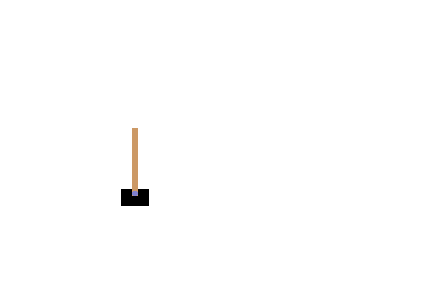
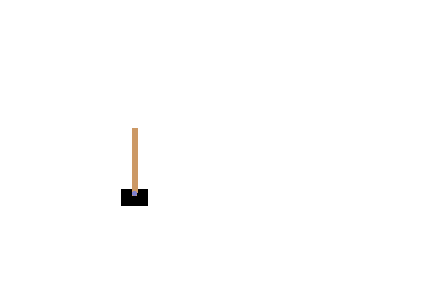
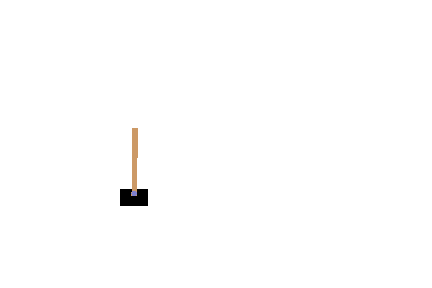
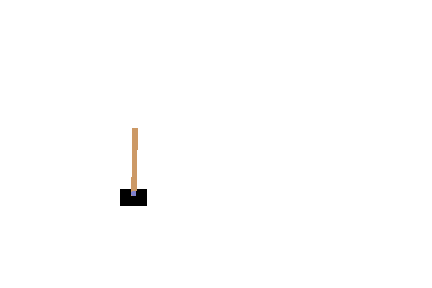
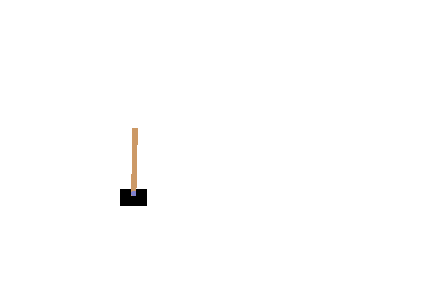
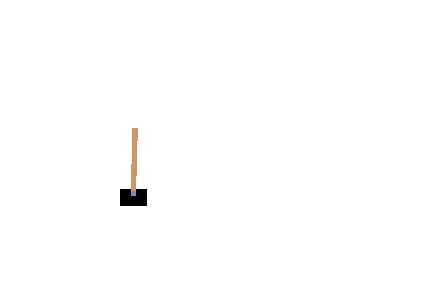
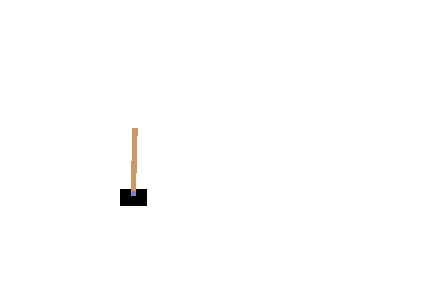
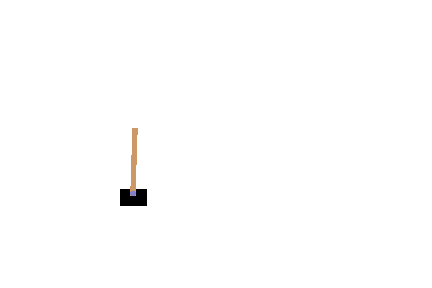
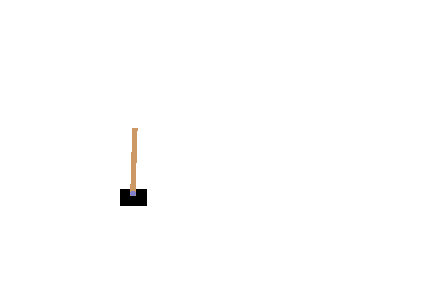
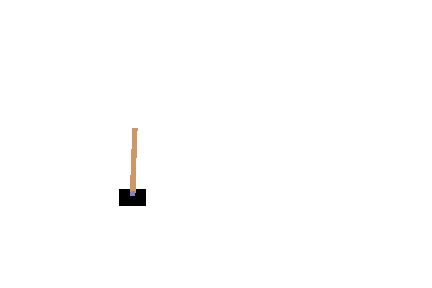
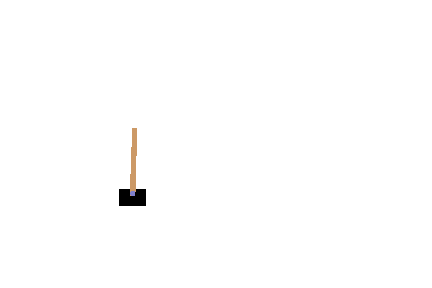
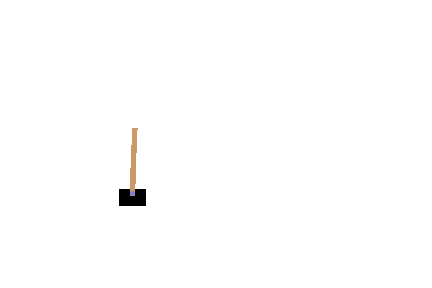
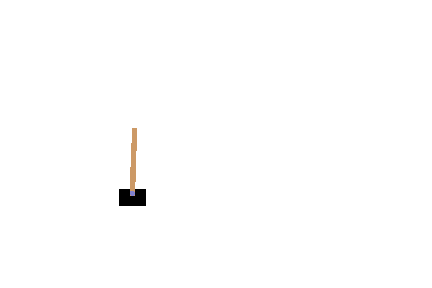
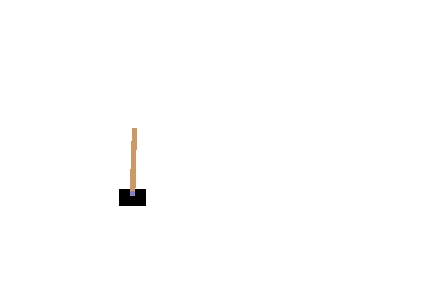
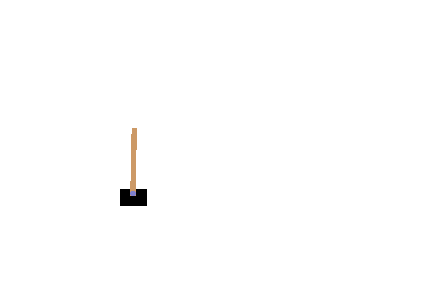
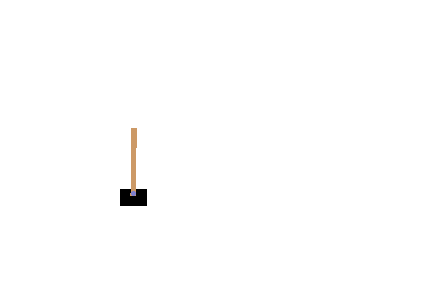
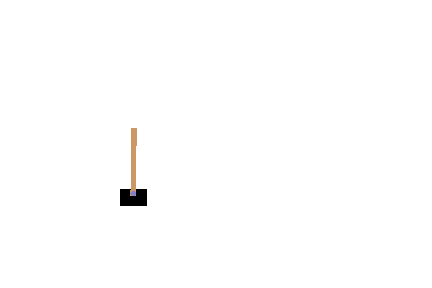
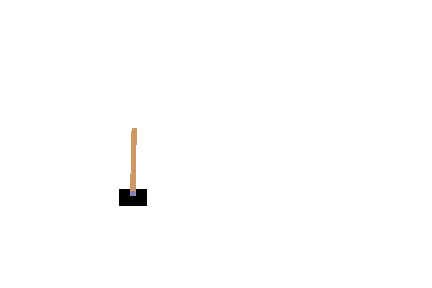
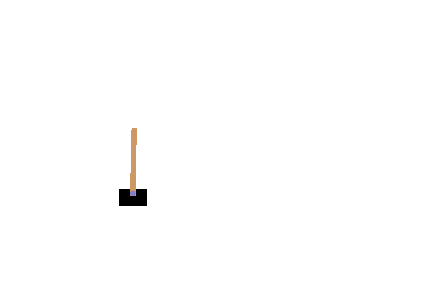
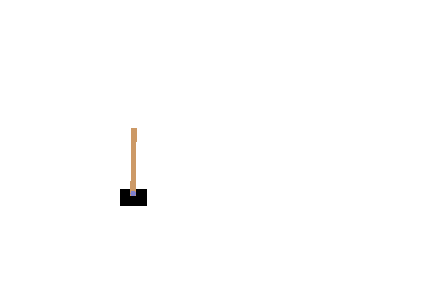
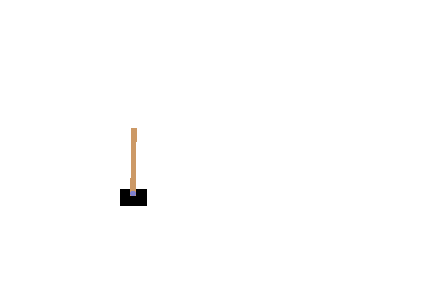
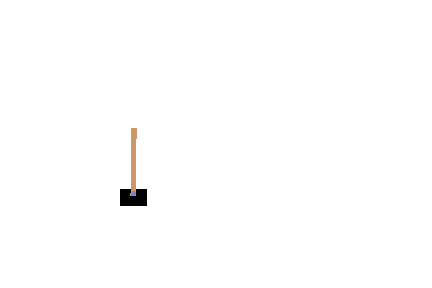
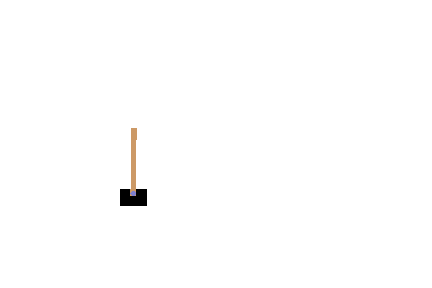
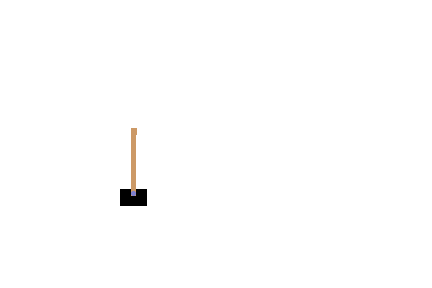
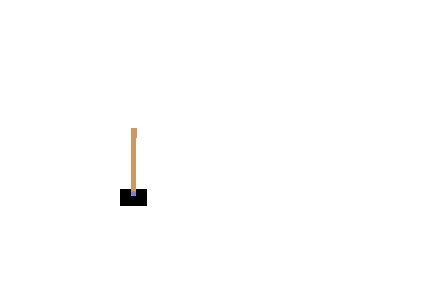
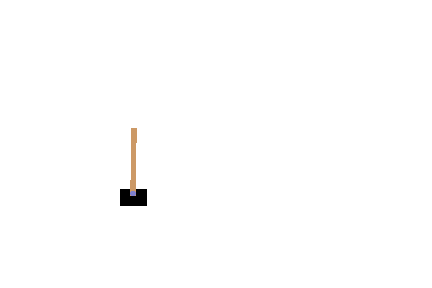
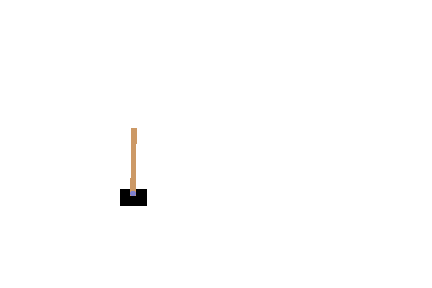
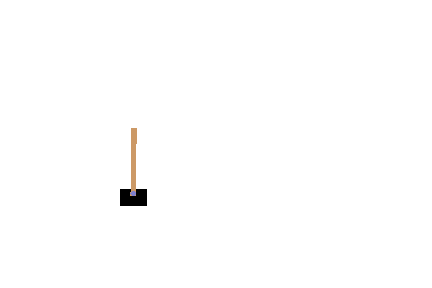
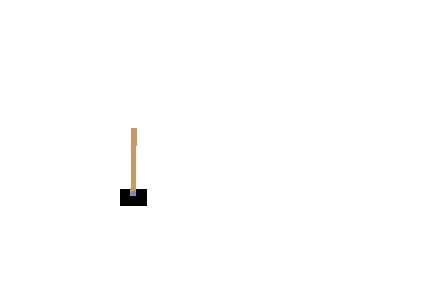
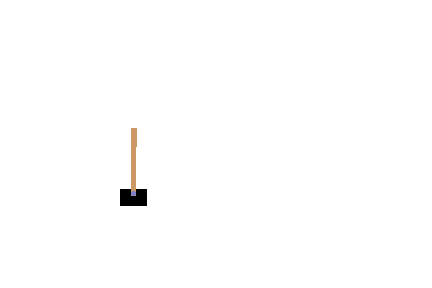
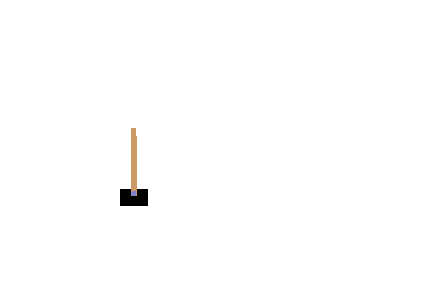
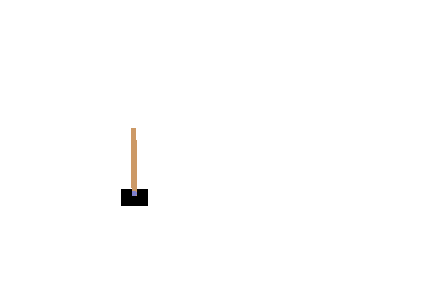
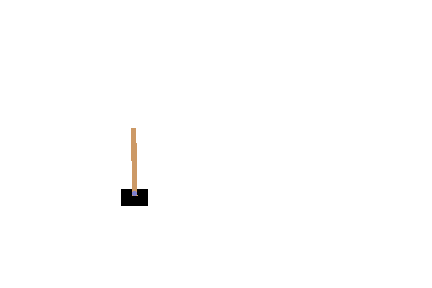
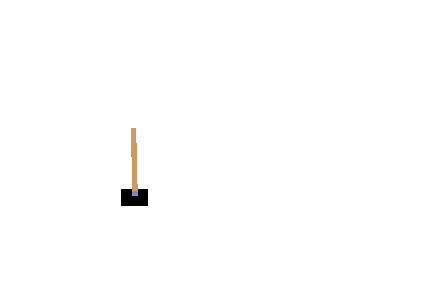
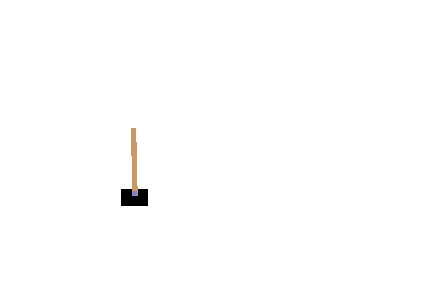
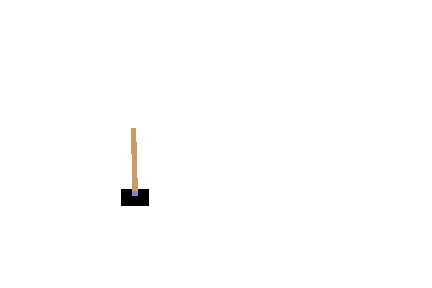
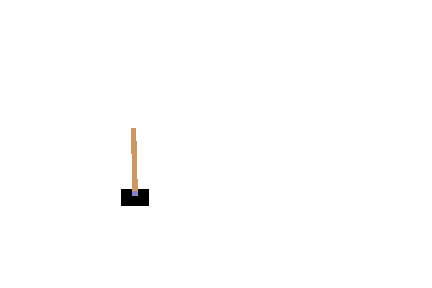
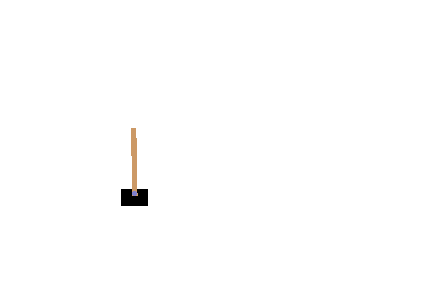
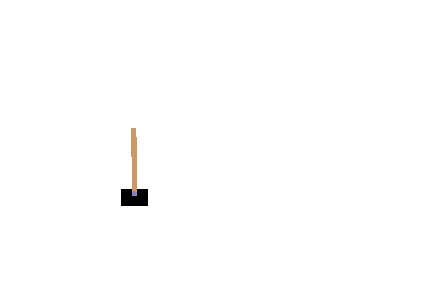
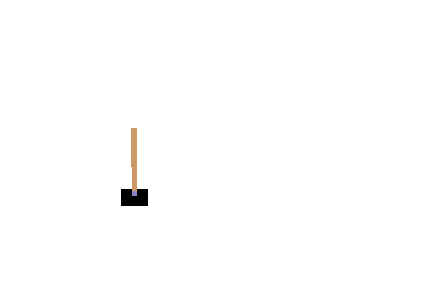
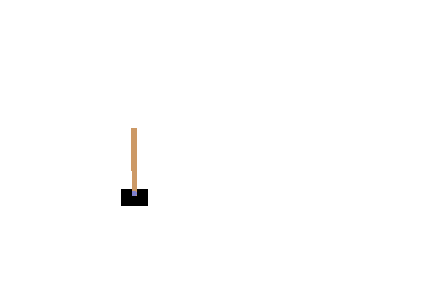
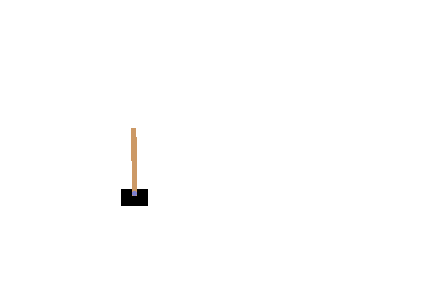
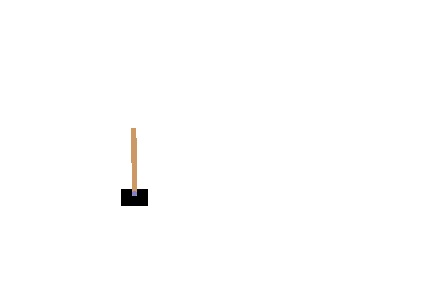
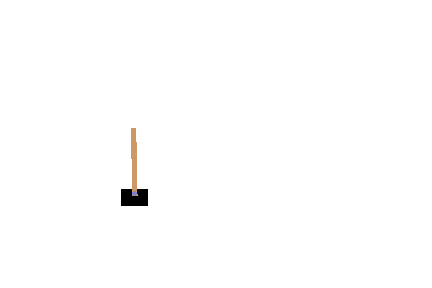
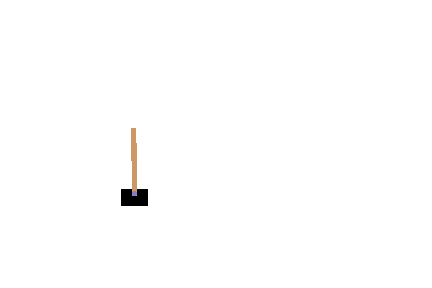
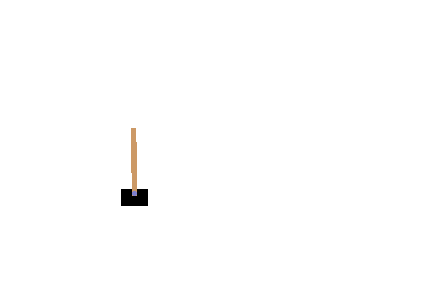
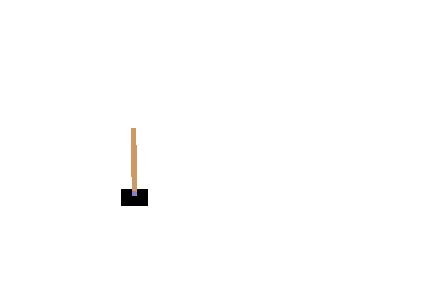

In [5]:
import numpy as np
from rlsuite.utils import display_frames_as_gif
%matplotlib inline

env = gym.make('CartPole-v1')
obs = env.reset()
frames = []
for _ in range(1000):
    frames.append(env.render(mode = 'rgb_array'))
    action_probs = np.squeeze(trained_policy(obs.reshape(1, -1)))
    action = np.random.choice(2, p=action_probs)
    obs, reward, done, _ = env.step(action)
    if done:
        env.reset()
env.close()
display_frames_as_gif(frames)

Perfect! Very occasionally, the agent drop the pole, but most of the time it reaches the maximum reward of 500. Note, however, that it took quite some time to get to this point. It took about 5000 episodes and about 30 minutes of compute on a standard MacBook to learn a simple task, for which our policy only requires 10 parameters. It is not uncommon for functions to have millions of trainable parameters, so one can only imagine how long that would take. And while we do not make a comparison to a better-performing algorithm here, the results do seem to suggest that REINFORCE is sample inefficient.

## Conclusion

We saw how to use the REINFORCE algorithm from RL Suite, discussed some of its tradeoffs, successfully applied it to a classic reinforcement learning problem, and took a look at what happens inside the neural network as training progressed. We found that the algorithm is very intuitive, but unfortunately doesn't have the best sample efficiency. If you are curious about other policy-gradient methods that fix some of the issues of REINFORCE, check out the following blog posts:

- [An Intro to Advantage Actor-Critic Methods](https://medium.freecodecamp.org/an-intro-to-advantage-actor-critic-methods-lets-play-sonic-the-hedgehog-86d6240171d)
- [Policy Gradient Algorithms](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html)
- [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html)

## References

- Sutton, R. S., Barto, A. G. (2018). [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html). The MIT Press.
- David Silver's RL coursesSlides. http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html.
- OpenAI Gym Enduro website. https://gym.openai.com/envs/Enduro-v0/.